In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spelling-grammar/charset_normalizer-2.1.0-py3-none-any.whl
/kaggle/input/spelling-grammar/language_tool_python-2.7.1-py3-none-any.whl
/kaggle/input/spelling-grammar/idna-3.3-py3-none-any.whl
/kaggle/input/spelling-grammar/autocorrect-2.6.1-py3-none-any.whl
/kaggle/input/spelling-grammar/pyspellchecker-0.6.3-py3-none-any.whl
/kaggle/input/spelling-grammar/urllib3-1.26.11-py2.py3-none-any.whl
/kaggle/input/spelling-grammar/certifi-2022.6.15-py3-none-any.whl
/kaggle/input/spelling-grammar/tqdm-4.64.0-py2.py3-none-any.whl
/kaggle/input/spelling-grammar/requests-2.28.1-py3-none-any.whl
/kaggle/input/textacy/__notebook_source__.ipynb
/kaggle/input/textacy/textacy/MarkupSafe-2.0.1-cp37-cp37m-manylinux2010_x86_64.whl
/kaggle/input/textacy/textacy/catalogue-2.0.4-py3-none-any.whl
/kaggle/input/textacy/textacy/blis-0.7.4-cp37-cp37m-manylinux2014_x86_64.whl
/kaggle/input/textacy/textacy/toolz-0.11.1-py3-none-any.whl
/kaggle/input/textacy/textacy/typing_extensions-3.10.0.0-py3-none-a

In [3]:
! pip install --no-index --no-deps ../input/textacy/textacy/textacy-0.11.0-py3-none-any.whl
! pip install --no-index --no-deps ../input/textacy/textacy/jellyfish-0.8.2-cp37-cp37m-manylinux2014_x86_64.whl
! pip install --no-index --no-deps ../input/textacy/textacy/pyphen-0.11.0-py3-none-any.whl
! pip install --no-index --no-deps ../input/textstat-pypi/textstat-0.7.0-py3-none-any.whl
! pip install --no-index --no-deps ../input/spelling-grammar/language_tool_python-2.7.1-py3-none-any.whl
! python -m spacy download en_core_web_md

Processing /kaggle/input/textacy/textacy/textacy-0.11.0-py3-none-any.whl
Processing /kaggle/input/textacy/textacy/jellyfish-0.8.2-cp37-cp37m-manylinux2014_x86_64.whl
Processing /kaggle/input/textacy/textacy/pyphen-0.11.0-py3-none-any.whl
Processing /kaggle/input/textstat-pypi/textstat-0.7.0-py3-none-any.whl
Processing /kaggle/input/spelling-grammar/language_tool_python-2.7.1-py3-none-any.whl
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/conda/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the ab

In [4]:
import re  # For preprocessing
import pandas as pd  # For data handling
pd.set_option('display.max_colwidth', 1000)
import numpy as np # linear algebra
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from spacy.lang.en import English
from spacy import displacy
import textacy
from textacy import extract, text_stats
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from operator import contains
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans, MeanShift
from sklearn.metrics.cluster import normalized_mutual_info_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from gensim.models import KeyedVectors
import multiprocessing
from gensim.models import Word2Vec
import gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

stemmer = PorterStemmer()


In [5]:
word2vec_path = '../input/google-word2vec/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [6]:
#!python -m spacy download en_core_web_md
from spacy import displacy
nlp = spacy.load('/kaggle/input/en-core-web-md/en_core_web_md/en_core_web_md-3.4.1')
stop_words = nlp.Defaults.stop_words

/opt/conda/lib/python3.7/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_md' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
original_df = pd.read_csv('/kaggle/input/techcrunch-posts-compilation/techcrunch_posts.csv')

In [8]:
original_df = original_df.dropna(subset=['category', 'title'])
original_df.shape

(38393, 11)

In [9]:
original_df.columns

Index(['authors', 'category', 'content', 'date', 'id', 'img_src', 'section',
       'tags', 'title', 'topics', 'url'],
      dtype='object')

In [10]:
df_1 = pd.DataFrame(original_df, columns = ('category', 'title'))

In [11]:
df_1.shape

(38393, 2)

In [105]:
df_1['category'].value_counts()

Apps                         5679
Gadgets                      3891
Europe                       2996
Startups                     2789
Enterprise                   2454
Social                       1851
Asia                         1246
Mobile                       1162
eCommerce                    1070
Fundings & Exits              917
Advertising Tech              722
Education                     361
Media                         287
Cloud                         283
Developer                     234
Gaming                        206
Finance                       185
Opinion                       175
Entertainment                 123
Collaborative Consumption     114
Artificial Intelligence       113
Health                        105
Government                     83
Earnings                       55
Diversity                      46
Bio                            44
Automotive                     36
Drama                          35
Augmented Reality              28
Hardware      

In [12]:
df_1.drop_duplicates(subset='title', inplace=True)

In [13]:
df_2 = df_1.sample(frac=0.5, random_state=42)
df_2.shape

(13760, 2)

In [113]:
df_2['category'].value_counts()


Apps                         4536
Gadgets                      3097
Europe                       2405
Startups                     2216
Enterprise                   1983
Social                       1489
Asia                         1023
Mobile                        933
eCommerce                     849
Fundings & Exits              758
Advertising Tech              571
Education                     276
Cloud                         232
Media                         229
Developer                     189
Gaming                        161
Opinion                       137
Finance                       130
Entertainment                  95
Collaborative Consumption      92
Artificial Intelligence        90
Health                         83
Government                     66
Earnings                       44
Diversity                      41
Bio                            36
Automotive                     27
Drama                          25
Augmented Reality              22
Security      

## TOKENIZATION

In [ ]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english')
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

nc = 4
km = MiniBatchKMeans(n_clusters = nc)
km.fit(x_vect)
pred_labels = km.labels_
print(Counter(pred_labels))

nmi = normalized_mutual_info_score(true_labels, pred_labels)
sil_score = silhouette_score(x_vect, pred_labels)
print('nmi =', nmi)
print("sil_score =",sil_score )

In [ ]:
stemmer = PorterStemmer()

# define custom tokenizer using stemmer
def stemming(text):
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [ ]:
def spacy_lemmatizer(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc]

In [108]:
def spacy_lemmatizer_pos(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
                tokens.append(token.lemma_ + '_' + token.pos_)
    return tokens

# COUNT VECTORIZER BASE MODEL

In [166]:
df_2

category  \
15955          Startups   
11668        Enterprise   
14904          Startups   
19308         Education   
6257   Advertising Tech   
...                 ...   
21918           Gadgets   
30774            Social   
37751          Startups   
25798            Europe   
11080           Gadgets   

                                                                                               title  \
15955                                        You’ve Only Got One Shot At Building A Consumer Unicorn   
11668                   Box Gets A Little More Palatable With Some Added Encryption From CipherCloud   
14904                               Pypestream Raises $2M To Help Businesses Talk To Their Customers   
19308  HealthKeep Launches An Anonymous Social Network To Let You Share And Track Health Information   
6257                                  Big Viking Games Acquires Mobile Marketing Startup Gallop Labs   
...                                                                                              ...   
21918                 BlackBerry Officially Unveils The Z3 “Jakarta Edition,” Its $200 Foxconn Phone   
30774                                                      Twitter Is Testing An Expandable Timeline   
37751                        Why Are Startups Flocking To SF? There’s No More Room In Silicon Valley   
25798                                                             Jamie Oliver Heats Up LeWeb London   
11080                                    The LightFreq Square2 Lets You Rock Out With Your Lights On   

       similarity  
15955         0.0  
11668         0.0  
14904         0.0  
19308         0.0  
6257          0.0  
...           ...  
21918         0.0  
30774         0.0  
37751         0.0  
25798         0.0  
11080         0.0  

[13760 rows x 3 columns]

In [117]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer()
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)
x_vect


(13760, 18190)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


000  000gb  01  018  023bn  03  04  04b  05  05m  ...  zula  zuli  \
0        0      0   0    0      0   0   0    0   0    0  ...     0     0   
1        0      0   0    0      0   0   0    0   0    0  ...     0     0   
2        0      0   0    0      0   0   0    0   0    0  ...     0     0   
3        0      0   0    0      0   0   0    0   0    0  ...     0     0   
4        0      0   0    0      0   0   0    0   0    0  ...     0     0   
...    ...    ...  ..  ...    ...  ..  ..  ...  ..  ...  ...   ...   ...   
13755    0      0   0    0      0   0   0    0   0    0  ...     0     0   
13756    0      0   0    0      0   0   0    0   0    0  ...     0     0   
13757    0      0   0    0      0   0   0    0   0    0  ...     0     0   
13758    0      0   0    0      0   0   0    0   0    0  ...     0     0   
13759    0      0   0    0      0   0   0    0   0    0  ...     0     0   

       zumbox  zumper  zuora  zurf  zymergen  zynga  zynstra  москва  
0           0       0      0     0         0      0        0       0  
1           0       0      0     0         0      0        0       0  
2           0       0      0     0         0      0        0       0  
3           0       0      0     0         0      0        0       0  
4           0       0      0     0         0      0        0       0  
...       ...     ...    ...   ...       ...    ...      ...     ...  
13755       0       0      0     0         0      0        0       0  
13756       0       0      0     0         0      0        0       0  
13757       0       0      0     0         0      0        0       0  
13758       0       0      0     0         0      0        0       0  
13759       0       0      0     0         0      0        0       0  

[13760 rows x 18190 columns]

In [148]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
29283     Gadgets   
17098   eCommerce   
6862   Enterprise   
7535   Enterprise   
2236     Startups   
27885     Gadgets   
23756      Social   
9838         Apps   
33857    Startups   
35516        Apps   
35794    Startups   
1599        Cloud   
3679   Enterprise   
35754        Apps   
12382      Europe   
36863     Opinion   
9791         Asia   
12655      Mobile   
22220      Europe   
23344      Europe   

                                                                                                             title  \
29283                                                  What You Need To Know About The Liberator 3D-Printed Pistol   
17098                                                          What You Need To Know To Get Started With Apple Pay   
6862                                         Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
7535                                                     Here’s What You Need To Know From Microsoft’s Cloud Event   
2236                                    Everything you need to know about the NSA hack (but were afraid to Google)   
27885                                        Samsung Wants You To Figure Out What To Do With Its Flexible Displays   
23756                  Powervoice Pivots: No Longer Pays You To Post About Brands (It Wants You To Do So For Free)   
9838                                   Kinsa’s New Smart Ear Thermometer Will Tell You What To Do When You’re Sick   
33857                                                        Why You Need To Pay Attention To General Solicitation   
35516                                   Arro For iPhone Tells You What To Buy While In The Store…And What To Avoid   
35794               Bandsintown Launches A Spotify App To Let You Know When Bands You Listen To Are Playing Nearby   
1599                               We learned from utilities everything we need to know about cloud infrastructure   
3679                                             Dell Needs To Decide What To Keep And What To Sell After EMC Deal   
35754       WishPop For iPad Brings Gift Wish Lists And Thank You Cards To Kids, Helps Grown-Ups Know What To Buy    
12382                                                                     What Is ‘La French Tech’ Supposed To Do?   
36863                                                             You Don’t Need A Prototype To Raise A Seed Round   
9791                                    Perpetu Lets You Decide What Happens To Your Online Accounts After You Die   
12655                                                  Now Facebook Wants You To Share Where You’re “Traveling To”   
22220  Darjeelin Wants To Help You Get A Cheaper Flight By Employing The Crowd To Do Your ‘Flight Hacking’ For You   
23344                         Well, What Do You Know: The UK Prime Minister’s iPad ‘App’ Is Real. We Have Details.   

                                                                                                       title_cleaned  \
29283                                                  what you need to know about the liberator 3d - printed pistol   
17098                                                            what you need to know to get started with apple pay   
6862                                          here ’s what you need to know about the latest leaked windows 10 build   
7535                                                     here ’s what you need to know from microsoft ’s cloud event   
2236                                    everything you need to know about the nsa hack ( but were afraid to google )   
27885                                          samsung wants you to figure out what to do with its flexible displays   
23756                 powervoice pivots : no longer pays you to post about brands ( it wants you to do so for free )   
9838                                   kinsa ’s new smart ear thermometer will tell you what to do when you ’re sick   
33857   

The similarity scores are very low. There is nothing about series A or Raising in the generated documents.


# COUNT VECTORIZER WITH STOP WORDS, WITHOUT STEMMING/LEMMATIZATION

In [160]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english')
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

(13760, 17938)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [162]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
17098         eCommerce   
7535         Enterprise   
2236           Startups   
29283           Gadgets   
1599              Cloud   
6862         Enterprise   
18655           Gadgets   
16008        Enterprise   
21933            Mobile   
13718              Apps   
20245          Startups   
18162        Enterprise   
10986           Gadgets   
21144        Enterprise   
24747  Fundings & Exits   
27666           Gadgets   
17110        Enterprise   
31356              Apps   
23444  Fundings & Exits   
18519              Apps   

                                                                                                                      title  \
17098                                                                   What You Need To Know To Get Started With Apple Pay   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
18655                                                  Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
16008                                                                            The Enterprise: I’m Not Sexy And I Know It   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
13718                                                                                      Bitstrips Is Raising $15 Million   
20245                                                                         How Many Languages Your Startup Needs To Know   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
10986                                                                                   Robot Writers Need Something To Say   
21144                                                                               Why We Need To Abolish Software Patents   
24747                                                                                    Sources: Coin Is Raising More Cash   
27666                                                                                This Is Why You Don’t Need A New Phone   
17110                                                                       Cloudwashing Failed – Now We Need New Metaphors   
31356                                                                       Moveline Packs Up $3 Million Series A From ffVC   
23444                                                                  Mack Weldon Stitches Together $4 Million In Series A   
18519                                                                              Plated Is Served $35 Million In Series B   

                                                                                      title_cleaned  \
17098                                                                   need know started apple pay   
7535                                                                need know microsoft cloud event   
2236                                                           need know nsa hack ( afraid google )   
29283                                                       need know liberator 3d - printed pistol   
1599                                               learned utilities need know cloud infrastructure   
6862                                                       need know latest leaked windows 10 build   
18655                              samsung level headphone

In [163]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
8287           Startups   
14500  Advertising Tech   
34757         Education   
33424          Startups   
33678          Startups   
7920          eCommerce   
12791          Startups   
17696            Mobile   
15281          Startups   
14045          Startups   
20921          Startups   
38988  Fundings & Exits   
20588          Startups   
15890           Gadgets   
1960   Fundings & Exits   
18817            Europe   
33489          Startups   
35230            Mobile   
1860             Europe   
13654          Startups   

                                                                                                            title  \
8287                                                                            How and why to pitch angel groups   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
12791                                                                                        The Art Of The Pitch   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
15890                                 Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
33489                                                                                 Pitch-Off. Tonight. Boston.   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1860                                                             Are you ready for Pitch Roulette at The Europas?   
13654                                                     Perfecto Is A Marketplace For Bikes That Are Not Stolen   

                                                                                      title_cleaned  \
8287                                                                             pitch angel groups   
14500                    leaked facebook video ad pitch deck reveals plans steal tv youtube dollars   
34757                                   deck khan academy : better diagnostics internationalization   
33424                                      haiku deck launches , brings upstart software , desktops   
33678                                                 boston meetup + pitch - month , apply pitch -   
7920                                      izberg marketplace turns website e - commerce marketplace   
12791                                                                                     art pitch   
17696                                       alpine ships new 7″ carplay - capable deck , cost $ 800   
15281                                                      pit

For the first query, we can see phrases that are questions show up inside the similar documents. However similarity scores for both queries are extremely low which means count vectorizer performance isn't good.

# COUNT VECTORIZER WITH STOP WORDS, WITH STEMMING

In [154]:
stemmer = PorterStemmer()

# define custom tokenizer using stemmer
def stemming(text):
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [155]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 16584)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [157]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
18162  Enterprise   
18303      Europe   
20245    Startups   
29283     Gadgets   
17098   eCommerce   
28102        Apps   
1599        Cloud   
399        Europe   
28474        Apps   
16367   Developer   
1159         Apps   
14718    Startups   
36863     Opinion   
4594    Developer   
26965     Gadgets   
8914         Asia   
5755        Cloud   
8156         Asia   
5194       Europe   
18837      Mobile   

                                                                                            title  \
18162                                      Need A New Name For Your Website? Why Not NameStation?   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
20245                                               How Many Languages Your Startup Needs To Know   
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
17098                                         What You Need To Know To Get Started With Apple Pay   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
1599              We learned from utilities everything we need to know about cloud infrastructure   
399                                        French online restaurant FoodChéri raises €6M Series A   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
1159                                            Will photo art phenom Prisma raise or get bought?   
14718                                                      You Just Raised $10 Million. Now What?   
36863                                            You Don’t Need A Prototype To Raise A Seed Round   
4594                                             GitHub Raises $250M Series B Round To Take Risks   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
8914                               GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
5755                                                                         Can You Hear Me Now?   
8156                                           Korean Bitcoin Exchange Korbit Raises $3M Series A   
5194                            Uniplaces Raises $24M In Series A Funding From Atomico And Angels   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   

                                                              title_cleaned  \
18162                                      need new website ? namestation ?   
18303  ? face speaker authentication startup keylemon raises $ 1.5 m series   
20245                                          languages startup needs know   
29283                               need know liberator 3d - printed pistol   
17098                                           need know started apple pay   
28102                                            check - needs work , fix ?   
1599                       learned utilities need know cloud infrastructure   
399                  french online restaurant foodchéri raises € 6 m series   
28474                             gogovan raises $ 6.5 m series expand asia   
16367                                    graduated engineering bootcamp ? ?   
1159                                 photo art phenom prisma raise bought ?   
14718                                               raised $ 10 million . ?   
36863                                       need prototype raise seed round   
4594                             github raises $ 250 m series b round risks   
26965                   need print teeny - weenie things ? lumifold covered   
8914                grabtaxi raises series , prepares expand southeast asia   
5755                                                                 hear ?   
8156                   

In [159]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
21055         Enterprise   
27464   Fundings & Exits   
34091           Startups   
11397         Government   
27037              Media   
27341             Social   
14266            Gadgets   
37107           Startups   
26126              Drama   
30121               Apps   
18164         Enterprise   
19678            Gadgets   
4567   Augmented Reality   
26911            Opinion   
24865               Apps   
37432           Startups   
25049             Europe   
26016            Gadgets   
3654             Gadgets   
34757          Education   

                                                                                                            title  \
21055                                                            Silicon Valley’s Dark Secret: It’s All About Age   
27464             Facebook’s Early Shareholders Will Sell Up To $5.5 Billion With IPO. Here’s Who’s Selling What:   
34091                              TechCrunch’s Picks: The Top 8 Startups From Y Combinator’s Summer ’13 Demo Day   
11397                                        Facebook’s Head Of Policy On Emotion Experiment: “That’s Innovation”   
27037                                               Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
27341                                   It’s Official: 15 Digg Engineers Are Joining Washington Post’s SocialCode   
14266                               SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
37107                                  TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
26126              Alexia’s Headphones: How We Used CrowdTilt’s Group-Funding Platform To Replace Stolen Property   
30121                                             Lightbox App Debuts New Photo Journal: It’s A Lazy Man’s Tumblr   
18164                 Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
19678                  Elon Musk’s Answer To Stephen Colbert’s Vision Of Ambient Wireless Charging: “We’ll Do It”   
4567                                                                      Computing’s future? It’s in your pocket   
26911                                                                     NASDAQ’s Gamble With Facebook’s Fortune   
24865         Facebook’s Instagram Deal Moves One Step Closer: UK’s Office Of Fair Trading Gives It The All-Clear   
37432                 This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
25049  Apple’s Feeling Europe’s Economic Crisis: ‘Essentially Flat’ Sales And A ‘Slowdown’ In Business, Says Cook   
26016                  Automatic’s Smart Driving Assistant Comes To Amazon So It’s Easier To Boost Your Ride’s IQ   
3654                                                                 Drones: Putting China’s economy on autopilot   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   

                                                                                             title_cleaned  \
21055                                                                     silicon valley dark secret : age   
27464                                       facebook early shareholders sell $ 5.5 billion ipo . selling :   
34091                                      techcrunch picks : 8 startups y combinator summer ’ 13 demo day   
11397                                             facebook head policy emotion experiment : “ innovation ”   
27037                                                 hearst latest social launch : redbook app father day   
27341                                      official : 15 digg engineers joining washington post socialcode   
14266                                  spacex rocket recovery attempt thwarted humanity oldest enemy : sea   
37107                                           techcrunch picks : 5 companies startx sum

Stemming has improved overall results as well as similarity scores. We can see for first query the keyword "series A" showing up more frequently. 
But for the second query results are still poor. There is no similar doc with word Pitch or Deck in it.

# COUNT VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION

In [167]:
def spacy_lemmatizer(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc]

In [168]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 15929)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [169]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
18162  Enterprise   
20245    Startups   
17098   eCommerce   
36863     Opinion   
18303      Europe   
1599        Cloud   
7535   Enterprise   
28102        Apps   
1159         Apps   
16367   Developer   
23433      Europe   
14718    Startups   
29283     Gadgets   
35514        Apps   
6862   Enterprise   
19549    Startups   
2236     Startups   
18351  Enterprise   
8914         Asia   
25682     Gadgets   

                                                                                                       title  \
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
20245                                                          How Many Languages Your Startup Needs To Know   
17098                                                    What You Need To Know To Get Started With Apple Pay   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
18303             Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
1159                                                       Will photo art phenom Prisma raise or get bought?   
16367                                                      Graduated From An Engineering Bootcamp? Now What?   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
14718                                                                 You Just Raised $10 Million. Now What?   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
18351                                                    Apptio Raises Another $50 Million In Series D Round   
8914                                          GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
25682                            Why Does Google Need So Many Robots? To Jump From The Web To The Real World   

       similarity  
18162    0.474342  
20245    0.447214  
17098    0.400000  
36863    0.400000  
18303    0.387298  
1599     0.365148  
7535     0.338062  
28102    0.338062  
1159     0.338062  
16367    0.338062  
23433    0.338062  
14718    0.338062  
29283    0.338062  
35514    0.325396  
6862     0.316228  
19549    0.316228  
2236     0.316228  
18351    0.316228  
8914     0.316228  
25682    0.316228

In [170]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
34757         Education   
8287           Startups   
14500  Advertising Tech   
27037             Media   
3654            Gadgets   
18158        Enterprise   
37432          Startups   
18164        Enterprise   
37107          Startups   
14266           Gadgets   
27450           Gadgets   
31353            Mobile   
24771            Social   
27039            Mobile   
647                Asia   
22608           Gadgets   
18910            Europe   
9297            Gadgets   
24162            Social   
24865              Apps   

                                                                                                     title  \
34757                           Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                     How and why to pitch angel groups   
14500                    Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
27037                                        Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
3654                                                          Drones: Putting China’s economy on autopilot   
18158                                                       Strategy For Startups: The Innovator’s Dilemma   
37432          This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
18164          Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
37107                           TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
14266                        SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
27450           Sony’s SmartWatch 2 Versus Samsung’s Galaxy Gear: Two Very Different Smartwatches Face Off   
31353                                              Twitter’s Next Focus: Simplify And Unify All Interfaces   
24771                     Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
27039                                       The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
647                           Netflix’s overseas problem: still too expensive and still not enough content   
22608                                           Google’s Environment Sensing Project Tango Gets A Teardown   
18910                                                      Reminder: The London Pitch-Off+Meetup Is Monday   
9297                                                              Wearables: A Pandora’s Box For Security?   
24162                                        Turning A Utility Into A Community: BranchOut’s Metamorphosis   
24865  Facebook’s Instagram Deal Moves One Step Closer: UK’s Office Of Fair Trading Gives It The All-Clear   

       similarity  
34757    0.387298  
8287     0.365148  
14500    0.273861  
27037    0.263117  
3654     0.258199  
18158    0.258199  
37432    0.253546  
18164    0.253546  
37107    0.253546  
14266    0.253546  
27450    0.244949  
31353    0.239046  
24771    0.239046  
27039    0.239046  
647      0.239046  
22608    0.239046  
18910    0.239046  
9297     0.239046  
24162    0.239046  
24865    0.237171

As compared to Stemming, lemmatization is performing poorly.

# COUNT VECTORIZER WITH STOP WORDS, WITH Stemming, ngram_range=(1,2)

In [257]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 99257)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [258]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
20245          Startups   
17098         eCommerce   
29283           Gadgets   
1599              Cloud   
18162        Enterprise   
8914               Asia   
2236           Startups   
6862         Enterprise   
32390  Fundings & Exits   
18303            Europe   
7535         Enterprise   
28102              Apps   
16367         Developer   
21933            Mobile   
5755              Cloud   
37934  Fundings & Exits   
399              Europe   
14718          Startups   
28474              Apps   
1159               Apps   

                                                                                                                      title  \
20245                                                                         How Many Languages Your Startup Needs To Know   
17098                                                                   What You Need To Know To Get Started With Apple Pay   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
18303                            Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
16367                                                                     Graduated From An Engineering Bootcamp? Now What?   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
5755                                                                                                   Can You Hear Me Now?   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
399                                                                  French online restaurant FoodChéri raises €6M Series A   
14718                                                                                You Just Raised $10 Million. Now What?   
28474                                                                       GoGoVan Raises $6.5M Series A To Expand In Asia   
1159                                                                      Will photo art phenom Prisma raise or get bought?   

       similarity  
20245    0.377964  
17098    0.377964  
29283    0.377964  
1599     0.314485  
18162    0.292770  
8914     0.292770  
2236     0.275010  
6862     0.275010  
32390    0.260133  
18303    0.247436  
7535     0.236433  
28102    0.227921  
16367    0.227921  
21933    0.226779  
5755     0.218218  
37934    0.210559  
399      0.209657  
14718    0.209657  
28474    0.209657  
1159     0.209657

In [259]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
21055         Enterprise   
27464   Fundings & Exits   
26911            Opinion   
4567   Augmented Reality   
26016            Gadgets   
27341             Social   
11397         Government   
27037              Media   
7535          Enterprise   
3220              Social   
8786            Earnings   
34091           Startups   
37576               Apps   
30121               Apps   
14266            Gadgets   
18164         Enterprise   
37107           Startups   
26126              Drama   
334             Startups   
19910             Mobile   

                                                                                                              title  \
21055                                                              Silicon Valley’s Dark Secret: It’s All About Age   
27464               Facebook’s Early Shareholders Will Sell Up To $5.5 Billion With IPO. Here’s Who’s Selling What:   
26911                                                                       NASDAQ’s Gamble With Facebook’s Fortune   
4567                                                                        Computing’s future? It’s in your pocket   
26016                    Automatic’s Smart Driving Assistant Comes To Amazon So It’s Easier To Boost Your Ride’s IQ   
27341                                     It’s Official: 15 Digg Engineers Are Joining Washington Post’s SocialCode   
11397                                          Facebook’s Head Of Policy On Emotion Experiment: “That’s Innovation”   
27037                                                 Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
7535                                                      Here’s What You Need To Know From Microsoft’s Cloud Event   
3220                                             Here’s What It’s Like To Set Up An On-Demand Geofilter On Snapchat   
8786                                                              Here’s Twitter’s Slowing User Growth In One Chart   
34091                                TechCrunch’s Picks: The Top 8 Startups From Y Combinator’s Summer ’13 Demo Day   
37576  Brewster’s Address Book App Briefly Exposes Ashton Kutcher’s & Others’ Private Data; Company Says It’s Fixed   
30121                                               Lightbox App Debuts New Photo Journal: It’s A Lazy Man’s Tumblr   
14266                                 SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
18164                   Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
37107                                    TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
26126                Alexia’s Headphones: How We Used CrowdTilt’s Group-Funding Platform To Replace Stolen Property   
334                                    White House’s SXSL shows what it’s like to be in the criminal justice system   
19910                                              Facebook’s Android Homescreen Could Expose Apple’s Inflexibility   

       similarity  
21055    0.374166  
27464    0.367112  
26911    0.349927  
4567     0.349927  
26016    0.343622  
27341    0.336011  
11397    0.336011  
27037    0.336011  
7535     0.334367  
3220     0.334367  
8786     0.334367  
34091    0.333914  
37576    0.326512  
30121    0.325669  
14266    0.325669  
18164    0.325669  
37107    0.325669  
26126    0.325669  
334      0.320713  
19910    0.320713

Using Ngrams has improved the performance, however for root words they are still not showing up in the top 5 similar docs.

# COUNT VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION/STEMMING, ngram_range=(1,3)

In [260]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,3))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 197199)


In [261]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
29283           Gadgets   
17098         eCommerce   
20245          Startups   
1599              Cloud   
18162        Enterprise   
8914               Asia   
2236           Startups   
6862         Enterprise   
5755              Cloud   
32390  Fundings & Exits   
7535         Enterprise   
18303            Europe   
16367         Developer   
28102              Apps   
21933            Mobile   
399              Europe   
14718          Startups   
28474              Apps   
1159               Apps   
37934  Fundings & Exits   

                                                                                                                      title  \
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
17098                                                                   What You Need To Know To Get Started With Apple Pay   
20245                                                                         How Many Languages Your Startup Needs To Know   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
5755                                                                                                   Can You Hear Me Now?   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
18303                            Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
16367                                                                     Graduated From An Engineering Bootcamp? Now What?   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
399                                                                  French online restaurant FoodChéri raises €6M Series A   
14718                                                                                You Just Raised $10 Million. Now What?   
28474                                                                       GoGoVan Raises $6.5M Series A To Expand In Asia   
1159                                                                      Will photo art phenom Prisma raise or get bought?   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   

       similarity  
29283    0.327327  
17098    0.327327  
20245    0.327327  
1599     0.267261  
18162    0.253546  
8914     0.247436  
2236     0.231455  
6862     0.231455  
5755     0.218218  
32390    0.218218  
7535     0.207020  
18303    0.207020  
16367    0.202031  
28102    0.195180  
21933    0.188982  
399      0.178174  
14718    0.178174  
28474    0.178174  
1159     0.178174  
37934    0.174964

Even though the overall similarity scores are low, we can see more relevant documents showing up with stemming

In [176]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
8287           Startups   
34757         Education   
14500  Advertising Tech   
12791          Startups   
27037             Media   
3654            Gadgets   
18158        Enterprise   
18164        Enterprise   
37432          Startups   
14266           Gadgets   
37107          Startups   
22444         eCommerce   
27450           Gadgets   
26911           Opinion   
9297            Gadgets   
31353            Mobile   
27039            Mobile   
24162            Social   
24771            Social   
22608           Gadgets   

                                                                                                   title  \
8287                                                                   How and why to pitch angel groups   
34757                         Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
14500                  Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
12791                                                                               The Art Of The Pitch   
27037                                      Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
3654                                                        Drones: Putting China’s economy on autopilot   
18158                                                     Strategy For Startups: The Innovator’s Dilemma   
18164        Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
37432        This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
14266                      SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
37107                         TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
22444  Rally.org Powers A Donation Drive With Prizes To Spend Time With Silicon Valley’s Top Angels, VCs   
27450         Sony’s SmartWatch 2 Versus Samsung’s Galaxy Gear: Two Very Different Smartwatches Face Off   
26911                                                            NASDAQ’s Gamble With Facebook’s Fortune   
9297                                                            Wearables: A Pandora’s Box For Security?   
31353                                            Twitter’s Next Focus: Simplify And Unify All Interfaces   
27039                                     The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
24162                                      Turning A Utility Into A Community: BranchOut’s Metamorphosis   
24771                   Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
22608                                         Google’s Environment Sensing Project Tango Gets A Teardown   

       similarity  
8287     0.235702  
34757    0.223607  
14500    0.201008  
12791    0.166667  
27037    0.153093  
3654     0.149071  
18158    0.149071  
18164    0.146385  
37432    0.146385  
14266    0.146385  
37107    0.146385  
22444    0.144338  
27450    0.140488  
26911    0.140028  
9297     0.136083  
31353    0.136083  
27039    0.136083  
24162    0.136083  
24771    0.136083  
22608    0.136083

# COUNT VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION, ngram_range=(1,2), Max_features

In [262]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2), max_features = 3000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [263]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
29283     Gadgets   
18162  Enterprise   
1159         Apps   
20245    Startups   
399        Europe   
18303      Europe   
26965     Gadgets   
28102        Apps   
16367   Developer   
1599        Cloud   
17098   eCommerce   
23433      Europe   
4747         Asia   
18837      Mobile   
2236     Startups   
19549    Startups   
28245        Apps   
25458      Europe   
28474        Apps   
1093         Apps   

                                                                                            title  \
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
18162                                      Need A New Name For Your Website? Why Not NameStation?   
1159                                            Will photo art phenom Prisma raise or get bought?   
20245                                               How Many Languages Your Startup Needs To Know   
399                                        French online restaurant FoodChéri raises €6M Series A   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
1599              We learned from utilities everything we need to know about cloud infrastructure   
17098                                         What You Need To Know To Get Started With Apple Pay   
23433                               Do We Need Another Angel List? NOAH Insider Seems To Think So   
4747                             Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
2236                   Everything you need to know about the NSA hack (but were afraid to Google)   
19549                                Turnaround Management: Does Your Company Need A New Captain?   
28245          Oink Users: Need A New Home For Your Data? Turn That Frown Upside Down With Cheers   
25458                                          ShareMyPlaylists Gets A Much Needed Android Reboot   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
1093                Frame.io raises a $10M Series A with Jared Leto and Kevin Spacey as investors   

       similarity  
29283    0.516398  
18162    0.474342  
1159     0.400000  
20245    0.400000  
399      0.400000  
18303    0.387298  
26965    0.365148  
28102    0.365148  
16367    0.365148  
1599     0.365148  
17098    0.365148  
23433    0.338062  
4747     0.338062  
18837    0.338062  
2236     0.338062  
19549    0.338062  
28245    0.316228  
25458    0.316228  
28474    0.316228  
1093     0.316228

In [ ]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 3000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

In [179]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)

results.head(20)

category  \
8287        Startups   
34757      Education   
4447   Entertainment   
17875      eCommerce   
18680         Mobile   
24162         Social   
14266        Gadgets   
27037          Media   
18158     Enterprise   
37703       Startups   
37432       Startups   
18164     Enterprise   
27039         Mobile   
37735       Startups   
24771         Social   
26911        Opinion   
647             Asia   
38000       Startups   
26517      eCommerce   
3654         Gadgets   

                                                                                             title  \
8287                                                             How and why to pitch angel groups   
34757                   Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
4447                                         An excerpt from Eliot Peper’s cyberpunk novel Cumulus   
17875                                                     JustFab’s Checkout Tactics Are JustShady   
18680          Iterations: A Youthful Rebellion Against The Permanence Of Facebook’s Walled Garden   
24162                                Turning A Utility Into A Community: BranchOut’s Metamorphosis   
14266                SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
27037                                Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
18158                                               Strategy For Startups: The Innovator’s Dilemma   
37703             Infographics That Don’t Suck: FindTheBest’s Comparison Charts Are Now Embeddable   
37432  This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
18164  Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
27039                               The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
37735                            TCTV: Interact’s Anthony Coombs Talks About The Philly Tech Scene   
24771             Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
26911                                                      NASDAQ’s Gamble With Facebook’s Fortune   
647                   Netflix’s overseas problem: still too expensive and still not enough content   
38000                             For Your Programmer’s Arsenal: A Working Clippy For Any Web Page   
26517      Ezra’s Craft Liquor Marketplace Helps You Understand All The Subtle Notes Of Your Drink   
3654                                                  Drones: Putting China’s economy on autopilot   

       similarity  
8287     0.516398  
34757    0.447214  
4447     0.447214  
17875    0.447214  
18680    0.447214  
24162    0.447214  
14266    0.447214  
27037    0.404520  
18158    0.400000  
37703    0.400000  
37432    0.387298  
18164    0.387298  
27039    0.365148  
37735    0.365148  
24771    0.365148  
26911    0.365148  
647      0.365148  
38000    0.365148  
26517    0.365148  
3654     0.365148

Query 1 is run by using stemming, query 2 is run by lemma. We can see results with stemming are more coherent and relevant.

In [264]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2), max_features = 5000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [265]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
29283     Gadgets   
20245    Startups   
17098   eCommerce   
1599        Cloud   
18162  Enterprise   
2236     Startups   
1159         Apps   
399        Europe   
18303      Europe   
6862   Enterprise   
26965     Gadgets   
23433      Europe   
28102        Apps   
16367   Developer   
36837    Startups   
5755        Cloud   
15820  Enterprise   
4747         Asia   
19549    Startups   
18837      Mobile   

                                                                                            title  \
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                               How Many Languages Your Startup Needs To Know   
17098                                         What You Need To Know To Get Started With Apple Pay   
1599              We learned from utilities everything we need to know about cloud infrastructure   
18162                                      Need A New Name For Your Website? Why Not NameStation?   
2236                   Everything you need to know about the NSA hack (but were afraid to Google)   
1159                                            Will photo art phenom Prisma raise or get bought?   
399                                        French online restaurant FoodChéri raises €6M Series A   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
6862                        Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
23433                               Do We Need Another Angel List? NOAH Insider Seems To Think So   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
36837          Need To Find And Book A Photography Class? Vimbly Is Like OpenTable For Activities   
5755                                                                         Can You Hear Me Now?   
15820       Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   
4747                             Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
19549                                Turnaround Management: Does Your Company Need A New Captain?   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   

       similarity  
29283    0.612372  
20245    0.500000  
17098    0.462910  
1599     0.433013  
18162    0.408248  
2236     0.408248  
1159     0.365148  
399      0.365148  
18303    0.353553  
6862     0.339683  
26965    0.333333  
23433    0.308607  
28102    0.308607  
16367    0.308607  
36837    0.288675  
5755     0.288675  
15820    0.288675  
4747     0.288675  
19549    0.288675  
18837    0.288675

In [180]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 5000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [182]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
34757         Education   
8287           Startups   
14266           Gadgets   
18158        Enterprise   
27037             Media   
37432          Startups   
14500  Advertising Tech   
5462           Startups   
27039            Mobile   
24162            Social   
18680            Mobile   
26517         eCommerce   
24771            Social   
26911           Opinion   
38000          Startups   
3654            Gadgets   
26126             Drama   
18164        Enterprise   
647                Asia   
15629        Enterprise   

                                                                                                title  \
34757                      Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                How and why to pitch angel groups   
14266                   SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
18158                                                  Strategy For Startups: The Innovator’s Dilemma   
27037                                   Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
37432     This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
14500               Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
5462                      Unicorns along the Wasatch: Utah’s flourishing startup and enterprise scene   
27039                                  The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
24162                                   Turning A Utility Into A Community: BranchOut’s Metamorphosis   
18680             Iterations: A Youthful Rebellion Against The Permanence Of Facebook’s Walled Garden   
26517         Ezra’s Craft Liquor Marketplace Helps You Understand All The Subtle Notes Of Your Drink   
24771                Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
26911                                                         NASDAQ’s Gamble With Facebook’s Fortune   
38000                                For Your Programmer’s Arsenal: A Working Clippy For Any Web Page   
3654                                                     Drones: Putting China’s economy on autopilot   
26126  Alexia’s Headphones: How We Used CrowdTilt’s Group-Funding Platform To Replace Stolen Property   
18164     Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
647                      Netflix’s overseas problem: still too expensive and still not enough content   
15629                         Yammer’s Cindy Alvarez: Five Types of People I Should Have Fired Sooner   

       similarity  
34757    0.707107  
8287     0.384900  
14266    0.316228  
18158    0.298142  
27037    0.288675  
37432    0.288675  
14500    0.277350  
5462     0.272166  
27039    0.272166  
24162    0.272166  
18680    0.272166  
26517    0.272166  
24771    0.272166  
26911    0.272166  
38000    0.272166  
3654     0.272166  
26126    0.267261  
18164    0.258199  
647      0.251976  
15629    0.251976

Increasing the max features has reduced overall performance.

In [183]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 1000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 1000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [184]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
18162        Enterprise   
16367         Developer   
20245          Startups   
1599              Cloud   
14761        Enterprise   
5417   Fundings & Exits   
15086            Europe   
29283           Gadgets   
1159               Apps   
23433            Europe   
36863           Opinion   
26965           Gadgets   
18303            Europe   
17098         eCommerce   
36837          Startups   
2236           Startups   
19549          Startups   
18837            Mobile   
35514              Apps   
4747               Asia   

                                                                                                       title  \
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
16367                                                      Graduated From An Engineering Bootcamp? Now What?   
20245                                                          How Many Languages Your Startup Needs To Know   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
14761                          Marc Benioff Has Swagger But What About That Salesforce.com Income Statement?   
5417                                                                       Who Is Chris Poole Without 4chan?   
15086                                                                   Dónde Están Sus Hijos? Ask DondeEsta   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
1159                                                       Will photo art phenom Prisma raise or get bought?   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
26965                                        Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
18303             Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
17098                                                    What You Need To Know To Get Started With Apple Pay   
36837                     Need To Find And Book A Photography Class? Vimbly Is Like OpenTable For Activities   
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
18837                                 Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
4747                                        Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   

       similarity  
18162    0.507093  
16367    0.447214  
20245    0.447214  
1599     0.447214  
14761    0.447214  
5417     0.447214  
15086    0.447214  
29283    0.400000  
1159     0.400000  
23433    0.400000  
36863    0.400000  
26965    0.400000  
18303    0.372104  
17098    0.365148  
36837    0.365148  
2236     0.365148  
19549    0.365148  
18837    0.365148  
35514    0.358569  
4747     0.338062

In [266]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2), max_features = 1000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 1000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [268]:
query = "What do you need to know about raising a series A?"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
29283           Gadgets   
18162        Enterprise   
5417   Fundings & Exits   
20245          Startups   
5755              Cloud   
1159               Apps   
15086            Europe   
18837            Mobile   
18303            Europe   
399              Europe   
16367         Developer   
28102              Apps   
1599              Cloud   
4747               Asia   
26965           Gadgets   
36837          Startups   
28474              Apps   
5194             Europe   
17098         eCommerce   
2236           Startups   

                                                                                            title  \
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
18162                                      Need A New Name For Your Website? Why Not NameStation?   
5417                                                            Who Is Chris Poole Without 4chan?   
20245                                               How Many Languages Your Startup Needs To Know   
5755                                                                         Can You Hear Me Now?   
1159                                            Will photo art phenom Prisma raise or get bought?   
15086                                                        Dónde Están Sus Hijos? Ask DondeEsta   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
399                                        French online restaurant FoodChéri raises €6M Series A   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
1599              We learned from utilities everything we need to know about cloud infrastructure   
4747                             Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
36837          Need To Find And Book A Photography Class? Vimbly Is Like OpenTable For Activities   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
5194                            Uniplaces Raises $24M In Series A Funding From Atomico And Angels   
17098                                         What You Need To Know To Get Started With Apple Pay   
2236                   Everything you need to know about the NSA hack (but were afraid to Google)   

       similarity  
29283    0.632456  
18162    0.474342  
5417     0.447214  
20245    0.447214  
5755     0.447214  
1159     0.447214  
15086    0.447214  
18837    0.447214  
18303    0.424264  
399      0.400000  
16367    0.400000  
28102    0.400000  
1599     0.400000  
4747     0.400000  
26965    0.400000  
36837    0.365148  
28474    0.365148  
5194     0.365148  
17098    0.365148  
2236     0.338062

As compared to lemmatization we see stemming performs better but the model's performance was much better when max_features were 3000 as compared to 5K or 1K.

In [183]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2), max_features = 1000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 1000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [185]:
query = "Pitch Deck Teardown: MiO Marketplace’s angel deck"
query_vec = cnt_vectorizer.transform([query])

sims = []
for i in range(len(df_2['title'])):
    doc_vec = X[i]
    similarity_scores = cosine_similarity(query_vec, doc_vec)
    similarity_scores = similarity_scores.flatten()[0]
    sims.append(similarity_scores)
    
# Add similarity scores to the DataFrame
df_2['similarity'] = sims

# Sort the results by similarity score
results = df_2.sort_values(by='similarity', ascending=False)


results.head(20)

category  \
37703       Startups   
18158     Enterprise   
8287        Startups   
14266        Gadgets   
28678         Health   
37735       Startups   
17875      eCommerce   
5462        Startups   
27039         Mobile   
34757      Education   
24162         Social   
15704        Gadgets   
13654       Startups   
18680         Mobile   
4447   Entertainment   
26517      eCommerce   
18164     Enterprise   
27037          Media   
19678        Gadgets   
14664     Enterprise   

                                                                                                   title  \
37703                   Infographics That Don’t Suck: FindTheBest’s Comparison Charts Are Now Embeddable   
18158                                                     Strategy For Startups: The Innovator’s Dilemma   
8287                                                                   How and why to pitch angel groups   
14266                      SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
28678                                              Bikanta’s Tiny Diamonds Find Cancer Before It Spreads   
37735                                  TCTV: Interact’s Anthony Coombs Talks About The Philly Tech Scene   
17875                                                           JustFab’s Checkout Tactics Are JustShady   
5462                         Unicorns along the Wasatch: Utah’s flourishing startup and enterprise scene   
27039                                     The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
34757                         Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
24162                                      Turning A Utility Into A Community: BranchOut’s Metamorphosis   
15704                              The ToneWoodAmp Blows Amplified Sound Out Of Your Guitar’s Sound Hole   
13654                                            Perfecto Is A Marketplace For Bikes That Are Not Stolen   
18680                Iterations: A Youthful Rebellion Against The Permanence Of Facebook’s Walled Garden   
4447                                               An excerpt from Eliot Peper’s cyberpunk novel Cumulus   
26517            Ezra’s Craft Liquor Marketplace Helps You Understand All The Subtle Notes Of Your Drink   
18164        Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
27037                                      Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
19678         Elon Musk’s Answer To Stephen Colbert’s Vision Of Ambient Wireless Charging: “We’ll Do It”   
14664  Intel’s Q4 A Mixed Bag: Misses Estimates With $0.48 EPS, But Nails The Street’s Revenue Consensus   

       similarity  
37703    0.632456  
18158    0.516398  
8287     0.516398  
14266    0.507093  
28678    0.447214  
37735    0.447214  
17875    0.447214  
5462     0.447214  
27039    0.447214  
34757    0.447214  
24162    0.447214  
15704    0.447214  
13654    0.447214  
18680    0.447214  
4447     0.447214  
26517    0.447214  
18164    0.447214  
27037    0.404520  
19678    0.404520  
14664    0.404520

# COUNT VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION/STEMMING, MAX_DF = 0.5

In [269]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming,max_df = 0.5) #ngram_range = (1,2), max_features = 1000)
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 16584)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [270]:
X2 = cnt_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18162                                      Need A New Name For Your Website? Why Not NameStation?   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
20245                                               How Many Languages Your Startup Needs To Know   
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
17098                                         What You Need To Know To Get Started With Apple Pay   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
1599              We learned from utilities everything we need to know about cloud infrastructure   
399                                        French online restaurant FoodChéri raises €6M Series A   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
1159                                            Will photo art phenom Prisma raise or get bought?   
14718                                                      You Just Raised $10 Million. Now What?   
36863                                            You Don’t Need A Prototype To Raise A Seed Round   
4594                                             GitHub Raises $250M Series B Round To Take Risks   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
8914                               GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
5755                                                                         Can You Hear Me Now?   
8156                                           Korean Bitcoin Exchange Korbit Raises $3M Series A   
5194                            Uniplaces Raises $24M In Series A Funding From Atomico And Angels   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   

         category  similarity  
18162  Enterprise    0.447214  
18303      Europe    0.404520  
20245    Startups    0.400000  
29283     Gadgets    0.400000  
17098   eCommerce    0.400000  
28102        Apps    0.365148  
1599        Cloud    0.338062  
399        Europe    0.338062  
28474        Apps    0.338062  
16367   Developer    0.338062  
1159         Apps    0.338062  
14718    Startups    0.338062  
36863     Opinion    0.316228  
4594    Developer    0.316228  
26965     Gadgets    0.316228  
8914         Asia    0.316228  
5755        Cloud    0.316228  
8156         Asia    0.316228  
5194       Europe    0.316228  
18837      Mobile    0.316228

Using max_df and stemming, we can see that the second most relevant document has our core keyword "series A"

In [189]:
X2 = cnt_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                           Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                     How and why to pitch angel groups   
14500                    Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
27037                                        Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
3654                                                          Drones: Putting China’s economy on autopilot   
18158                                                       Strategy For Startups: The Innovator’s Dilemma   
37432          This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
18164          Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
37107                           TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
14266                        SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
27450           Sony’s SmartWatch 2 Versus Samsung’s Galaxy Gear: Two Very Different Smartwatches Face Off   
31353                                              Twitter’s Next Focus: Simplify And Unify All Interfaces   
24771                     Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
27039                                       The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
647                           Netflix’s overseas problem: still too expensive and still not enough content   
22608                                           Google’s Environment Sensing Project Tango Gets A Teardown   
18910                                                      Reminder: The London Pitch-Off+Meetup Is Monday   
9297                                                              Wearables: A Pandora’s Box For Security?   
24162                                        Turning A Utility Into A Community: BranchOut’s Metamorphosis   
24865  Facebook’s Instagram Deal Moves One Step Closer: UK’s Office Of Fair Trading Gives It The All-Clear   

               category  similarity  
34757         Education    0.387298  
8287           Startups    0.365148  
14500  Advertising Tech    0.273861  
27037             Media    0.263117  
3654            Gadgets    0.258199  
18158        Enterprise    0.258199  
37432          Startups    0.253546  
18164        Enterprise    0.253546  
37107          Startups    0.253546  
14266           Gadgets    0.253546  
27450           Gadgets    0.244949  
31353            Mobile    0.239046  
24771            Social    0.239046  
27039            Mobile    0.239046  
647                Asia    0.239046  
22608           Gadgets    0.239046  
18910            Europe    0.239046  
9297            Gadgets    0.239046  
24162            Social    0.239046  
24865              Apps    0.237171

Stemming performs better than lemma with max_df hyperparameter.

In [271]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming,max_df = 0.5,max_features = 5000) #ngram_range = (1,2))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [272]:
X2 = cnt_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18162                                      Need A New Name For Your Website? Why Not NameStation?   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
17098                                         What You Need To Know To Get Started With Apple Pay   
20245                                               How Many Languages Your Startup Needs To Know   
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
399                                        French online restaurant FoodChéri raises €6M Series A   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
1159                                            Will photo art phenom Prisma raise or get bought?   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
23433                               Do We Need Another Angel List? NOAH Insider Seems To Think So   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
15820       Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   
1599              We learned from utilities everything we need to know about cloud infrastructure   
5194                            Uniplaces Raises $24M In Series A Funding From Atomico And Angels   
4747                             Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
19549                                Turnaround Management: Does Your Company Need A New Captain?   
8156                                           Korean Bitcoin Exchange Korbit Raises $3M Series A   
14718                                                      You Just Raised $10 Million. Now What?   

         category  similarity  
18162  Enterprise    0.474342  
18303      Europe    0.424264  
17098   eCommerce    0.400000  
20245    Startups    0.400000  
29283     Gadgets    0.400000  
399        Europe    0.400000  
28474        Apps    0.365148  
28102        Apps    0.365148  
18837      Mobile    0.365148  
1159         Apps    0.365148  
26965     Gadgets    0.365148  
23433      Europe    0.338062  
16367   Developer    0.338062  
15820  Enterprise    0.338062  
1599        Cloud    0.338062  
5194       Europe    0.338062  
4747         Asia    0.338062  
19549    Startups    0.338062  
8156         Asia    0.338062  
14718    Startups    0.338062

The most relevant documents stay the same after adding max_features parameter but the similarity scores have increased

In [ ]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer,max_df = 0.5,max_features = 5000) #ngram_range = (1,2))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


In [191]:
X2 = cnt_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
20245                                                          How Many Languages Your Startup Needs To Know   
18303             Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
1159                                                       Will photo art phenom Prisma raise or get bought?   
17098                                                    What You Need To Know To Get Started With Apple Pay   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
26965                                        Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
28474                                                        GoGoVan Raises $6.5M Series A To Expand In Asia   
18351                                                    Apptio Raises Another $50 Million In Series D Round   
14718                                                                 You Just Raised $10 Million. Now What?   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
4747                                        Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
18837                                 Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
16367                                                      Graduated From An Engineering Bootcamp? Now What?   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    

         category  similarity  
18162  Enterprise    0.507093  
20245    Startups    0.447214  
18303      Europe    0.404520  
1159         Apps    0.400000  
17098   eCommerce    0.400000  
36863     Opinion    0.400000  
23433      Europe    0.365148  
1599        Cloud    0.365148  
19549    Startups    0.365148  
26965     Gadgets    0.365148  
29283     Gadgets    0.365148  
28474        Apps    0.338062  
18351  Enterprise    0.338062  
14718    Startups    0.338062  
7535   Enterprise    0.338062  
4747         Asia    0.338062  
28102        Apps    0.338062  
18837      Mobile    0.338062  
16367   Developer    0.338062  
35514        Apps    0.335410

In [192]:
X2 = cnt_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                      Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                How and why to pitch angel groups   
27037                                   Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
18680             Iterations: A Youthful Rebellion Against The Permanence Of Facebook’s Walled Garden   
3654                                                     Drones: Putting China’s economy on autopilot   
18158                                                  Strategy For Startups: The Innovator’s Dilemma   
14500               Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
18164     Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
14266                   SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
37432     This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
10843                                           Lisbon’s Codacy Wins The Web Summit Pitch Competition   
26378                                      Twitter’s Fail Whale Of A Day: Mostly Down Since 12:35 EDT   
38000                                For Your Programmer’s Arsenal: A Working Clippy For Any Web Page   
24771                Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
27039                                  The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
18910                                                 Reminder: The London Pitch-Off+Meetup Is Monday   
24162                                   Turning A Utility Into A Community: BranchOut’s Metamorphosis   
37107                      TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
27450      Sony’s SmartWatch 2 Versus Samsung’s Galaxy Gear: Two Very Different Smartwatches Face Off   
32623  TC’s NYC Meetup To Feature Interview With Tumblr’s Derek Gottfrid, Pitch-Off Judges Announced    

               category  similarity  
34757         Education    0.474342  
8287           Startups    0.365148  
27037             Media    0.286039  
18680            Mobile    0.282843  
3654            Gadgets    0.282843  
18158        Enterprise    0.282843  
14500  Advertising Tech    0.273861  
18164        Enterprise    0.263117  
14266           Gadgets    0.263117  
37432          Startups    0.263117  
10843            Europe    0.258199  
26378            Social    0.258199  
38000          Startups    0.258199  
24771            Social    0.258199  
27039            Mobile    0.258199  
18910            Europe    0.258199  
24162            Social    0.258199  
37107          Startups    0.253546  
27450           Gadgets    0.244949  
32623          Startups    0.244949

Again lemmatization isnt producing good results

In [273]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = stemming, max_df = 0.5,max_features = 3000) #ngram_range = (1,2))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [274]:
X2 = cnt_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
18162                                      Need A New Name For Your Website? Why Not NameStation?   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
20245                                               How Many Languages Your Startup Needs To Know   
399                                        French online restaurant FoodChéri raises €6M Series A   
17098                                         What You Need To Know To Get Started With Apple Pay   
1159                                            Will photo art phenom Prisma raise or get bought?   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
1093                Frame.io raises a $10M Series A with Jared Leto and Kevin Spacey as investors   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
28474                                             GoGoVan Raises $6.5M Series A To Expand In Asia   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
15820       Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   
4747                             Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
37605                                  Paperless Postal System Zumbox Raises $10 Million Series C   
26678                                Middle Eastern E-Commerce Startup Wysada Raises $5M Series A   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
5194                            Uniplaces Raises $24M In Series A Funding From Atomico And Angels   
24025                             HelloFresh Raises $126 Million In Series E From Rocket Internet   
22225                        ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   

               category  similarity  
29283           Gadgets    0.516398  
18162        Enterprise    0.474342  
18303            Europe    0.424264  
20245          Startups    0.400000  
399              Europe    0.400000  
17098         eCommerce    0.400000  
1159               Apps    0.400000  
26965           Gadgets    0.365148  
1093               Apps    0.365148  
28102              Apps    0.365148  
28474              Apps    0.365148  
18837            Mobile    0.365148  
15820        Enterprise    0.365148  
4747               Asia    0.365148  
37605  Fundings & Exits    0.365148  
26678         eCommerce    0.338062  
16367         Developer    0.338062  
5194             Europe    0.338062  
24025         eCommerce    0.338062  
22225  Fundings & Exits    0.338062

In [193]:
# fit and transform the 'Title' column
cnt_vectorizer = CountVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer,max_df = 0.5,max_features = 3000) #ngram_range = (1,2))
X = cnt_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=cnt_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [194]:
X2 = cnt_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18162                                      Need A New Name For Your Website? Why Not NameStation?   
20245                                               How Many Languages Your Startup Needs To Know   
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
29283                                 What You Need To Know About The Liberator 3D-Printed Pistol   
1159                                            Will photo art phenom Prisma raise or get bought?   
36863                                            You Don’t Need A Prototype To Raise A Seed Round   
17098                                         What You Need To Know To Get Started With Apple Pay   
23433                               Do We Need Another Angel List? NOAH Insider Seems To Think So   
1599              We learned from utilities everything we need to know about cloud infrastructure   
19549                                Turnaround Management: Does Your Company Need A New Captain?   
26965                             Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
28102                                              Check-In Needs To Work, But How Can We Fix It?   
24025                             HelloFresh Raises $126 Million In Series E From Rocket Internet   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
14718                                                      You Just Raised $10 Million. Now What?   
16367                                           Graduated From An Engineering Bootcamp? Now What?   
18351                                         Apptio Raises Another $50 Million In Series D Round   
7535                                    Here’s What You Need To Know From Microsoft’s Cloud Event   
1093                Frame.io raises a $10M Series A with Jared Leto and Kevin Spacey as investors   
2236                   Everything you need to know about the NSA hack (but were afraid to Google)   

         category  similarity  
18162  Enterprise    0.507093  
20245    Startups    0.447214  
18303      Europe    0.404520  
29283     Gadgets    0.400000  
1159         Apps    0.400000  
36863     Opinion    0.400000  
17098   eCommerce    0.400000  
23433      Europe    0.400000  
1599        Cloud    0.365148  
19549    Startups    0.365148  
26965     Gadgets    0.365148  
28102        Apps    0.338062  
24025   eCommerce    0.338062  
18837      Mobile    0.338062  
14718    Startups    0.338062  
16367   Developer    0.338062  
18351  Enterprise    0.338062  
7535   Enterprise    0.338062  
1093         Apps    0.338062  
2236     Startups    0.338062

In [195]:
X2 = cnt_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                   Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                             How and why to pitch angel groups   
18158                                               Strategy For Startups: The Innovator’s Dilemma   
14266                SpaceX’s Rocket Recovery Attempt Thwarted By Humanity’s Oldest Enemy: The Sea   
27037                                Hearst’s Latest Social Launch: A Redbook App For Father’s Day   
18680          Iterations: A Youthful Rebellion Against The Permanence Of Facebook’s Walled Garden   
24771             Facebook’s Zuckerberg On Being Under The Radar: I Would Rather Be Underestimated   
3654                                                  Drones: Putting China’s economy on autopilot   
24162                                Turning A Utility Into A Community: BranchOut’s Metamorphosis   
26378                                   Twitter’s Fail Whale Of A Day: Mostly Down Since 12:35 EDT   
27039                               The Verdict Is In: Google Did NOT Infringe On Oracle’s Patents   
18164  Jonathan Heiliger: From Yahoo’s ISP To Facebook’s Infrastructure To Being A North Bridge VC   
37432  This Friday’s Facebook Ecosystem CrunchUp: Come Learn What’s Working For Airbnb And SongPop   
14500            Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
37107                   TechCrunch’s Picks: The Top 5 Companies From StartX’s Summer 2012 Demo Day   
26517      Ezra’s Craft Liquor Marketplace Helps You Understand All The Subtle Notes Of Your Drink   
38000                             For Your Programmer’s Arsenal: A Working Clippy For Any Web Page   
5462                   Unicorns along the Wasatch: Utah’s flourishing startup and enterprise scene   
18910                                              Reminder: The London Pitch-Off+Meetup Is Monday   
26911                                                      NASDAQ’s Gamble With Facebook’s Fortune   

               category  similarity  
34757         Education    0.707107  
8287           Startups    0.384900  
18158        Enterprise    0.333333  
14266           Gadgets    0.316228  
27037             Media    0.301511  
18680            Mobile    0.298142  
24771            Social    0.298142  
3654            Gadgets    0.298142  
24162            Social    0.298142  
26378            Social    0.298142  
27039            Mobile    0.298142  
18164        Enterprise    0.288675  
37432          Startups    0.288675  
14500  Advertising Tech    0.288675  
37107          Startups    0.277350  
26517         eCommerce    0.272166  
38000          Startups    0.272166  
5462           Startups    0.272166  
18910            Europe    0.272166  
26911           Opinion    0.272166

Accuracy decreased as we reduced max_features from 5K to 3K along with max_df.

# TFIDF VECTORIZER

In [196]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


(13760, 18190)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [197]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
6862                         Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
7535                                     Here’s What You Need To Know From Microsoft’s Cloud Event   
29283                                  What You Need To Know About The Liberator 3D-Printed Pistol   
17098                                          What You Need To Know To Get Started With Apple Pay   
2236                    Everything you need to know about the NSA hack (but were afraid to Google)   
18160                                                                    What The Cloud Doesn’t Do   
23344         Well, What Do You Know: The UK Prime Minister’s iPad ‘App’ Is Real. We Have Details.   
1599               We learned from utilities everything we need to know about cloud infrastructure   
6131                                  What startups are saying about raising cash in Latin America   
27885                        Samsung Wants You To Figure Out What To Do With Its Flexible Displays   
3319                At GitHub You Don’t Need No Stinkin’ Office, But There Is A Nice One If You Do   
12382                                                     What Is ‘La French Tech’ Supposed To Do?   
23756  Powervoice Pivots: No Longer Pays You To Post About Brands (It Wants You To Do So For Free)   
37959                                     Hot Android To-Do List App, Any.DO, Comes To iOS And Web   
9838                   Kinsa’s New Smart Ear Thermometer Will Tell You What To Do When You’re Sick   
23388                                Everything We Know About The Moto 360 Android Wear Smartwatch   
27666                                                       This Is Why You Don’t Need A New Phone   
13287                                               What To Do If Your Lead Investor Asks For ESOP   
26456                               Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   
35516                   Arro For iPhone Tells You What To Buy While In The Store…And What To Avoid   

         category  similarity  
6862   Enterprise    0.511175  
7535   Enterprise    0.500300  
29283     Gadgets    0.489312  
17098   eCommerce    0.486258  
2236     Startups    0.376814  
18160  Enterprise    0.342521  
23344      Europe    0.336574  
1599        Cloud    0.313036  
6131     Startups    0.310510  
27885     Gadgets    0.285903  
3319    Developer    0.259545  
12382      Europe    0.257246  
23756      Social    0.255694  
37959        Apps    0.250918  
9838         Apps    0.247553  
23388     Gadgets    0.240011  
27666     Gadgets    0.230123  
13287    Startups    0.224700  
26456     Gadgets    0.219553  
35516        Apps    0.216569

In [198]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
8287                                                                            How and why to pitch angel groups   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
12791                                                                                        The Art Of The Pitch   
15890                                 Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   

               category  similarity  
14500  Advertising Tech    0.359413  
33424          Startups    0.293181  
34757         Education    0.291917  
1960   Fundings & Exits    0.287969  
35230            Mobile    0.270869  
17696            Mobile    0.265599  
8287           Startups    0.263717  
22608           Gadgets    0.186816  
20921          Startups    0.167691  
15281          Startups    0.166029  
29728           Gadgets    0.164941  
14045          Startups    0.164886  
20588          Startups    0.159485  
12522           Gadgets    0.157559  
38988  Fundings & Exits    0.157243  
28786           Gadgets    0.155571  
12791          Startups    0.155507  
15890           Gadgets    0.145030  
7920          eCommerce    0.141823  
33678          Startups    0.141803

Without pre-processing the titles results are extremely poor.

# TFIDF VECTORIZER WITH STOP WORDS, WITHOUT STEMMING/LEMMATIZATION

In [199]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


(13760, 17938)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [200]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
7535                         Here’s What You Need To Know From Microsoft’s Cloud Event   
17098                              What You Need To Know To Get Started With Apple Pay   
6862             Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
2236        Everything you need to know about the NSA hack (but were afraid to Google)   
1599   We learned from utilities everything we need to know about cloud infrastructure   
29283                      What You Need To Know About The Liberator 3D-Printed Pistol   
16008                                       The Enterprise: I’m Not Sexy And I Know It   
20245                                    How Many Languages Your Startup Needs To Know   
27666                                           This Is Why You Don’t Need A New Phone   
13718                                                 Bitstrips Is Raising $15 Million   
18655             Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
24747                                               Sources: Coin Is Raising More Cash   
2529                                           Facebook’s new chatbots still need work   
23388                    Everything We Know About The Moto 360 Android Wear Smartwatch   
1965                       Snapchat is raising more money around $20 billion valuation   
18162                           Need A New Name For Your Website? Why Not NameStation?   
21144                                          Why We Need To Abolish Software Patents   
6837                           Foursquare Raising Round To Capitalize On Data Business   
17950                                   Hootsuite Is Raising $50M At A $500M Valuation   
26456                   Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   

               category  similarity  
7535         Enterprise    0.529508  
17098         eCommerce    0.487493  
6862         Enterprise    0.430657  
2236           Startups    0.401543  
1599              Cloud    0.394941  
29283           Gadgets    0.384000  
16008        Enterprise    0.316504  
20245          Startups    0.293686  
27666           Gadgets    0.291023  
13718              Apps    0.264600  
18655           Gadgets    0.249453  
24747  Fundings & Exits    0.239930  
2529             Social    0.239317  
23388           Gadgets    0.238800  
1965   Fundings & Exits    0.233358  
18162        Enterprise    0.230212  
21144        Enterprise    0.228086  
6837   Fundings & Exits    0.226480  
17950        Enterprise    0.219666  
26456           Gadgets    0.214871

In [201]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
8287                                                                            How and why to pitch angel groups   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
12791                                                                                        The Art Of The Pitch   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
15890                                 Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   

               category  similarity  
14500  Advertising Tech    0.363344  
33424          Startups    0.333868  
8287           Startups    0.326141  
34757         Education    0.308125  
1960   Fundings & Exits    0.290166  
35230            Mobile    0.282001  
17696            Mobile    0.279226  
33678          Startups    0.187439  
22608           Gadgets    0.186816  
12791          Startups    0.182823  
14045          Startups    0.179617  
15281          Startups    0.179617  
20921          Startups    0.175434  
29728           Gadgets    0.172755  
20588          Startups    0.172699  
28786           Gadgets    0.166708  
12522           Gadgets    0.163259  
38988  Fundings & Exits    0.158481  
7920          eCommerce    0.157487  
15890           Gadgets    0.154752

With just the stop words for query 1 we can see TFIDF is focusing on the first few phrases like "What you need to know". However for query 2 we can see the first result retrieved is pretty close to the original query. This means stop words are improving performance. 

# TFIDF VECTORIZER WITH STOP WORDS, WITH STEMMING

In [202]:
stemmer = PorterStemmer()

# define custom tokenizer using stemmer
def stemming(text):
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [204]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = stemming)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 16584)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [205]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
17098                                                   What You Need To Know To Get Started With Apple Pay   
20245                                                         How Many Languages Your Startup Needs To Know   
7535                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
29283                                           What You Need To Know About The Liberator 3D-Printed Pistol   
18162                                                Need A New Name For Your Website? Why Not NameStation?   
1599                        We learned from utilities everything we need to know about cloud infrastructure   
2236                             Everything you need to know about the NSA hack (but were afraid to Google)   
28102                                                        Check-In Needs To Work, But How Can We Fix It?   
24363              DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
25209  Want To Know How Much More You Could Earn? Adzuna Launches Free ‘Market Insight’ Tool For Jobseekers   
16008                                                            The Enterprise: I’m Not Sexy And I Know It   
36863                                                      You Don’t Need A Prototype To Raise A Seed Round   
23433                                         Do We Need Another Angel List? NOAH Insider Seems To Think So   
12411                                                                        Mobile First, But What’s Next?   
19549                                          Turnaround Management: Does Your Company Need A New Captain?   
25682                           Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
27123                     Need A Little Context On Facebook’s IPO? The Social Network Made More Money Than…   
18655                                  Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
26965                                       Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   

         category  similarity  
17098   eCommerce    0.540338  
20245    Startups    0.495939  
7535   Enterprise    0.460880  
6862   Enterprise    0.424197  
29283     Gadgets    0.399312  
18162  Enterprise    0.384780  
1599        Cloud    0.384388  
2236     Startups    0.344050  
28102        Apps    0.339608  
24363    Startups    0.282648  
25209      Europe    0.261983  
16008  Enterprise    0.261287  
36863     Opinion    0.258520  
23433      Europe    0.253921  
12411      Mobile    0.253482  
19549    Startups    0.253337  
25682     Gadgets    0.243721  
27123      Social    0.240977  
18655     Gadgets    0.238877  
26965     Gadgets    0.238083

In [206]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                            How and why to pitch angel groups   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
12791                                                                                        The Art Of The Pitch   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
31052              Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
3242                                    Meet the 25 startups that pitched at Entrepreneur First’s latest Demo Day   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
14813                                                                                 What Los Angeles Is Missing   
5898                                          Meet The Startups That Will Pitch At The TechCrunch Meetup in Seoul   
37747                                     What Los Angeles Accelerators Want: Startups That Make Money Right Away   

               category  similarity  
14500  Advertising Tech    0.376661  
33424          Startups    0.333071  
34757         Education    0.320184  
8287           Startups    0.306370  
32665          Startups    0.282876  
17696            Mobile    0.269303  
1960   Fundings & Exits    0.260883  
35230            Mobile    0.258535  
22608           Gadgets    0.225166  
12791          Startups    0.204172  
12522           Gadgets    0.173308  
28786           Gadgets    0.172822  
29728           Gadgets    0.169027  
31052            Social    0.160013  
38988  Fundings & Exits    0.149408  
3242             Europe    0.148667  
7920          eCommerce    0.145440  
14813          Startups    0.142706  
5898               Asia    0.131752  
37747          Startups    0.129748

for query 1, tfidf isnt producing relevant docs whereas for query 2 its still somewhat relevant

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION

In [ ]:
def spacy_lemmatizer(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc]

In [207]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 15929)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [208]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                          How Many Languages Your Startup Needs To Know   
17098                                                    What You Need To Know To Get Started With Apple Pay   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
27666                                                                 This Is Why You Don’t Need A New Phone   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
25682                            Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
24363               DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
18655                                   Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
20321            Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
27123                      Need A Little Context On Facebook’s IPO? The Social Network Made More Money Than…   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
14718                                                                 You Just Raised $10 Million. Now What?   

         category  similarity  
20245    Startups    0.581436  
17098   eCommerce    0.543250  
7535   Enterprise    0.486277  
6862   Enterprise    0.415664  
1599        Cloud    0.412648  
18162  Enterprise    0.408191  
29283     Gadgets    0.375347  
35514        Apps    0.366281  
2236     Startups    0.364902  
28102        Apps    0.351388  
27666     Gadgets    0.348776  
36863     Opinion    0.309765  
25682     Gadgets    0.303091  
24363    Startups    0.300282  
19549    Startups    0.267218  
18655     Gadgets    0.259346  
20321      Europe    0.254274  
27123      Social    0.252777  
23433      Europe    0.248958  
14718    Startups    0.247514

In [209]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                            How and why to pitch angel groups   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
12791                                                                                        The Art Of The Pitch   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   

               category  similarity  
14500  Advertising Tech    0.370555  
33424          Startups    0.337675  
34757         Education    0.332433  
8287           Startups    0.331994  
32665          Startups    0.282208  
35230            Mobile    0.269439  
1960   Fundings & Exits    0.268547  
17696            Mobile    0.253941  
22608           Gadgets    0.216302  
20921          Startups    0.185933  
12791          Startups    0.175725  
29728           Gadgets    0.175177  
28786           Gadgets    0.175113  
15281          Startups    0.171161  
14045          Startups    0.171161  
12522           Gadgets    0.168943  
9262               Apps    0.167071  
33678          Startups    0.164873  
20588          Startups    0.164618  
38988  Fundings & Exits    0.152877

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION/STEMMING, ngram_range=(1,2)

In [210]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 98020)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [211]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                                         How Many Languages Your Startup Needs To Know   
17098                                                                   What You Need To Know To Get Started With Apple Pay   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
35514                 Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
27666                                                                                This Is Why You Don’t Need A New Phone   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
36863                                                                      You Don’t Need A Prototype To Raise A Seed Round   
24363                              DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
25682                                           Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
19549                                                          Turnaround Management: Does Your Company Need A New Captain?   
23433                                                         Do We Need Another Angel List? NOAH Insider Seems To Think So   

               category  similarity  
20245          Startups    0.456263  
17098         eCommerce    0.408965  
7535         Enterprise    0.344752  
1599              Cloud    0.332507  
29283           Gadgets    0.314885  
6862         Enterprise    0.309482  
2236           Startups    0.282751  
8914               Asia    0.239922  
32390  Fundings & Exits    0.209619  
18162        Enterprise    0.173895  
21933            Mobile    0.165179  
37934  Fundings & Exits    0.146830  
35514              Apps    0.141128  
27666           Gadgets    0.136578  
28102              Apps    0.129996  
36863           Opinion    0.127563  
24363          Startups    0.127137  
25682           Gadgets    0.111788  
19549          Startups    0.108085  
23433            Europe    0.107907

In [212]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                            How and why to pitch angel groups   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
22444           Rally.org Powers A Donation Drive With Prizes To Spend Time With Silicon Valley’s Top Angels, VCs   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
17657                         If You Can’t Beat ‘Em, Join ‘Em — U.K.’s Angels Den Jumps On Crowdfunding Bandwagon   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
12791                                                                                        The Art Of The Pitch   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   

               category  similarity  
14500  Advertising Tech    0.276627  
34757         Education    0.196662  
8287           Startups    0.174417  
33424          Startups    0.173172  
32665          Startups    0.152237  
22444         eCommerce    0.133841  
35230            Mobile    0.132131  
17696            Mobile    0.131830  
1960   Fundings & Exits    0.131520  
22608           Gadgets    0.116600  
17657            Europe    0.110068  
20921          Startups    0.103190  
12791          Startups    0.103106  
14045          Startups    0.095852  
15281          Startups    0.095852  
28786           Gadgets    0.094732  
12522           Gadgets    0.093355  
9262               Apps    0.089783  
29728           Gadgets    0.089570  
20588          Startups    0.088833

In [275]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 99257)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [277]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
17098                                                                   What You Need To Know To Get Started With Apple Pay   
20245                                                                         How Many Languages Your Startup Needs To Know   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
24363                              DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
16008                                                                            The Enterprise: I’m Not Sexy And I Know It   
36863                                                                      You Don’t Need A Prototype To Raise A Seed Round   
23433                                                         Do We Need Another Angel List? NOAH Insider Seems To Think So   
16367                                                                     Graduated From An Engineering Bootcamp? Now What?   
26965                                                       Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
19549                                                          Turnaround Management: Does Your Company Need A New Captain?   

               category  similarity  
17098         eCommerce    0.409231  
20245          Startups    0.388215  
29283           Gadgets    0.349147  
7535         Enterprise    0.332032  
6862         Enterprise    0.311319  
1599              Cloud    0.306614  
2236           Startups    0.266324  
8914               Asia    0.238341  
32390  Fundings & Exits    0.210912  
21933            Mobile    0.166938  
18162        Enterprise    0.160267  
37934  Fundings & Exits    0.148037  
28102              Apps    0.133515  
24363          Startups    0.118888  
16008        Enterprise    0.107591  
36863           Opinion    0.105946  
23433            Europe    0.104336  
16367         Developer    0.101979  
26965           Gadgets    0.101896  
19549          Startups    0.100834

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION/STEMMING, ngram_range=(1,3)

In [213]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,3))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(13760, 198387)


In [214]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                                         How Many Languages Your Startup Needs To Know   
17098                                                                   What You Need To Know To Get Started With Apple Pay   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
27666                                                                                This Is Why You Don’t Need A New Phone   
35514                 Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
36863                                                                      You Don’t Need A Prototype To Raise A Seed Round   
24363                              DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
23433                                                         Do We Need Another Angel List? NOAH Insider Seems To Think So   
25682                                           Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
19549                                                          Turnaround Management: Does Your Company Need A New Captain?   

               category  similarity  
20245          Startups    0.371585  
17098         eCommerce    0.322125  
1599              Cloud    0.268005  
7535         Enterprise    0.263411  
29283           Gadgets    0.252696  
6862         Enterprise    0.239954  
2236           Startups    0.224594  
8914               Asia    0.183363  
32390  Fundings & Exits    0.157411  
18162        Enterprise    0.139931  
21933            Mobile    0.127278  
37934  Fundings & Exits    0.114979  
27666           Gadgets    0.113996  
35514              Apps    0.108590  
36863           Opinion    0.101498  
24363          Startups    0.100080  
28102              Apps    0.098707  
23433            Europe    0.087928  
25682           Gadgets    0.086981  
19549          Startups    0.085202

In [215]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                            How and why to pitch angel groups   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
22444           Rally.org Powers A Donation Drive With Prizes To Spend Time With Silicon Valley’s Top Angels, VCs   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
12791                                                                                        The Art Of The Pitch   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
17657                         If You Can’t Beat ‘Em, Join ‘Em — U.K.’s Angels Den Jumps On Crowdfunding Bandwagon   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   

               category  similarity  
14500  Advertising Tech    0.214516  
34757         Education    0.164910  
8287           Startups    0.151612  
33424          Startups    0.133624  
32665          Startups    0.123272  
22444         eCommerce    0.103960  
17696            Mobile    0.103613  
12791          Startups    0.103106  
1960   Fundings & Exits    0.100475  
35230            Mobile    0.099146  
22608           Gadgets    0.092716  
17657            Europe    0.088138  
20921          Startups    0.081921  
15281          Startups    0.076744  
14045          Startups    0.076744  
28786           Gadgets    0.075811  
12522           Gadgets    0.075099  
9262               Apps    0.071155  
20588          Startups    0.070112  
29728           Gadgets    0.069468

In [278]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,3))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 197199)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [279]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
17098                                                                   What You Need To Know To Get Started With Apple Pay   
20245                                                                         How Many Languages Your Startup Needs To Know   
29283                                                           What You Need To Know About The Liberator 3D-Printed Pistol   
7535                                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
1599                                        We learned from utilities everything we need to know about cloud infrastructure   
6862                                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
2236                                             Everything you need to know about the NSA hack (but were afraid to Google)   
8914                                                         GrabTaxi Raises Series A, Prepares To Expand In Southeast Asia   
32390                                     SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
18162                                                                Need A New Name For Your Website? Why Not NameStation?   
37934                        Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
28102                                                                        Check-In Needs To Work, But How Can We Fix It?   
5755                                                                                                   Can You Hear Me Now?   
24363                              DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
16008                                                                            The Enterprise: I’m Not Sexy And I Know It   
16367                                                                     Graduated From An Engineering Bootcamp? Now What?   
23433                                                         Do We Need Another Angel List? NOAH Insider Seems To Think So   
26965                                                       Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
36863                                                                      You Don’t Need A Prototype To Raise A Seed Round   

               category  similarity  
17098         eCommerce    0.323251  
20245          Startups    0.312589  
29283           Gadgets    0.291085  
7535         Enterprise    0.247089  
1599              Cloud    0.245898  
6862         Enterprise    0.234175  
2236           Startups    0.211292  
8914               Asia    0.181919  
32390  Fundings & Exits    0.159058  
21933            Mobile    0.129835  
18162        Enterprise    0.127769  
37934  Fundings & Exits    0.116776  
28102              Apps    0.105133  
5755              Cloud    0.095172  
24363          Startups    0.092848  
16008        Enterprise    0.085025  
16367         Developer    0.084789  
23433            Europe    0.083500  
26965           Gadgets    0.082233  
36863           Opinion    0.081047

overall be it stemming or lemmatization, using ngrams with tfidf isn't producing better results at all.

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION, ngram_range=(1,2), Max_features

In [283]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 3000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [284]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                          How Many Languages Your Startup Needs To Know   
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
17098                                                    What You Need To Know To Get Started With Apple Pay   
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
25458                                                     ShareMyPlaylists Gets A Much Needed Android Reboot   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
21292                                                  Everyone Has Seen Fireworks, No One Needs Your Photos   
25678                                         The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
28245                     Oink Users: Need A New Home For Your Data? Turn That Frown Upside Down With Cheers   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
27666                                                                 This Is Why You Don’t Need A New Phone   
26965                                        Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
5226                                                                               Are buyouts the new IPOs?   
24363               DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
12576                                             i-Bell Lets You Know Who’s Ringing Your Doorbell From Afar   

         category  similarity  
20245    Startups    0.581436  
18162  Enterprise    0.509718  
1599        Cloud    0.480386  
17098   eCommerce    0.470539  
2236     Startups    0.418568  
29283     Gadgets    0.417556  
19549    Startups    0.407429  
25458      Europe    0.400214  
35514        Apps    0.385338  
7535   Enterprise    0.384504  
6862   Enterprise    0.380865  
21292      Mobile    0.365475  
25678     Gadgets    0.365278  
28245        Apps    0.358157  
23433      Europe    0.350201  
27666     Gadgets    0.348776  
26965     Gadgets    0.341680  
5226      Finance    0.324583  
24363    Startups    0.320853  
12576        Apps    0.320837

In [218]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                How and why to pitch angel groups   
38988                    Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
12871                            Balderton Partner Bonanzinga Steps Back To Pursue Career As An Angel   
12791                                                                            The Art Of The Pitch   
31052  Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
27714                                   Sailo Is A Marketplace Connecting Boats, Captains And Renters   
20921                                      Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
34757                      Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8800                 Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
19961                                                     Deepak Chopra Backs Art Marketplace GlobeIn   
7920                              Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
14045                                       Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                           Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
20588                                  Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
8673                                             Privately Takes An Ephemeral Sharing Pitch To Telcos   
1409          Germany’s Brillen.de raises $49M from TCV to take its eyewear marketplace international   
23433                                   Do We Need Another Angel List? NOAH Insider Seems To Think So   
21748                                   Live: Google Apps Marketplace Launches At Google Campfire One   
18910                                                 Reminder: The London Pitch-Off+Meetup Is Monday   
15890                     Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   

               category  similarity  
8287           Startups    0.645333  
38988  Fundings & Exits    0.364348  
12871            Europe    0.349610  
12791          Startups    0.341576  
31052            Social    0.329123  
27714          Startups    0.322630  
20921          Startups    0.311377  
34757         Education    0.311243  
8800             Europe    0.309682  
19961            Mobile    0.304735  
7920          eCommerce    0.302115  
14045          Startups    0.293546  
15281          Startups    0.293546  
20588          Startups    0.284699  
8673             Europe    0.280275  
1409          eCommerce    0.268288  
23433            Europe    0.267889  
21748        Enterprise    0.265197  
18910            Europe    0.264784  
15890           Gadgets    0.261539

In [219]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 5000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [220]:
X2 = tfidf_vectorizer.transform(['Add Google Assistant to your phone by tweaking two lines of code'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
9733                               Haiku Is A Nifty Bike Assistant That Lets You Keep Your Phone In Your Pocket   
33245              Code.org: 2 Weeks And 600M+ Lines Of Code Later, 20M Students Have Learned An “Hour Of Code”   
7670                                                            Twitter Makes Tweaks To Limit Abuse And Abusers   
8487                                                      KhodeUp Teaches Teenage Cambodian Orphans How To Code   
29533                                                                                      Google Trims The Fat   
7106                                    Twitter Tweaks Tweet Page Conversations With More Algorithmic Surfacing   
34081       Google Now Update Adds More Entertainment And Travel Features To The Android Personal Assistant App   
3279                                        Sundar Pichai stays diplomatic about Google building its own phones   
3393                                        ForcePhone adds pressure sensitivity to any phone using ultrasonics   
20539                                              Google Blurs The Line Between Web And Native Apps On Android   
31462  Google Testing Local News In Google Now, As Well As The Limits Of Feature Bloat On The Android Assistant   
31593          iTunes Beta Adds iTunes Radio, Slide-To-Unlock Tweak And Screenshot Detection API Added To iOS 7   
16481                             Apple Stores Will Host Free Coding Workshops For Second Annual ‘Hour of Code’   
35310                                                Evernote 5 Lands On Android With Updated Camera, UI Tweaks   
17695                    Robin Labs Launches Less.Mail, An A.I.-Based Assistant That Responds To Emails For You   
19721                                            Google, CodeAcademy And Mozilla Back Launch Of Code Club World   
21049               Mario Maker Lets You Build Your Own Levels For The Greatest Platformer – And Tweak Graphics   
22695                                                                              Phones Go Back To The Future   
2980                          Salesforce Has Acquired MinHash, Creators Of The AILA Virtual Marketing Assistant   
38602                                                         Patients Are More Than A Vessel For Billing Codes   

               category  similarity  
9733            Gadgets    0.279104  
33245         Education    0.274809  
7670             Social    0.274507  
8487               Asia    0.254539  
29533              Apps    0.250958  
7106             Social    0.250303  
34081              Apps    0.247741  
3279               Apps    0.239696  
3393            Gadgets    0.238437  
20539           Gadgets    0.237607  
31462            Mobile    0.234406  
31593             Media    0.230761  
16481         Developer    0.217792  
35310              Apps    0.215782  
17695              Apps    0.213734  
19721            Europe    0.210349  
21049           Gadgets    0.209516  
22695           Gadgets    0.203737  
2980   Advertising Tech    0.199940  
38602           Opinion    0.195857

In [221]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
8287                                                                            How and why to pitch angel groups   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
12791                                                                                        The Art Of The Pitch   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
19961                                                                 Deepak Chopra Backs Art Marketplace GlobeIn   
31052              Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
8673                                                         Privately Takes An Ephemeral Sharing Pitch To Telcos   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
23433                                               Do We Need Another Angel List? NOAH Insider Seems To Think So   
21748                                               Live: Google Apps Marketplace Launches At Google Campfire One   
21598                              Pitched By A Dog Named Mitzi, Fings For Fido Wants To Be The BarkBox Of Europe   
29025                                                      JustReachOut Helps Startups Write Better Email Pitches   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   

               category  similarity  
34757         Education    0.830340  
14500  Advertising Tech    0.383824  
32665          Startups    0.373602  
8287           Startups    0.362282  
17696            Mobile    0.329860  
33424          Startups    0.328075  
1960   Fundings & Exits    0.267255  
35230            Mobile    0.250610  
12791          Startups    0.191757  
8800             Europe    0.173852  
19961            Mobile    0.171075  
31052            Social    0.170447  
7920          eCommerce    0.169604  
8673             Europe    0.157343  
20921          Startups    0.151449  
23433            Europe    0.150390  
21748        Enterprise    0.148878  
21598            Europe    0.144156  
29025             Media    0.139850  
38988  Fundings & Exits    0.138126

In [222]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer, ngram_range = (1,2), max_features = 1000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 1000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [223]:
X2 = tfidf_vectorizer.transform(['Add Google Assistant to your phone by tweaking two lines of code'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
38602                                                         Patients Are More Than A Vessel For Billing Codes   
8487                                                      KhodeUp Teaches Teenage Cambodian Orphans How To Code   
9733                               Haiku Is A Nifty Bike Assistant That Lets You Keep Your Phone In Your Pocket   
34081       Google Now Update Adds More Entertainment And Travel Features To The Android Personal Assistant App   
3393                                        ForcePhone adds pressure sensitivity to any phone using ultrasonics   
28634                                         Viber Opens Lines Of Communication For Philippine Typhoon Victims   
21121                                                         Cell Phone Unlocking Bill Clears Senate Committee   
33245              Code.org: 2 Weeks And 600M+ Lines Of Code Later, 20M Students Have Learned An “Hour Of Code”   
31462  Google Testing Local News In Google Now, As Well As The Limits Of Feature Bloat On The Android Assistant   
19721                                            Google, CodeAcademy And Mozilla Back Launch Of Code Club World   
20539                                              Google Blurs The Line Between Web And Native Apps On Android   
6544                                                 Festival Of Code Winners May Be The Startups Of The Future   
5732                                              Welcome To Hipster Hell, Tumblr Now Has Its Own Clothing Line   
12117                                    Mezi Is An Intelligent Virtual Assistant That’s Obsessed With Shopping   
4773                                        Coding bootcamp Fullstack Academy will fund alumni-founded startups   
4633                       Line Launches Lightweight Version Of Its Chat App For Emerging Market Android Phones   
20057                      Indian Programmer Exposes Code Injection, Gets A Cease And Desist From The Injectors   
17695                    Robin Labs Launches Less.Mail, An A.I.-Based Assistant That Responds To Emails For You   
7193                                                       Chicago And Los Angeles Are Next Up For Google Fiber   
29533                                                                                      Google Trims The Fat   

        category  similarity  
38602    Opinion    0.454274  
8487        Asia    0.454274  
9733     Gadgets    0.443080  
34081       Apps    0.389713  
3393     Gadgets    0.388366  
28634       Apps    0.364274  
21121     Mobile    0.361122  
33245  Education    0.354463  
31462     Mobile    0.353016  
19721     Europe    0.327234  
20539    Gadgets    0.324900  
6544      Europe    0.309967  
5732      Social    0.309428  
12117  eCommerce    0.307499  
4773   Education    0.304852  
4633        Apps    0.303871  
20057   Startups    0.298246  
17695       Apps    0.293334  
7193     Gadgets    0.292647  
29533       Apps    0.292647

In [224]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                        How and why to pitch angel groups   
13654                                                 Perfecto Is A Marketplace For Bikes That Are Not Stolen   
31052          Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
26827               Tiger, SV Angel-Backed Baby.com.br Finds Legs In An Exploding Brazilian eCommerce Market    
20921                                              Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
8673                                                     Privately Takes An Ephemeral Sharing Pitch To Telcos   
37703                        Infographics That Don’t Suck: FindTheBest’s Comparison Charts Are Now Embeddable   
37244                                              Does Your Startup Pitch Suck? Call PitchPhone And Practice   
15890                             Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
14045                                               Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                                   Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
18910                                                         Reminder: The London Pitch-Off+Meetup Is Monday   
38988                            Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
20588                                          Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
12871                                    Balderton Partner Bonanzinga Steps Back To Pursue Career As An Angel   
12791                                                                                    The Art Of The Pitch   
26517                 Ezra’s Craft Liquor Marketplace Helps You Understand All The Subtle Notes Of Your Drink   
9262                                   These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
21598                          Pitched By A Dog Named Mitzi, Fings For Fido Wants To Be The BarkBox Of Europe   
37660  With Added Backing From Alexis Ohanian, Harj Taggar, Garry Tan & SV Angel, Quarterly Reopens Its Doors   

               category  similarity  
8287           Startups    0.645333  
13654          Startups    0.490578  
31052            Social    0.432635  
26827         eCommerce    0.413928  
20921          Startups    0.408971  
8673             Europe    0.406560  
37703          Startups    0.399783  
37244          Startups    0.376837  
15890           Gadgets    0.376268  
14045          Startups    0.375254  
15281          Startups    0.375254  
18910            Europe    0.373952  
38988  Fundings & Exits    0.364348  
20588          Startups    0.357282  
12871            Europe    0.349610  
12791          Startups    0.341576  
26517         eCommerce    0.337491  
9262               Apps    0.336522  
21598            Europe    0.332948  
37660  Fundings & Exits    0.332422

In [285]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = stemming, ngram_range = (1,2), max_features = 1000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(

(13760, 1000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [286]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                           What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                                         How Many Languages Your Startup Needs To Know   
25678                                        The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
1599                        We learned from utilities everything we need to know about cloud infrastructure   
17098                                                   What You Need To Know To Get Started With Apple Pay   
18162                                                Need A New Name For Your Website? Why Not NameStation?   
2236                             Everything you need to know about the NSA hack (but were afraid to Google)   
12576                                            i-Bell Lets You Know Who’s Ringing Your Doorbell From Afar   
28102                                                        Check-In Needs To Work, But How Can We Fix It?   
18837                                Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
25458                                                    ShareMyPlaylists Gets A Much Needed Android Reboot   
5755                                                                                   Can You Hear Me Now?   
5417                                                                      Who Is Chris Poole Without 4chan?   
15086                                                                  Dónde Están Sus Hijos? Ask DondeEsta   
7535                                              Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                  Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
26965                                       Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
18322                                             Hold Up, Millennials, We Old Dogs Still Know A Few Tricks   
4747                                       Indonesian Lunchbox Startup Berry Kitchen Raises $1.25M Series A   
25209  Want To Know How Much More You Could Earn? Adzuna Launches Free ‘Market Insight’ Tool For Jobseekers   

               category  similarity  
29283           Gadgets    0.766325  
20245          Startups    0.586330  
25678           Gadgets    0.553682  
1599              Cloud    0.497739  
17098         eCommerce    0.469808  
18162        Enterprise    0.465411  
2236           Startups    0.438235  
12576              Apps    0.419180  
28102              Apps    0.413151  
18837            Mobile    0.401577  
25458            Europe    0.401417  
5755              Cloud    0.399417  
5417   Fundings & Exits    0.399417  
15086            Europe    0.399417  
7535         Enterprise    0.395136  
6862         Enterprise    0.384500  
26965           Gadgets    0.378000  
18322          Startups    0.365389  
4747               Asia    0.361844  
25209            Europe    0.361346

Overall Ngrams with TFIDF have proved to be a failure. The results weren't satisfactory

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION, MAX_DF = 0.5

In [226]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer,max_df = 0.5) #ngram_range = (1,2), max_features = 1000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 15929)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [227]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                          How Many Languages Your Startup Needs To Know   
17098                                                    What You Need To Know To Get Started With Apple Pay   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
27666                                                                 This Is Why You Don’t Need A New Phone   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
25682                            Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
24363               DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
18655                                   Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
20321            Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
27123                      Need A Little Context On Facebook’s IPO? The Social Network Made More Money Than…   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
14718                                                                 You Just Raised $10 Million. Now What?   

         category  similarity  
20245    Startups    0.581436  
17098   eCommerce    0.543250  
7535   Enterprise    0.486277  
6862   Enterprise    0.415664  
1599        Cloud    0.412648  
18162  Enterprise    0.408191  
29283     Gadgets    0.375347  
35514        Apps    0.366281  
2236     Startups    0.364902  
28102        Apps    0.351388  
27666     Gadgets    0.348776  
36863     Opinion    0.309765  
25682     Gadgets    0.303091  
24363    Startups    0.300282  
19549    Startups    0.267218  
18655     Gadgets    0.259346  
20321      Europe    0.254274  
27123      Social    0.252777  
23433      Europe    0.248958  
14718    Startups    0.247514

In [228]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
8287                                                                            How and why to pitch angel groups   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
12791                                                                                        The Art Of The Pitch   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   

               category  similarity  
14500  Advertising Tech    0.370555  
33424          Startups    0.337675  
34757         Education    0.332433  
8287           Startups    0.331994  
32665          Startups    0.282208  
35230            Mobile    0.269439  
1960   Fundings & Exits    0.268547  
17696            Mobile    0.253941  
22608           Gadgets    0.216302  
20921          Startups    0.185933  
12791          Startups    0.175725  
29728           Gadgets    0.175177  
28786           Gadgets    0.175113  
15281          Startups    0.171161  
14045          Startups    0.171161  
12522           Gadgets    0.168943  
9262               Apps    0.167071  
33678          Startups    0.164873  
20588          Startups    0.164618  
38988  Fundings & Exits    0.152877

In [289]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer,max_df = 0.1,max_features = 5000) #ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [290]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                          How Many Languages Your Startup Needs To Know   
17098                                                    What You Need To Know To Get Started With Apple Pay   
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
21292                                                  Everyone Has Seen Fireworks, No One Needs Your Photos   
25678                                         The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
27666                                                                 This Is Why You Don’t Need A New Phone   
26965                                        Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
24363               DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
25682                            Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
34522                            Dialapp’s Predictive Dialer For Android Knows Who You’re Going To Call Next   

         category  similarity  
20245    Startups    0.581436  
17098   eCommerce    0.543250  
18162  Enterprise    0.509718  
7535   Enterprise    0.496870  
29283     Gadgets    0.445621  
35514        Apps    0.422297  
6862   Enterprise    0.415664  
1599        Cloud    0.412648  
19549    Startups    0.407429  
21292      Mobile    0.378259  
25678     Gadgets    0.372512  
2236     Startups    0.364902  
28102        Apps    0.362134  
23433      Europe    0.350201  
27666     Gadgets    0.348776  
26965     Gadgets    0.347580  
24363    Startups    0.334988  
36863     Opinion    0.309765  
25682     Gadgets    0.303091  
34522        Apps    0.300668

In [231]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
8287                                                                            How and why to pitch angel groups   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
22608                                                  Google’s Environment Sensing Project Tango Gets A Teardown   
12522                                              iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
12791                                                                                        The Art Of The Pitch   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
28786                            Google Glass Gets A Teardown, Revealing It Can Be Hacked To Prescription Glasses   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   

               category  similarity  
34757         Education    0.443830  
14500  Advertising Tech    0.370555  
33424          Startups    0.337675  
8287           Startups    0.331994  
32665          Startups    0.310229  
1960   Fundings & Exits    0.294754  
17696            Mobile    0.273779  
35230            Mobile    0.269439  
22608           Gadgets    0.216302  
12522           Gadgets    0.188781  
20921          Startups    0.185933  
12791          Startups    0.175725  
29728           Gadgets    0.175177  
28786           Gadgets    0.175113  
7920          eCommerce    0.174966  
38988  Fundings & Exits    0.171505  
14045          Startups    0.171161  
15281          Startups    0.171161  
9262               Apps    0.167071  
33678          Startups    0.164873

In [291]:
# fit and transform the 'Title' column
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer,max_df = 0.7) #ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  % sorted(inconsistent)


(13760, 15929)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [292]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                          How Many Languages Your Startup Needs To Know   
17098                                                    What You Need To Know To Get Started With Apple Pay   
7535                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
6862                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
29283                                            What You Need To Know About The Liberator 3D-Printed Pistol   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
2236                              Everything you need to know about the NSA hack (but were afraid to Google)   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
27666                                                                 This Is Why You Don’t Need A New Phone   
36863                                                       You Don’t Need A Prototype To Raise A Seed Round   
25682                            Why Does Google Need So Many Robots? To Jump From The Web To The Real World   
24363               DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
18655                                   Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   
20321            Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
27123                      Need A Little Context On Facebook’s IPO? The Social Network Made More Money Than…   
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
14718                                                                 You Just Raised $10 Million. Now What?   

         category  similarity  
20245    Startups    0.581436  
17098   eCommerce    0.543250  
7535   Enterprise    0.486277  
6862   Enterprise    0.415664  
1599        Cloud    0.412648  
18162  Enterprise    0.408191  
29283     Gadgets    0.375347  
35514        Apps    0.366281  
2236     Startups    0.364902  
28102        Apps    0.351388  
27666     Gadgets    0.348776  
36863     Opinion    0.309765  
25682     Gadgets    0.303091  
24363    Startups    0.300282  
19549    Startups    0.267218  
18655     Gadgets    0.259346  
20321      Europe    0.254274  
27123      Social    0.252777  
23433      Europe    0.248958  
14718    Startups    0.247514

In [234]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
8287                                                                            How and why to pitch angel groups   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
20921                                                  Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
12791                                                                                        The Art Of The Pitch   
7920                                          Izberg Marketplace Turns Any Website Into An E-Commerce Marketplace   
38988                                Australian Ride-Sharing Marketplace Jayride.com Grabs $400K In Angel Funding   
14045                                                   Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
15281                                                       Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
9262                                       These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
20588                                              Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
21748                                               Live: Google Apps Marketplace Launches At Google Campfire One   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
19961                                                                 Deepak Chopra Backs Art Marketplace GlobeIn   

               category  similarity  
34757         Education    0.830340  
33424          Startups    0.494223  
14500  Advertising Tech    0.404362  
32665          Startups    0.373602  
8287           Startups    0.362282  
17696            Mobile    0.356527  
1960   Fundings & Exits    0.321645  
35230            Mobile    0.318496  
20921          Startups    0.202896  
12791          Startups    0.191757  
7920          eCommerce    0.190929  
38988  Fundings & Exits    0.187151  
14045          Startups    0.186776  
15281          Startups    0.186776  
9262               Apps    0.182314  
33678          Startups    0.179914  
20588          Startups    0.179637  
21748        Enterprise    0.175771  
8800             Europe    0.173852  
19961            Mobile    0.171075

We have experimented on max_df = 0.1, 0.5, 0.7. along with lemmatization. However, the results arent satisfactory with either.

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION, POS_TAGGING, BIGRAMS

In [235]:
def spacy_lemmatizer_pos(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
                tokens.append(token.lemma_ + '_' + token.pos_)
    return tokens

In [293]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 5000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [294]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                How Many Languages Your Startup Needs To Know   
7535                                     Here’s What You Need To Know From Microsoft’s Cloud Event   
17098                                          What You Need To Know To Get Started With Apple Pay   
29283                                  What You Need To Know About The Liberator 3D-Printed Pistol   
6862                         Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
29410                              Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
24363     DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
1599               We learned from utilities everything we need to know about cloud infrastructure   
20321  Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
22225                         ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
27666                                                       This Is Why You Don’t Need A New Phone   
2236                    Everything you need to know about the NSA hack (but were afraid to Google)   
25678                               The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
5790                        SeamlessDocs raises $7 million Series B to help governments go digital   
34522                  Dialapp’s Predictive Dialer For Android Knows Who You’re Going To Call Next   
18162                                       Need A New Name For Your Website? Why Not NameStation?   
24025                              HelloFresh Raises $126 Million In Series E From Rocket Internet   
18351                                          Apptio Raises Another $50 Million In Series D Round   
16008                                                   The Enterprise: I’m Not Sexy And I Know It   
4884                                 Talkspace online therapy platform raises $15 million Series B   

               category  similarity  
20245          Startups    0.605043  
7535         Enterprise    0.595464  
17098         eCommerce    0.534405  
29283           Gadgets    0.493149  
6862         Enterprise    0.472609  
29410         eCommerce    0.471971  
24363          Startups    0.462001  
1599              Cloud    0.430399  
20321            Europe    0.422341  
22225  Fundings & Exits    0.386045  
27666           Gadgets    0.370603  
2236           Startups    0.368772  
25678           Gadgets    0.356426  
5790              Cloud    0.351409  
34522              Apps    0.343048  
18162        Enterprise    0.341455  
24025         eCommerce    0.334980  
18351        Enterprise    0.331834  
16008        Enterprise    0.330447  
4884               Apps    0.325547

In [287]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 3000)
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [288]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                     What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                                   How Many Languages Your Startup Needs To Know   
7535                                        Here’s What You Need To Know From Microsoft’s Cloud Event   
25678                                  The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
23444                                            Mack Weldon Stitches Together $4 Million In Series A   
17098                                             What You Need To Know To Get Started With Apple Pay   
12576                                      i-Bell Lets You Know Who’s Ringing Your Doorbell From Afar   
18351                                             Apptio Raises Another $50 Million In Series D Round   
6862                            Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
29410                                 Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
24363        DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
24978                                   Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
1599                  We learned from utilities everything we need to know about cloud infrastructure   
20321     Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
15530  Mobile-First Enterprise Startup DoubleDutch Raises $4 Million Series B From Floodgate & Others   
2236                       Everything you need to know about the NSA hack (but were afraid to Google)   
37447                      Know Your Enemy: Lex Machina Raises $2 Million For IP Litigation Analytics   
22225                            ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
6670                       Euro SaaS Startups Would Be Idiots Not To Know Notion After New $150M Fund   
27666                                                          This Is Why You Don’t Need A New Phone   

               category  similarity  
29283           Gadgets    0.634251  
20245          Startups    0.605043  
7535         Enterprise    0.595464  
25678           Gadgets    0.589655  
23444  Fundings & Exits    0.534487  
17098         eCommerce    0.534405  
12576              Apps    0.491627  
18351        Enterprise    0.482824  
6862         Enterprise    0.472609  
29410         eCommerce    0.471971  
24363          Startups    0.462001  
24978  Fundings & Exits    0.433296  
1599              Cloud    0.430399  
20321            Europe    0.422341  
15530  Fundings & Exits    0.419714  
2236           Startups    0.417855  
37447          Startups    0.402330  
22225  Fundings & Exits    0.386045  
6670             Europe    0.371734  
27666           Gadgets    0.370603

In [238]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
24270                                             TechCrunch Is Bringing The Pitch-Off Back To Atlanta And Boston   
26232                                                                          20 Teams Pitch At Seedcamp Estonia   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
32489                                                      Krablr Raises $5 Million From Sequoia, Scranton Angels   
9116                                               Here Are The Pitch-Off Contestants For Our TC Barcelona Meetup   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
32785                                                        Apply For The TechCrunch New York City Pitch-Off Now   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
1860                                                             Are you ready for Pitch Roulette at The Europas?   
12791                                                                                        The Art Of The Pitch   
33489                                                                                 Pitch-Off. Tonight. Boston.   
8673                                                         Privately Takes An Ephemeral Sharing Pitch To Telcos   
18910                                                             Reminder: The London Pitch-Off+Meetup Is Monday   

               category  similarity  
34757         Education    0.708846  
33424          Startups    0.534442  
17696            Mobile    0.458477  
14500  Advertising Tech    0.429515  
32665          Startups    0.412905  
35230            Mobile    0.382091  
1960   Fundings & Exits    0.341389  
24270          Startups    0.269965  
26232            Europe    0.248138  
8800             Europe    0.239133  
32489          Startups    0.230519  
9116             Europe    0.229171  
33678          Startups    0.226486  
32785          Startups    0.224753  
18817            Europe    0.223829  
1860             Europe    0.223350  
12791          Startups    0.220192  
33489          Startups    0.213363  
8673             Europe    0.212217  
18910            Europe    0.205142

In [239]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 5000, ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [240]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                               What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                                             How Many Languages Your Startup Needs To Know   
7535                                                  Here’s What You Need To Know From Microsoft’s Cloud Event   
18351                                                       Apptio Raises Another $50 Million In Series D Round   
29410                                           Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
17098                                                       What You Need To Know To Get Started With Apple Pay   
1599                            We learned from utilities everything we need to know about cloud infrastructure   
2236                                 Everything you need to know about the NSA hack (but were afraid to Google)   
6862                                      Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
29866                            Social Events Platform DoubleDutch Raises $10 Million Series C Led By Bessemer   
5790                                     SeamlessDocs raises $7 million Series B to help governments go digital   
24978                                             Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
17131                Life360, The Family Locator With More Users Than Foursquare, Raises A $10 Million Series B   
15520  Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   
24025                                           HelloFresh Raises $126 Million In Series E From Rocket Internet   
4884                                              Talkspace online therapy platform raises $15 million Series B   
35249   Credit Karma Raises $30 Million Series B, Becomes More Like Mint As It Expands Beyond Credit Monitoring   
15530            Mobile-First Enterprise Startup DoubleDutch Raises $4 Million Series B From Floodgate & Others   
22225                                      ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
15820                     Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   

               category  similarity  
29283           Gadgets    0.676452  
20245          Startups    0.655965  
7535         Enterprise    0.649025  
18351        Enterprise    0.562538  
29410         eCommerce    0.555012  
17098         eCommerce    0.546267  
1599              Cloud    0.511108  
2236           Startups    0.499154  
6862         Enterprise    0.489038  
29866  Fundings & Exits    0.459596  
5790              Cloud    0.456113  
24978  Fundings & Exits    0.449527  
17131  Fundings & Exits    0.440100  
15520        Enterprise    0.423583  
24025         eCommerce    0.398669  
4884               Apps    0.382481  
35249           Finance    0.375268  
15530  Fundings & Exits    0.367018  
22225  Fundings & Exits    0.363647  
15820        Enterprise    0.341669

In [241]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
24270                                             TechCrunch Is Bringing The Pitch-Off Back To Atlanta And Boston   
26232                                                                          20 Teams Pitch At Seedcamp Estonia   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
32489                                                      Krablr Raises $5 Million From Sequoia, Scranton Angels   
9116                                               Here Are The Pitch-Off Contestants For Our TC Barcelona Meetup   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
32785                                                        Apply For The TechCrunch New York City Pitch-Off Now   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
1860                                                             Are you ready for Pitch Roulette at The Europas?   
12791                                                                                        The Art Of The Pitch   
18910                                                             Reminder: The London Pitch-Off+Meetup Is Monday   
8287                                                                            How and why to pitch angel groups   
37244                                                  Does Your Startup Pitch Suck? Call PitchPhone And Practice   

               category  similarity  
34757         Education    0.708846  
33424          Startups    0.449410  
14500  Advertising Tech    0.429515  
17696            Mobile    0.401365  
35230            Mobile    0.382091  
32665          Startups    0.371213  
1960   Fundings & Exits    0.277932  
24270          Startups    0.269965  
26232            Europe    0.248138  
8800             Europe    0.239133  
32489          Startups    0.230519  
9116             Europe    0.229171  
33678          Startups    0.226486  
32785          Startups    0.224753  
18817            Europe    0.223829  
1860             Europe    0.223350  
12791          Startups    0.220192  
18910            Europe    0.205142  
8287           Startups    0.203617  
37244          Startups    0.197732

In [242]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 5000, ngram_range = (2,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 5000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [243]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
2236                                              Everything you need to know about the NSA hack (but were afraid to Google)   
29283                                                            What You Need To Know About The Liberator 3D-Printed Pistol   
5790                                                  SeamlessDocs raises $7 million Series B to help governments go digital   
15520               Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   
15820                                  Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   
18351                                                                    Apptio Raises Another $50 Million In Series D Round   
29410                                                        Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
17098                                                                    What You Need To Know To Get Started With Apple Pay   
6862                                                   Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                                         We learned from utilities everything we need to know about cloud infrastructure   
7535                                                               Here’s What You Need To Know From Microsoft’s Cloud Event   
24025                                                        HelloFresh Raises $126 Million In Series E From Rocket Internet   
32390                                      SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
4884                                                           Talkspace online therapy platform raises $15 million Series B   
20139  Brightpearl Raises $8 Million Series B For Its Cloud Software To Help Retailers Manage Sales Across Multiple Channels   
35249                Credit Karma Raises $30 Million Series B, Becomes More Like Mint As It Expands Beyond Credit Monitoring   
20245                                                                          How Many Languages Your Startup Needs To Know   
22225                                                   ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
24978                                                          Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
21933   With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   

               category  similarity  
2236           Startups    0.748560  
29283           Gadgets    0.748560  
5790              Cloud    0.663068  
15520        Enterprise    0.663068  
15820        Enterprise    0.663068  
18351        Enterprise    0.663068  
29410         eCommerce    0.663068  
17098         eCommerce    0.564749  
6862         Enterprise    0.514801  
1599              Cloud    0.499526  
7535         Enterprise    0.499526  
24025         eCommerce    0.485121  
32390  Fundings & Exits    0.456337  
4884               Apps    0.456337  
20139            Europe    0.435787  
35249           Finance    0.412207  
20245          Startups    0.404988  
22225  Fundings & Exits    0.350892  
24978  Fundings & Exits    0.348768  
21933            Mobile    0.333614

In [244]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
15955                                                          You’ve Only Got One Shot At Building A Consumer Unicorn   
29388                                               Hotel Reputation Management Software Maker Olery Raises $1 Million   
29727                         Roku Hits 5M Streaming Players Sold In The U.S., Has Streamed 8B Videos And Music Tracks   
4249                                                     Enclave Audio delivers 5.1 surround sound (almost) wirelessly   
7869                                                   Fin, A Remote-Control Bluetooth Ring, Finally Launches As Neyya   
15704                                            The ToneWoodAmp Blows Amplified Sound Out Of Your Guitar’s Sound Hole   
12604                                                                 Which Metrics Matter For Today’s App Developers?   
7582                                                                Jumpy Is An Open-Platform Smartwatch Just For Kids   
14314                                    La Belle Assiette Launches Its On-Demand Chef Service In Belgium And The U.K.   
33509          Intel Has Acquired Kno, Will Push Further Into The Education Content Market With Interactive Textbooks    
23328                Amazon Faces $252 Million Fine In France Over Taxes, Prepares To Legally Challenge The Accusation   
19106  Twitter #Music Catches Emerging Artist Frances Cone By Surprise, Calls It A “Meet And Greet” For Bands And Fans   
1027                                         Ancera raises $8.9 million for tech to prevent food poisoning and recalls   
10242                                     Japan’s Gaming Giant GREE Retrenches In Europe, Shuts Down All UK Operations   
25166                       Angry Birds Epic Is Final Fantasy With Swine And Fowl, Hits Australia And Canada This Week   
9218                                                Stichy Makes It Easier For Groups To Curate And Share Mobile Media   
10802                                             This 3D-Printed Hydroponic System Snaps Together Like Pot-Laced LEGO   
8003                                       New Box Security Features Give Companies Far Greater Control Over Documents   
37185                                    UCWeb, Browser To China and India’s Millions, Seeks a Foot in Western Markets   
1343                                                                    Dual-lens in, Pro out in latest iPhone 7 rumor   

         category  similarity  
15955    Startups         0.0  
29388      Social         0.0  
29727     Gadgets         0.0  
4249      Gadgets         0.0  
7869         Apps         0.0  
15704     Gadgets         0.0  
12604        Apps         0.0  
7582         Asia         0.0  
14314      Europe         0.0  
33509        Apps         0.0  
23328      Europe         0.0  
19106        Apps         0.0  
1027   Enterprise         0.0  
10242        Apps         0.0  
25166      Gaming         0.0  
9218         Apps         0.0  
10802     Gadgets         0.0  
8003   Enterprise         0.0  
37185        Apps         0.0  
1343       Mobile         0.0

In [245]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, min_df = 100, max_features = 5000, ngram_range = (1,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 136)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [246]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
1429                             Ant Financial, the Alibaba affiliate that operates Alipay, raises $4.5B at a $60B valuation   
12442                                                                              Seculert Raises $10M For Anti-Botnet Cure   
2465                                              Flex, a tampon alternative you can wear during sex, just raised $1 million   
15827                                            Pin-Digital, The NSFW Startup Behind (Ahem) PinSex And PinGay, Raises $800K   
35123                                  Songza Raised $3.8M According To SEC Filing, Amazon Still In The Frame As An Investor   
600                                                   FullContact raises $25M more to take on LinkedIn in contact management   
7235                            Onefinestay, A High-End Airbnb Rival, Confirms $40M Raise From Intel Capital, Hyatt And More   
11701                                                     Akeneo Raises $2.3 Million To Replace Excel For Catalog Management   
28                                                       MEL Science raises $2.5 million to put a VR twist on chemistry sets   
15855                                                                  Wisembly Raises $2 Million To Make Meetings Suck Less   
9252                                                                         Hungryroot raises $3.7 million for healthy eats   
13718                                                                                       Bitstrips Is Raising $15 Million   
13826                                                     Contract Live Raises $1.4 Million, Because Signing Contracts Sucks   
32489                                                                 Krablr Raises $5 Million From Sequoia, Scranton Angels   
24747                                                                                     Sources: Coin Is Raising More Cash   
20973                                       Chartbeat Raises $3 Million From Index, Conway, Sacca, Clavier, Lerer, And Dixon   
6019                                                                   Dedrone raises $10 million to detect aerial intruders   
37682                      AgLocal Raises $1 Million From Andreessen Horowitz & Others To Enable Sustainable Meat Production   
37753                          After Surviving ABC’s ‘Shark Tank’, Unikey Technologies Raises $1.1M For Smartphone Door Keys   
10079  With $20M Raised Among Grads, Israeli-American Accelerator UpWest Unveils Its Latest Cohorts Of Top-Notch Transplants   

                        category  similarity  
1429                        Asia         1.0  
12442                 Enterprise         1.0  
2465                    Startups         1.0  
15827                     Social         1.0  
35123                       Apps         1.0  
600                   Enterprise         1.0  
7235   Collaborative Consumption         1.0  
11701                     Europe         1.0  
28             Augmented Reality         1.0  
15855                     Europe         1.0  
9252            Fundings & Exits         1.0  
13718                       Apps         1.0  
13826                     Europe         1.0  
32489                   Startups         1.0  
24747           Fundings & Exits         1.0  
20973                 Enterprise         1.0  
6019                    Hardware         1.0  
37682           Fundings & Exits         1.0  
37753                    Gadgets         1.0  
10079                       Apps         1.0

In [247]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 3000, ngram_range = (1,3))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [248]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                               What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                                             How Many Languages Your Startup Needs To Know   
7535                                                  Here’s What You Need To Know From Microsoft’s Cloud Event   
2236                                 Everything you need to know about the NSA hack (but were afraid to Google)   
18351                                                       Apptio Raises Another $50 Million In Series D Round   
29410                                           Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
6862                                      Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
17098                                                       What You Need To Know To Get Started With Apple Pay   
1599                            We learned from utilities everything we need to know about cloud infrastructure   
29866                            Social Events Platform DoubleDutch Raises $10 Million Series C Led By Bessemer   
5790                                     SeamlessDocs raises $7 million Series B to help governments go digital   
24978                                             Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
4884                                              Talkspace online therapy platform raises $15 million Series B   
17131                Life360, The Family Locator With More Users Than Foursquare, Raises A $10 Million Series B   
35249   Credit Karma Raises $30 Million Series B, Becomes More Like Mint As It Expands Beyond Credit Monitoring   
15530            Mobile-First Enterprise Startup DoubleDutch Raises $4 Million Series B From Floodgate & Others   
15520  Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   
25678                                            The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
22225                                      ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
24025                                           HelloFresh Raises $126 Million In Series E From Rocket Internet   

               category  similarity  
29283           Gadgets    0.676452  
20245          Startups    0.655965  
7535         Enterprise    0.649025  
2236           Startups    0.564272  
18351        Enterprise    0.562538  
29410         eCommerce    0.555012  
6862         Enterprise    0.549779  
17098         eCommerce    0.546267  
1599              Cloud    0.511108  
29866  Fundings & Exits    0.459596  
5790              Cloud    0.456113  
24978  Fundings & Exits    0.449527  
4884               Apps    0.448020  
17131  Fundings & Exits    0.440100  
35249           Finance    0.433461  
15530  Fundings & Exits    0.427325  
15520        Enterprise    0.423583  
25678           Gadgets    0.420414  
22225  Fundings & Exits    0.415823  
24025         eCommerce    0.398669

In [249]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
24270                                             TechCrunch Is Bringing The Pitch-Off Back To Atlanta And Boston   
26232                                                                          20 Teams Pitch At Seedcamp Estonia   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
32489                                                      Krablr Raises $5 Million From Sequoia, Scranton Angels   
9116                                               Here Are The Pitch-Off Contestants For Our TC Barcelona Meetup   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
32785                                                        Apply For The TechCrunch New York City Pitch-Off Now   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
1860                                                             Are you ready for Pitch Roulette at The Europas?   
12791                                                                                        The Art Of The Pitch   
33489                                                                                 Pitch-Off. Tonight. Boston.   
8673                                                         Privately Takes An Ephemeral Sharing Pitch To Telcos   
18910                                                             Reminder: The London Pitch-Off+Meetup Is Monday   

               category  similarity  
34757         Education    0.708846  
33424          Startups    0.534442  
17696            Mobile    0.458477  
14500  Advertising Tech    0.429515  
32665          Startups    0.412905  
35230            Mobile    0.382091  
1960   Fundings & Exits    0.341389  
24270          Startups    0.269965  
26232            Europe    0.248138  
8800             Europe    0.239133  
32489          Startups    0.230519  
9116             Europe    0.229171  
33678          Startups    0.226486  
32785          Startups    0.224753  
18817            Europe    0.223829  
1860             Europe    0.223350  
12791          Startups    0.220192  
33489          Startups    0.213363  
8673             Europe    0.212217  
18910            Europe    0.205142

We can see the results have improved significantly in using pos_tagging in TFIDF. Using Min_df = 100 we see a lot of less frequent words getting filtered out. 

The best TFIDF parameters turned out to be TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 5000, ngram_range = (2,2))

# TFIDF VECTORIZER WITH STOP WORDS, WITH LEMMATIZATION, POS_TAGGING, BIGRAMS, NORMS

In [250]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 3000, ngram_range = (1,2), norm = 'l1')
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 3000)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [251]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29283                                               What You Need To Know About The Liberator 3D-Printed Pistol   
20245                                                             How Many Languages Your Startup Needs To Know   
7535                                                  Here’s What You Need To Know From Microsoft’s Cloud Event   
2236                                 Everything you need to know about the NSA hack (but were afraid to Google)   
18351                                                       Apptio Raises Another $50 Million In Series D Round   
29410                                           Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
6862                                      Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
17098                                                       What You Need To Know To Get Started With Apple Pay   
1599                            We learned from utilities everything we need to know about cloud infrastructure   
29866                            Social Events Platform DoubleDutch Raises $10 Million Series C Led By Bessemer   
5790                                     SeamlessDocs raises $7 million Series B to help governments go digital   
24978                                             Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
4884                                              Talkspace online therapy platform raises $15 million Series B   
17131                Life360, The Family Locator With More Users Than Foursquare, Raises A $10 Million Series B   
35249   Credit Karma Raises $30 Million Series B, Becomes More Like Mint As It Expands Beyond Credit Monitoring   
15530            Mobile-First Enterprise Startup DoubleDutch Raises $4 Million Series B From Floodgate & Others   
15520  Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   
25678                                            The Napwell Knows When You Are Sleeping, Then Coaxes You Awake   
22225                                      ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
24025                                           HelloFresh Raises $126 Million In Series E From Rocket Internet   

               category  similarity  
29283           Gadgets    0.676452  
20245          Startups    0.655965  
7535         Enterprise    0.649025  
2236           Startups    0.564272  
18351        Enterprise    0.562538  
29410         eCommerce    0.555012  
6862         Enterprise    0.549779  
17098         eCommerce    0.546267  
1599              Cloud    0.511108  
29866  Fundings & Exits    0.459596  
5790              Cloud    0.456113  
24978  Fundings & Exits    0.449527  
4884               Apps    0.448020  
17131  Fundings & Exits    0.440100  
35249           Finance    0.433461  
15530  Fundings & Exits    0.427325  
15520        Enterprise    0.423583  
25678           Gadgets    0.420414  
22225  Fundings & Exits    0.415823  
24025         eCommerce    0.398669

In [252]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
24270                                             TechCrunch Is Bringing The Pitch-Off Back To Atlanta And Boston   
26232                                                                          20 Teams Pitch At Seedcamp Estonia   
8800                             Pitch At The Palace? — Now, Even England’s Duke Of York Is Getting Into Startups   
32489                                                      Krablr Raises $5 Million From Sequoia, Scranton Angels   
9116                                               Here Are The Pitch-Off Contestants For Our TC Barcelona Meetup   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
32785                                                        Apply For The TechCrunch New York City Pitch-Off Now   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
1860                                                             Are you ready for Pitch Roulette at The Europas?   
12791                                                                                        The Art Of The Pitch   
33489                                                                                 Pitch-Off. Tonight. Boston.   
8673                                                         Privately Takes An Ephemeral Sharing Pitch To Telcos   
18910                                                             Reminder: The London Pitch-Off+Meetup Is Monday   

               category  similarity  
34757         Education    0.708846  
33424          Startups    0.534442  
17696            Mobile    0.458477  
14500  Advertising Tech    0.429515  
32665          Startups    0.412905  
35230            Mobile    0.382091  
1960   Fundings & Exits    0.341389  
24270          Startups    0.269965  
26232            Europe    0.248138  
8800             Europe    0.239133  
32489          Startups    0.230519  
9116             Europe    0.229171  
33678          Startups    0.226486  
32785          Startups    0.224753  
18817            Europe    0.223829  
1860             Europe    0.223350  
12791          Startups    0.220192  
33489          Startups    0.213363  
8673             Europe    0.212217  
18910            Europe    0.205142

In [253]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, ngram_range = (1,3), norm = 'l2')
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
print(x_vect.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)


(13760, 137726)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [254]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
20245                                                             How Many Languages Your Startup Needs To Know   
7535                                                  Here’s What You Need To Know From Microsoft’s Cloud Event   
29283                                               What You Need To Know About The Liberator 3D-Printed Pistol   
29410                                           Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
17098                                                       What You Need To Know To Get Started With Apple Pay   
6862                                      Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1599                            We learned from utilities everything we need to know about cloud infrastructure   
2236                                 Everything you need to know about the NSA hack (but were afraid to Google)   
18351                                                       Apptio Raises Another $50 Million In Series D Round   
24025                                           HelloFresh Raises $126 Million In Series E From Rocket Internet   
24978                                             Apploi, A Job Hunting App, Raises Over $7 Million In Series A   
5790                                     SeamlessDocs raises $7 million Series B to help governments go digital   
14718                                                                    You Just Raised $10 Million. Now What?   
15530            Mobile-First Enterprise Startup DoubleDutch Raises $4 Million Series B From Floodgate & Others   
22225                                      ZappRx Raises $5.6 Million In Series A Funding To Expand The Company   
17131                Life360, The Family Locator With More Users Than Foursquare, Raises A $10 Million Series B   
4884                                              Talkspace online therapy platform raises $15 million Series B   
35249   Credit Karma Raises $30 Million Series B, Becomes More Like Mint As It Expands Beyond Credit Monitoring   
32390                         SeedInvest Raises Series A On Its Own Crowdfunding Platform, $2M Committed So Far   
15520  Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   

               category  similarity  
20245          Startups    0.397160  
7535         Enterprise    0.393802  
29283           Gadgets    0.368900  
29410         eCommerce    0.359109  
17098         eCommerce    0.339848  
6862         Enterprise    0.294556  
1599              Cloud    0.286910  
2236           Startups    0.272954  
18351        Enterprise    0.264924  
24025         eCommerce    0.238624  
24978  Fundings & Exits    0.235805  
5790              Cloud    0.234733  
14718          Startups    0.213488  
15530  Fundings & Exits    0.212993  
22225  Fundings & Exits    0.207801  
17131  Fundings & Exits    0.201125  
4884               Apps    0.200531  
35249           Finance    0.200196  
32390  Fundings & Exits    0.183259  
15520        Enterprise    0.182563

In [255]:
X2 = tfidf_vectorizer.transform(['Pitch Deck Teardown: MiO Marketplace’s angel deck'])
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14500                           Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
34757                                  Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
33424                                     Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
32665                            SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
17696                                         Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
5190                                                        TechCrunch Tallinn, Meetup And Pitch-Off, November 18   
24270                                             TechCrunch Is Bringing The Pitch-Off Back To Atlanta And Boston   
1960                        Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
35230  With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
26232                                                                          20 Teams Pitch At Seedcamp Estonia   
32785                                                        Apply For The TechCrunch New York City Pitch-Off Now   
33489                                                                                 Pitch-Off. Tonight. Boston.   
18817                                                                        Sign Up For The Berlin Pitch-Off Now   
12791                                                                                        The Art Of The Pitch   
18910                                                             Reminder: The London Pitch-Off+Meetup Is Monday   
33678                             The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
29728                                          Oculus Rift Teardown Reveals The Secrets Of On-Your-Face 3D Gaming   
32489                                                      Krablr Raises $5 Million From Sequoia, Scranton Angels   
20587                                   The TechCrunch Meetup + Pitch-Off Is Coming To Austin And Seattle In June   
8287                                                                            How and why to pitch angel groups   

               category  similarity  
14500  Advertising Tech    0.262851  
34757         Education    0.214193  
33424          Startups    0.177717  
32665          Startups    0.157074  
17696            Mobile    0.155825  
5190             Europe    0.143304  
24270          Startups    0.136002  
1960   Fundings & Exits    0.135672  
35230            Mobile    0.134329  
26232            Europe    0.131424  
32785          Startups    0.130423  
33489          Startups    0.128347  
18817            Europe    0.125440  
12791          Startups    0.124454  
18910            Europe    0.120096  
33678          Startups    0.112999  
29728           Gadgets    0.098975  
32489          Startups    0.097931  
20587          Startups    0.092936  
8287           Startups    0.092878

# WINNER MODEL IN BAG OF WORDS

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungst_NOUN', 'bill_NOUN', 'co_VERB', 'cry_VERB', 'describe_VERB', 'detail_NOUN', 'fill_VERB', 'find_VERB', 'fire_NOUN', 'ie_ADV', 'interest_NOUN', 'mill_NOUN', 'sincere_ADJ', 'system_NOUN', 'thick_ADJ', 'thin_ADJ'] not in stop_words.
  % sorted(inconsistent)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


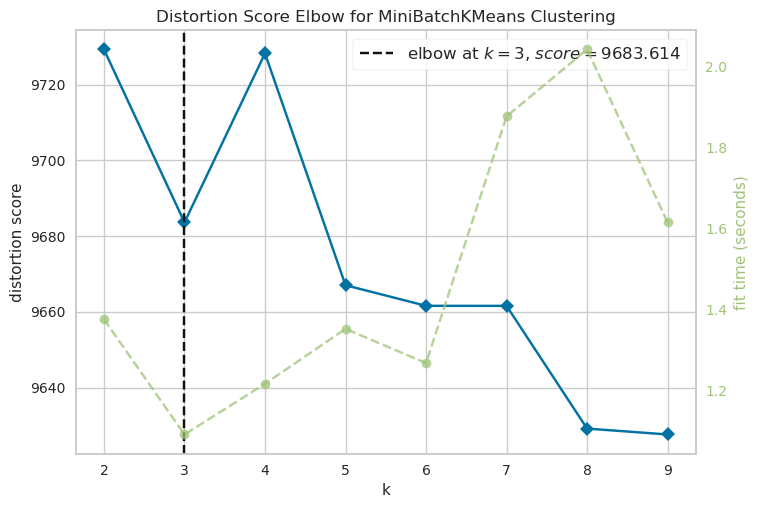

Optimal number of clusters: 3
Counter({1: 13757, 0: 2, 2: 1})
silhouette score of clustering: 0.14569956985445143


In [327]:
def spacy_lemmatizer_pos(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
                tokens.append(token.lemma_ + '_' + token.pos_)
    return tokens

def k_clustering(X):
    visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(2,10))
    visualizer.fit(X)
    visualizer.show()
    clusterNum = visualizer.elbow_value_  #to return optimal Cluster Numbers
    model =  MiniBatchKMeans(n_clusters=clusterNum).fit(X)
    pred_labels = model.labels_
    print('Optimal number of clusters:', clusterNum)
    print(Counter(pred_labels))
    sil_score = silhouette_score(X, pred_labels)
    return model, sil_score, pred_labels

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = spacy_lemmatizer_pos, max_features = 5000, ngram_range = (2,2))
X = tfidf_vectorizer.fit_transform(df_2['title'])
x_vect = pd.DataFrame(X.toarray(), columns= tfidf_vectorizer.get_feature_names())
bow_df = df_2.copy()
model, sil_score, pred_labels = k_clustering(x_vect)
print('silhouette score of clustering:', sil_score)
bow_df['labels'] = pred_labels

In [330]:
X2 = tfidf_vectorizer.transform(['What do you need to know about raising a series A?'])
new_cluster_label = model.predict(X2)[0]
cluster_docs = bow_df[bow_df['labels'] == new_cluster_label]
similarity_scores = cosine_similarity(X, X2)
results = pd.DataFrame({
    'title': df_2['title'],
    'category': df_2['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(5)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  "X does not have valid feature names, but"


title  \
2236                                 Everything you need to know about the NSA hack (but were afraid to Google)   
29283                                               What You Need To Know About The Liberator 3D-Printed Pistol   
5790                                     SeamlessDocs raises $7 million Series B to help governments go digital   
15520  Finnish BYOD Startup, Miradore, Raises €1.2 Million Series B, Backed By Inventure, For Global Sales Push   
15820                     Gridstore Raises $12.5 Million In Series A Financing For Grid-Based Scale-Out Storage   

         category  similarity  
2236     Startups    0.748560  
29283     Gadgets    0.748560  
5790        Cloud    0.663068  
15520  Enterprise    0.663068  
15820  Enterprise    0.663068

# WORD2VEC

In [331]:
word2vec_path = '../input/google-word2vec/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [332]:
word2vec.vector_size

300

In [333]:
vocab = set(word2vec.index_to_key)

# Word2Vec Before Stop Words Removal

In [335]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec:
            embeddings.append(word2vec[word])
        else:
            embeddings.append(np.zeros(word2vec.vector_size))
    
    return np.mean(embeddings, axis=0)
w2v_model_df = df_2.copy()
w2v_model_df['embeddings']= w2v_model_df['title'].apply(get_embeddings)

In [336]:
w2v_model_df

category  \
15955          Startups   
11668        Enterprise   
14904          Startups   
19308         Education   
6257   Advertising Tech   
...                 ...   
21918           Gadgets   
30774            Social   
37751          Startups   
25798            Europe   
11080           Gadgets   

                                                                                               title  \
15955                                        You’ve Only Got One Shot At Building A Consumer Unicorn   
11668                   Box Gets A Little More Palatable With Some Added Encryption From CipherCloud   
14904                               Pypestream Raises $2M To Help Businesses Talk To Their Customers   
19308  HealthKeep Launches An Anonymous Social Network To Let You Share And Track Health Information   
6257                                  Big Viking Games Acquires Mobile Marketing Startup Gallop Labs   
...                                                                                              ...   
21918                 BlackBerry Officially Unveils The Z3 “Jakarta Edition,” Its $200 Foxconn Phone   
30774                                                      Twitter Is Testing An Expandable Timeline   
37751                        Why Are Startups Flocking To SF? There’s No More Room In Silicon Valley   
25798                                                             Jamie Oliver Heats Up LeWeb London   
11080                                    The LightFreq Square2 Lets You Rock Out With Your Lights On   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    embeddings  
15955  [-0.025140380859375, 0.026416015625, 0.05211181640625, -0.0326904296875, 0.033319091796875, -0.047705078125, 0.03321533203125, -0.034893798828125, 0.1105224609375, 0.12496337890625, -0.054290771484375, -0.040985107421875, -0.0220947265625, -0.015960693359375, -0.065533447265625, -0.08773040771484375, 0.04859619140625, -0.042138671875, -0.0593017578125, 0.06871337890625, -0.0141204833984375, 0.08109893798828124, 0.121466064453125, -0.0170135498046875, -0.04503173828125, -0.0093170166015625, -0.144775390625, 0.0416015625, 0.1009765625, 0.0022705078125, -0.070355224609375, -0.07666015625, -0.0248748779296875, -0.121337890625, 0.023785400390625, 0.013128662109375, -0.026123046875, -0.00401611328125, -0.1337890625, 0.042041015625, -0.06064453125, -0.05186767578125, -0.06053466796875, 0.0824249267578125, 0.00215606689453125, -0.00612945556640625, -0.04659423828125, -0.02377166748046875, 0.0453369140625, 0.06517333984375, -0.2561614990234375, 0.0982177734375, 0.1265380859375, -0.003930664...  
11668  [0.016316731770833332, -0.0207366943359375, -0.068511962890625, 0.019307454427083332, -0.009867350260416666, 0.11686197916666667, -0.007760047912597656, 0.017913818359375, 0.062215169270833336, 0.15386962890625, 0.00293731689453125, -0.06913248697916667, -0.05224609375, 0.022816975911458332, -0.011617024739583334, -0.043116251627604164, 0.09546915690104167, 0.11417325337727864, -0.1483306884765625, 0.022211710611

In [338]:
X2 = get_embeddings(('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
4000                                         Tastemates helps you find people who like what you like   
3497                                                 How Drake can help you understand your business   
2236                      Everything you need to know about the NSA hack (but were afraid to Google)   
147                                                These chatbots want to help you manage your money   
7039                                                   You never forget the pain, so try to avoid it   
1282                                  Bumble is going to help you find your next job with BumbleBizz   
1017             If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
8724                      Wherefor lets you search for vacations based on how much you want to spend   
1599                 We learned from utilities everything we need to know about cloud infrastructure   
32     WristWhirl lets you control your smartwatch with hand gestures (and look mad while you do it)   
7949                          CHKN, letting you build and raise creatures, is betaworks’ latest game   
5363        Two new apps, Daycap and VideoSlam, help you create GIFs and videos to remember your day   
1403                                                                  So, does anybody want Twitter?   
2961     Google researchers teach AIs to see the important parts of images — and tell you about them   
5139                                          Why every household is about to get a brand-new fridge   
7835                              Entrepreneurs must learn to negotiate, or they can lose everything   
4131                                             PornHub launches BangFit so you can bang to get fit   
23344           Well, What Do You Know: The UK Prime Minister’s iPad ‘App’ Is Real. We Have Details.   
7                                      Speakable lets you take action on news articles that move you   
398                          Twitter can now alert you when someone you follow starts live streaming   

                      category  similarity  
4000                      Apps    0.800002  
3497                 eCommerce    0.790441  
2236                  Startups    0.780735  
147                     Europe    0.775258  
7039                  Startups    0.760126  
1282                      Apps    0.754082  
1017                   Gadgets    0.746976  
8724                  Startups    0.746742  
1599                     Cloud    0.735678  
32                     Gadgets    0.730204  
7949                    Gaming    0.704257  
5363                      Apps    0.704061  
1403                   Finance    0.699219  
2961   Artificial Intelligence    0.694526  
5139                   Gadgets    0.688632  
7835                  Startups    0.688058  
4131             Entertainment    0.684969  
23344                   Europe    0.682449  
7                         Apps    0.681878  
398                     Social    0.681775

As we can see the output is totally incorrect and irrelevant without removing stopwords

# Word2Vec after Stop Words removal

In [339]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.text.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

w2v_model_df['title_cleaned'] = w2v_model_df['title'].apply(simple_tokenize)

In [340]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec:
            embeddings.append(word2vec[word])
        else:
            embeddings.append(np.zeros(word2vec.vector_size))
    
    return np.mean(embeddings, axis=0)

w2v_model_df['embeddings']= w2v_model_df['title_cleaned'].apply(get_embeddings)

In [341]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
147                                                            These chatbots want to help you manage your money   
19704                             Ketchup Helps You Determine Which Friends Actually Want To Spend Time With You   
17098                                                        What You Need To Know To Get Started With Apple Pay   
23245  NEA-Backed CareZone Adds Shared Calendars, Goes Mobile To Help Families Better Care For Their Loved Ones    
14307                                                          MoID Wants To Help You Remember People You’ve Met   
7949                                      CHKN, letting you build and raise creatures, is betaworks’ latest game   
22796               Crazy-Stupid Or The Future? SoPost Wants To Turn Your Twitter Handle Into A Physical Address   
25299                                         Seedrs Goes Live To Help Crowdfund The Gap In Idea-Stage Investing   
34658                                         Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
36367                                     Y Combinator Interviews Start Tomorrow, Make Sure You Know YC Partners   
18660                              BoardProspects Wants To Help Companies ‘Build Better Boards’, Raises $650,000   
6862                                       Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
12529                        Why You’ll Hate the Apple Watch And The Important Business Lesson You Need To Learn   
30473                     Think Klout Is For Suckers? Flout.me Wants You To Set Your Own Social Influence Score.   
24312                                Fly6 Cycle Camera Lets Drivers Know It’s Watching Them So They Drive Better   
4622                                                   What Can We Call Blockchain To Help People Understand It?   
26456                                             Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   
1324            Rebecca Minkoff’s Fashion Week show uses augmented reality to help real women shop the look live   
1282                                              Bumble is going to help you find your next job with BumbleBizz   
4000                                                     Tastemates helps you find people who like what you like   

                category  similarity  
147               Europe    0.598325  
19704               Apps    0.577386  
17098          eCommerce    0.569984  
23245             Health    0.567482  
14307               Apps    0.563380  
7949              Gaming    0.562128  
22796             Europe    0.550611  
25299             Europe    0.542460  
34658   Fundings & Exits    0.541694  
36367           Startups    0.538302  
18660         Enterprise    0.537338  
6862          Enterprise    0.532967  
12529            Gadgets    0.530869  
30473             Social    0.529894  
24312            Gadgets    0.526440  
4622              Europe    0.525371  
26456            Gadgets    0.525098  
1324   Augmented Reality    0.523821  
1282                Apps    0.522979  
4000                Apps    0.522698

The output isn't satisfactory because we see a lot of irrelevant documents in here too. Except for a few documents which have '$' or the keyword 'raises' in them.

# Word2Vec after Stop Words Removal AND Lemmatization

In [342]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.lemma_.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

w2v_model_df['title_cleaned'] = w2v_model_df['title'].apply(simple_tokenize)

In [343]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec:
            embeddings.append(word2vec[word])
        else:
            embeddings.append(np.zeros(word2vec.vector_size))
    
    return np.mean(embeddings, axis=0)

w2v_model_df['embeddings']= w2v_model_df['title_cleaned'].apply(get_embeddings)

In [344]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14307                                                          MoID Wants To Help You Remember People You’ve Met   
18660                              BoardProspects Wants To Help Companies ‘Build Better Boards’, Raises $650,000   
17098                                                        What You Need To Know To Get Started With Apple Pay   
19704                             Ketchup Helps You Determine Which Friends Actually Want To Spend Time With You   
23245  NEA-Backed CareZone Adds Shared Calendars, Goes Mobile To Help Families Better Care For Their Loved Ones    
147                                                            These chatbots want to help you manage your money   
22796               Crazy-Stupid Or The Future? SoPost Wants To Turn Your Twitter Handle Into A Physical Address   
16537                                                                 Spotify Wants To Be Everything To Everyone   
729                              Bumble is finally monetizing with paid features to better help you find a match   
20245                                                              How Many Languages Your Startup Needs To Know   
14474                             Convercent Raises $10.2M To Help Companies Promote The Good And Manage The Bad   
34658                                         Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
28102                                                             Check-In Needs To Work, But How Can We Fix It?   
7949                                      CHKN, letting you build and raise creatures, is betaworks’ latest game   
38370                           Deliver The Love With Mmmule: Let Strangers Carry Things To Other Places For You   
3922                                      Money Intel Wants To Help Companies Quickly Set Up And Manage A 401(k)   
4622                                                   What Can We Call Blockchain To Help People Understand It?   
1324            Rebecca Minkoff’s Fashion Week show uses augmented reality to help real women shop the look live   
4000                                                     Tastemates helps you find people who like what you like   
25299                                         Seedrs Goes Live To Help Crowdfund The Gap In Idea-Stage Investing   

                category  similarity  
14307               Apps    0.691286  
18660         Enterprise    0.672840  
17098          eCommerce    0.634490  
19704               Apps    0.624322  
23245             Health    0.619997  
147               Europe    0.619134  
22796             Europe    0.607753  
16537      Entertainment    0.601791  
729                 Apps    0.598650  
20245           Startups    0.598270  
14474         Enterprise    0.594360  
34658   Fundings & Exits    0.593071  
28102               Apps    0.592241  
7949              Gaming    0.591893  
38370           Startups    0.586549  
3922                Apps    0.582768  
4622              Europe    0.582333  
1324   Augmented Reality    0.581522  
4000                Apps    0.580362  
25299             Europe    0.572638

Surprisingly word2vec with lemmatization for this phrase isnt producing good results. We can see a lot of irrelevant documents that have "raise" keyword or text with similar semantics but nothing about Series A.

In [345]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                                    How and why to pitch angel groups   
17696                                                 Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
37388                                        Crane & Canopy Is Bringing Internet Business Models To The Home Goods Market   
15890                                         Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
22608                                                          Google’s Environment Sensing Project Tango Gets A Teardown   
22733                                              Live From TechCrunch Moscow — 44 Companies Pitch At #TCMoscow Demo Day   
34625                                                           Boatbound Launches ‘Pier-To-Pier’ Boat Rental Marketplace   
35230          With 500K Downloads, Haiku Deck Raises $3M Series A For Its Unique, Mobile-First Presentation Creation App   
14615                             Just Eat IPO Values It At $2.44BN, Company First To Test LSE’s New Tech-Friendly Market   
12522                                                      iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
14500                                   Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
33424                                             Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
2542                                                      TechCrunch Pitch-Off Stockholm applications are open right now!   
9262                                               These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
32665                                    SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
34758  60+ Investors Band Together To Form BitAngels, The First Multi-City Angel Network & Incubator For Bitcoin Startups   
26827                           Tiger, SV Angel-Backed Baby.com.br Finds Legs In An Exploding Brazilian eCommerce Market    
18459                                                PlanGrid Builds A New Market For The iPad: The Construction Industry   
10429                                        The “Oculus Platform” Marketplace For Virtual Reality App Launches This Fall   
1960                                Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   

               category  similarity  
8287           Startups    0.568167  
17696            Mobile    0.533251  
37388         eCommerce    0.519847  
15890           Gadgets    0.513271  
22608           Gadgets    0.509441  
22733            Europe    0.501163  
34625  Fundings & Exits    0.499500  
35230            Mobile    0.496053  
14615            Europe    0.493894  
12522           Gadgets    0.493193  
14500  Advertising Tech    0.491497  
33424          Startups    0.491330  
2542             Europe    0.490604  
9262               Apps    0.490024  
32665          Startups    0.485992  
34758         eCommerce    0.481184  
26827         eCommerce    0.480846  
18459              Apps    0.480571  
10429              Apps    0.477979  
1960   Fundings & Exits    0.476663

Again in my opinion the results are still not satisfactory here with another phrase.

# Word2Vec after Stop Words Removal AND STEMMING

In [346]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

w2v_model_df['title_cleaned'] = w2v_model_df['title'].apply(simple_tokenize)

In [347]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec:
            embeddings.append(word2vec[word])
        else:
            embeddings.append(np.zeros(word2vec.vector_size))
    
    return np.mean(embeddings, axis=0)

w2v_model_df['embeddings']= w2v_model_df['title_cleaned'].apply(get_embeddings)

In [348]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
39034                                          BabyNotify: You Know, For Notifying People When Your Baby Comes   
24363                 DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
7839                                                               Stae wants to prepare cities for the future   
17869  Plenummedia Raises $6.5M To Help SMEs In Spain And LatAm Do Business Online, More Acquisitions Expected   
2236                                Everything you need to know about the NSA hack (but were afraid to Google)   
21753          NewHive Lets You Hack Together Any Media Into A Website Collage. 10M Views Let It Raise Funding   
4450                    Apple tells NY judge FBI has ‘utterly failed’ to prove it needs help unlocking iPhones   
17098                                                      What You Need To Know To Get Started With Apple Pay   
7590                             Bigcommerce Raises $50M Series D From SoftBank, Telstra, And American Express   
12250    Forrester Says The Chromebook’s Time Has Arrived In The Enterprise, But Security Is The Nagging Issue   
8756                                                            Source: Rackspace Wants To Take Itself Private   
3319                            At GitHub You Don’t Need No Stinkin’ Office, But There Is A Nice One If You Do   
7012                                       Babbel Raises $22M Series C Round For Its Language Learning Service   
12255                       LinkedIn Raises Its Game In Infographics And Analytics With New SlideShare Upgrade   
12529                      Why You’ll Hate the Apple Watch And The Important Business Lesson You Need To Learn   
4855                                                           Readbug Wants To Be Spotify For Indie Magazines   
1868                  Hibob raises $7.5M to help SMEs manage their people (and those pesky workplace pensions)   
9756    LeanData Raises $5.1M In Series A From Shasta Ventures To Help Customers Make Sense Of Salesforce Data   
31315                 Meet Appidemia, A Beautiful Application Guide For iOS In Case You Need More Distractions   
18655                                     Samsung Level Headphone Series Review: Galaxy Owners Only Need Apply   

         category  similarity  
39034    Startups    0.680132  
24363    Startups    0.658962  
7839   Government    0.654545  
17869      Europe    0.653724  
2236     Startups    0.628063  
21753    Startups    0.627472  
4450      Gadgets    0.620828  
17098   eCommerce    0.616913  
7590         Asia    0.611098  
12250  Enterprise    0.610308  
8756   Enterprise    0.608388  
3319    Developer    0.606225  
7012    Education    0.605999  
12255  Enterprise    0.605482  
12529     Gadgets    0.605033  
4855         Apps    0.603325  
1868       Europe    0.603047  
9756   Enterprise    0.602207  
31315        Apps    0.601604  
18655     Gadgets    0.600547

Stemming seems to produce the best results for this sentence. We see more documents with Series A and Raises keywords as compared to what we saw with Lemmatization

In [349]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(w2v_model_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': w2v_model_df['title'],
    'category': w2v_model_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                How and why to pitch angel groups   
17696                             Alpine Ships A New 7″ CarPlay-Capable Deck, But It’ll Cost You $800   
12522                                  iFixit Apple Watch Teardown Suggests No Internal Chip Upgrades   
32665                SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
14500               Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
922                                    Legion Analytics is building bots to automate your sales pitch   
33424                         Haiku Deck Launches, Brings Upstart Software To Us, On All Our Desktops   
2542                                  TechCrunch Pitch-Off Stockholm applications are open right now!   
1860                                                 Are you ready for Pitch Roulette at The Europas?   
1960            Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   
33678                 The Boston Meetup + Pitch-Off Is In One Month, Apply Now To Be In The Pitch-Off   
15890                     Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
2313                       This is your last chance to apply to the TechCrunch Pitch-Off in Stockholm   
8797                          Everywear Games Is A New Finnish Startup Building Games For Apple Watch   
31052  Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
7664                                                      Game Of Angels Maps Tech Influence Networks   
28084               Apple Reportedly Ramping Up For New iPad Mini With Retina Display Later This Year   
22733                          Live From TechCrunch Moscow — 44 Companies Pitch At #TCMoscow Demo Day   
15281                                           Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                       Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   

               category  similarity  
8287           Startups    0.583213  
17696            Mobile    0.576227  
12522           Gadgets    0.529512  
32665          Startups    0.518504  
14500  Advertising Tech    0.510176  
922          Enterprise    0.500182  
33424          Startups    0.494921  
2542             Europe    0.493798  
1860             Europe    0.492401  
1960   Fundings & Exits    0.492122  
33678          Startups    0.489734  
15890           Gadgets    0.485530  
2313             Europe    0.482474  
8797             Europe    0.477712  
31052            Social    0.476137  
7664             Social    0.474386  
28084           Gadgets    0.466878  
22733            Europe    0.465681  
15281          Startups    0.464299  
14045          Startups    0.464299

In [350]:
print("Word2Vec: ", word2vec.most_similar(positive=['Apple', 'Android'], negative=['Google'], topn=10))

Word2Vec:  [('iPhone', 0.6760427355766296), ('Android_OS', 0.6658218502998352), ('iOS', 0.6550344228744507), ('WP7', 0.6534616947174072), ('iPhone_OS', 0.6471943855285645), ('Windows_Phone_7', 0.6360811591148376), ('Google_Android', 0.6267580389976501), ('Droid_X', 0.6261382699012756), ('Android_Honeycomb', 0.6242284774780273), ('WebOS', 0.6227046847343445)]


# Winner Model Word2Vec

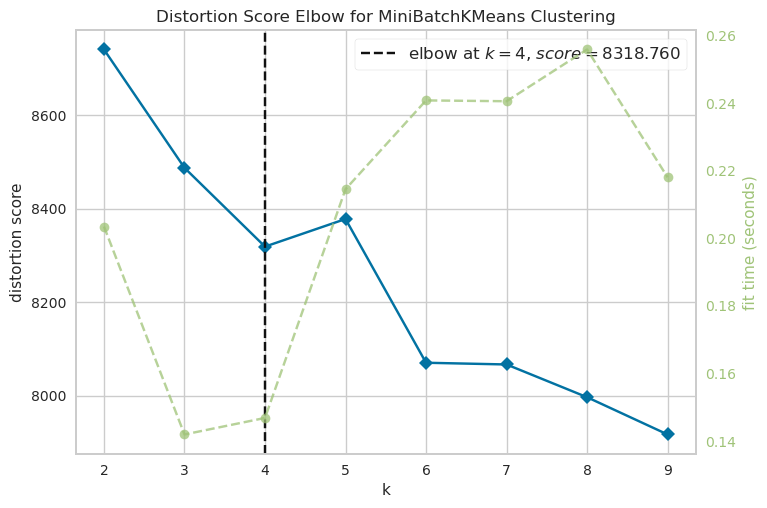

Optimal number of clusters: 4
Counter({2: 5876, 1: 3527, 3: 2697, 0: 1660})
silhouette score of clustering: -0.02577133027857824


In [352]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in word2vec:
            embeddings.append(word2vec[word])
        else:
            embeddings.append(np.zeros(word2vec.vector_size))
    
    return np.mean(embeddings, axis=0)

def k_clustering(X):
    visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(2,10))
    visualizer.fit(X)
    visualizer.show()
    clusterNum = visualizer.elbow_value_  #to return optimal Cluster Numbers
    model =  MiniBatchKMeans(n_clusters=clusterNum).fit(X)
    pred_labels = model.labels_
    print('Optimal number of clusters:', clusterNum)
    print(Counter(pred_labels))
    sil_score = silhouette_score(X, pred_labels)
    return model, sil_score, pred_labels

w2v_model_df = df_2.copy()
w2v_model_df['title_cleaned'] = w2v_model_df['title'].apply(simple_tokenize)
w2v_model_df['embeddings']= w2v_model_df['title_cleaned'].apply(get_embeddings)
X = np.vstack(w2v_model_df['embeddings'].values)
model, sil_score, pred_labels = k_clustering(X)
print('silhouette score of clustering:', sil_score)
w2v_model_df['labels'] = pred_labels

In [355]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1,-1)
new_cluster_label = model.predict(X2)[0]
cluster_docs = w2v_model_df[w2v_model_df['labels'] == new_cluster_label]
sentence_emb_array = np.stack(cluster_docs['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': cluster_docs['title'],
    'category': cluster_docs['category'],
    'labels': cluster_docs['labels'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(5)

title  \
39034                           BabyNotify: You Know, For Notifying People When Your Baby Comes   
24363  DoorDash Comes To San Francisco, Because Lord Knows We Need Another Food Delivery Option   
2236                 Everything you need to know about the NSA hack (but were afraid to Google)   
4450     Apple tells NY judge FBI has ‘utterly failed’ to prove it needs help unlocking iPhones   
17098                                       What You Need To Know To Get Started With Apple Pay   

        category  labels  similarity  
39034   Startups       2    0.680132  
24363   Startups       2    0.658962  
2236    Startups       2    0.628063  
4450     Gadgets       2    0.620828  
17098  eCommerce       2    0.616913

# GLOVE

In [351]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_input_file = '/kaggle/input/glove6b/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file,word2vec_output_file)
modelg = KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  """


In [ ]:
print("Glove: ", modelg.most_similar(positive=['Apple', 'Android'], negative=['Google'], topn=10))

# GLOVE Before Stop Words Removal

In [356]:
def get_embeddings(text):
    embeddings = []
    text = text.lower()
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)
glove_df = df_2.copy()
glove_df['embeddings']= glove_df['title'].apply(get_embeddings)

In [358]:
X2 = get_embeddings(('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
25538                                               What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   
17098                                                                What You Need To Know To Get Started With Apple Pay   
22470                                           Think You’ve Got What It Takes To Be A Tech Entrepreneur? Take My Advice   
23756                        Powervoice Pivots: No Longer Pays You To Post About Brands (It Wants You To Do So For Free)   
29427                                     Level Helps You Mind Your Money With Apps, Nabs $5M Series A To Make It Happen   
7535                                                           Here’s What You Need To Know From Microsoft’s Cloud Event   
24763  Uber’s Travis Kalanick On Regulators: You Have To Grit Your Teeth, Be A Warrior, Or Do Something Less Disruptive    
1017                                 If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
3319                                      At GitHub You Don’t Need No Stinkin’ Office, But There Is A Nice One If You Do   
2236                                          Everything you need to know about the NSA hack (but were afraid to Google)   
23433                                                      Do We Need Another Angel List? NOAH Insider Seems To Think So   
28713                                                              A $100 Watch Can Tell If You’ve Had Too Much To Drink   
12529                                Why You’ll Hate the Apple Watch And The Important Business Lesson You Need To Learn   
39040                                                         Clear: Why This Simple To Do List App Has Everyone Talking   
22220        Darjeelin Wants To Help You Get A Cheaper Flight By Employing The Crowd To Do Your ‘Flight Hacking’ For You   
27666                                                                             This Is Why You Don’t Need A New Phone   
29283                                                        What You Need To Know About The Liberator 3D-Printed Pistol   
6862                                               Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
25165                            Threes Comes To Android, And I’m Not Just Using This To Tell You My Top Score Is 10,125   
34658                                                 Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   

               category  similarity  
25538            Europe    0.977496  
17098         eCommerce    0.973570  
22470            Europe    0.971506  
23756            Social    0.971463  
29427              Apps    0.970890  
7535         Enterprise    0.970452  
24763        Government    0.968285  
1017            Gadgets    0.968154  
3319          Developer    0.968078  
2236           Startups    0.967914  
23433            Europe    0.967773  
28713           Gadgets    0.967426  
12529           Gadgets    0.967212  
39040              Apps    0.966128  
22220            Europe    0.966069  
27666           Gadgets    0.965764  
29283           Gadgets    0.965686  
6862         Enterprise    0.965420  
25165            Gaming    0.964807  
34658  Fundings & Exits    0.964389

As we can see the output is totally incorrect and irrelevant without removing stopwords

# GLOVE after Stop Words removal AND STEMMING

In [359]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

glove_df['title_cleaned']= glove_df['title'].apply(simple_tokenize)

In [361]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)

glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)

In [362]:
X2 = get_embeddings(('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
15476                                                                     Separate.Us Wants To Bring Divorce Online   
26456                                                Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   
33622  Can You Click Your Way To Happiness? New Self-Help Service For The Stressed & Sad, Happify, Makes Big Claims   
25538                                          What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   
36880                              HowAboutWe Provides Hand-Picked Date Ideas To Help Couples Fall And Stay In Love   
35719                         The Weekly Good: This Analytics Company Wants To Help Put An End To Human Trafficking   
33338         Wisely Helps You Find Where To Shop Or Eat Based On Real Consumer Spending Patterns, Not User Reviews   
19704                                Ketchup Helps You Determine Which Friends Actually Want To Spend Time With You   
28102                                                                Check-In Needs To Work, But How Can We Fix It?   
18162                                                        Need A New Name For Your Website? Why Not NameStation?   
10527                    Watch Out Google, AddSearch — Like Swiftype — Wants To Stop In-Website Search From Sucking   
506                                           Camarilla, like Path but better, lets you share with up to 15 friends   
38958                                                Want A Job? Interview Street Is Holding CodeSprints Every Week   
7550                                                      Swarm 2.3 Feels Like The Old Foursquare, Looks Way Better   
1017                            If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
18279                                          YouLike Is A Dating Site That Thinks The Key To Finding Love Is Hate   
4167                            SocialRank Helps You Understand Your Followers — And Now It’s Getting Collaborative   
8331                                                                     If You Think Big Data’s Big Now, Just Wait   
18297                          WePopp Wants To Cut Down On The Back And Forth When Planning Nights Out With Friends   
7742                          Google Voice Search Gets Smarter, Now Understands Complex Questions And Their Meaning   

         category  similarity  
15476    Startups    0.944291  
26456     Gadgets    0.942315  
33622    Startups    0.940409  
25538      Europe    0.935707  
36880    Startups    0.932777  
35719   Education    0.932769  
33338        Apps    0.932340  
19704        Apps    0.931804  
28102        Apps    0.931435  
18162  Enterprise    0.930904  
10527  Enterprise    0.930062  
506          Apps    0.929028  
38958    Startups    0.928653  
7550         Apps    0.928616  
1017      Gadgets    0.927101  
18279      Europe    0.926992  
4167       Social    0.926693  
8331   Enterprise    0.926647  
18297        Apps    0.926412  
7742       Mobile    0.926170

The output is very irrelevant so we will give another try with another sentence.

In [363]:
X2 = get_embeddings(('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                                How and why to pitch angel groups   
4583                                                 ISS beams down 4K footage of Earth shot with the RED Epic Dragon   
32665                                SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
3321                                                                               Here’s What Is Next For Windows 10   
38250                           GroundLink Car Service Platform Tackles Its Biggest Obstacle Yet: Los Angeles Traffic   
22624                                                                                               Shots In The Dark   
10899                                   Anki Will Ship The Second Generation Of Its Robotic Slot Cars On September 20   
7766                                                                                     A Few Thoughts On Windows 10   
6047                                                                          iPhone 7 Could Have A Flush Rear Camera   
28854                The Deep Space Tourbillon Is A One-Off, Handmade Watch That Will Take You To Infinity And Beyond   
37660          With Added Backing From Alexis Ohanian, Harj Taggar, Garry Tan & SV Angel, Quarterly Reopens Its Doors   
17527                                                                      Instagram, Technology’s Window To The Soul   
14813                                                                                     What Los Angeles Is Missing   
1704                         Windows Ink, Cortana improvements and more arrive in the latest Windows 10 build out now   
29484                                                  Cameo Shoots For The Sweet Spot In The Crowded Video App Space   
36570  Squarespace, Fog Creek, Peer1 Kept NY Data Center Alive By Carrying Fuel Buckets To The 17th Floor In The Dark   
37033                                              Startup Alley Day 2 — From Mixer To Murally To Floost And The Rest   
38193                         Backed By Angels, SiteSimon Launches To Turn Your Browser Into An Intelligent Assistant   
296                                                                              Box introduces “New Box” at BoxWorks   
4265                                                                              Say Hello To Windows 10 Build 10532   

               category  similarity  
8287           Startups    0.678587  
4583            Gadgets    0.662960  
32665          Startups    0.635105  
3321         Enterprise    0.632181  
38250          Startups    0.624750  
22624           Opinion    0.618788  
10899           Gadgets    0.616277  
7766         Enterprise    0.607597  
6047            Gadgets    0.607183  
28854           Gadgets    0.606074  
37660  Fundings & Exits    0.601397  
17527           Opinion    0.598663  
14813          Startups    0.598510  
1704         Enterprise    0.596384  
29484              Apps    0.594933  
36570          Startups    0.594225  
37033          Startups    0.592883  
38193  Fundings & Exits    0.592726  
296               Cloud    0.592189  
4265               Apps    0.591132

We can see outputs are somewhat relevant but have high similarity scores. 

# GLOVE after Stop Words Removal AND Lemmatization

In [364]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.lemma_.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

glove_df['title_cleaned']= glove_df['title'].apply(simple_tokenize)

In [365]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)
glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)

In [366]:
X2 = get_embeddings(('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
19704                                Ketchup Helps You Determine Which Friends Actually Want To Spend Time With You   
25538                                          What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   
33622  Can You Click Your Way To Happiness? New Self-Help Service For The Stressed & Sad, Happify, Makes Big Claims   
22796                  Crazy-Stupid Or The Future? SoPost Wants To Turn Your Twitter Handle Into A Physical Address   
28102                                                                Check-In Needs To Work, But How Can We Fix It?   
38370                              Deliver The Love With Mmmule: Let Strangers Carry Things To Other Places For You   
4000                                                        Tastemates helps you find people who like what you like   
25347                            GoalHawk Helps You Get Fit And Learn To Code, With A Little Help From Your Friends   
36880                              HowAboutWe Provides Hand-Picked Date Ideas To Help Couples Fall And Stay In Love   
25547                       Hey, Wikipedia Spammers, Start Getting Worried — Datasift Has Built A Tool To Track You   
1017                            If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
8331                                                                     If You Think Big Data’s Big Now, Just Wait   
20560                   Let’s Date Adds A ‘Wingman’ Feature For People Who Just Want To Recommend Dates For Friends   
17098                                                           What You Need To Know To Get Started With Apple Pay   
26456                                                Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   
10084                           Bill Gates Explains His New Role At Microsoft, Says Nadella Asked Him To “Pitch In”   
39034                                               BabyNotify: You Know, For Notifying People When Your Baby Comes   
7949                                         CHKN, letting you build and raise creatures, is betaworks’ latest game   
23245     NEA-Backed CareZone Adds Shared Calendars, Goes Mobile To Help Families Better Care For Their Loved Ones    
12723                       PSA: Sorry, Those Apple Watch Band Swapping Sites Aren’t Going To Work Like You Thought   

         category  similarity  
19704        Apps    0.937845  
25538      Europe    0.935707  
33622    Startups    0.932900  
22796      Europe    0.932635  
28102        Apps    0.931435  
38370    Startups    0.931229  
4000         Apps    0.929932  
25347      Social    0.929751  
36880    Startups    0.928167  
25547      Europe    0.927241  
1017      Gadgets    0.927101  
8331   Enterprise    0.926647  
20560      Mobile    0.926140  
17098   eCommerce    0.925969  
26456     Gadgets    0.925777  
10084  Enterprise    0.923995  
39034    Startups    0.923920  
7949       Gaming    0.923745  
23245      Health    0.923292  
12723     Gadgets    0.922971

Glove with lemmatization isnt producing good results. We can see a lot of irrelevant documents that do not have "raise" keyword or text with similar semantics and nothing about Series A.

In [367]:
X2 = get_embeddings(('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                                                How and why to pitch angel groups   
4583                                                 ISS beams down 4K footage of Earth shot with the RED Epic Dragon   
22624                                                                                               Shots In The Dark   
28854                The Deep Space Tourbillon Is A One-Off, Handmade Watch That Will Take You To Infinity And Beyond   
23046                                               iPhone 6 “Air” Concept Imagines A Return To The Glass Back Design   
32665                                SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
10273                                                           New ATM “Shimmer” Fits Invisibly Inside The Card Slot   
29484                                                  Cameo Shoots For The Sweet Spot In The Crowded Video App Space   
36570  Squarespace, Fog Creek, Peer1 Kept NY Data Center Alive By Carrying Fuel Buckets To The 17th Floor In The Dark   
20026            Big Moment For Vine As First Wolverine Movie Footage Comes Via 6-Second “Tweaser” Instead Of Trailer   
11584                       DotCloud Pivots And Wins Big With Docker, The Cloud Service Now Part Of Red Hat OpenShift   
18030                    Oculus Reveals Its New “Crescent Bay” Prototype With 360-Degree Head Tracking And Headphones   
6621                                       Misfit Debuts Spector, “Smart” Headphones That Double As A Fitness Tracker   
14546                                                                                 The “Shark Tank” Effect On Apps   
126                                    Tile introduces a thinner, lighter version of its Bluetooth tracker, Tile Mate   
36174                                                             OpenArch Adds A “Digital Layer” To The Average Room   
9750                                           Microsoft Reportedly Will Rebrand “Windows Azure” To “Microsoft Azure”   
3185                                        Amazon’s Kindle gets a thinner and lighter design sporting double the RAM   
13061                                                            Mobile Platforms, Smartwatches, And Golden Handcuffs   
296                                                                              Box introduces “New Box” at BoxWorks   

            category  similarity  
8287        Startups    0.678587  
4583         Gadgets    0.656348  
22624        Opinion    0.618788  
28854        Gadgets    0.616392  
23046        Gadgets    0.602793  
32665       Startups    0.601978  
10273         Mobile    0.601056  
29484           Apps    0.599973  
36570       Startups    0.592191  
20026         Social    0.590337  
11584     Enterprise    0.586255  
18030  Entertainment    0.581609  
6621         Gadgets    0.580301  
14546           Apps    0.579769  
126          Gadgets    0.578723  
36174        Gadgets    0.577580  
9750      Enterprise    0.576005  
3185         Gadgets    0.574190  
13061           Apps    0.570805  
296            Cloud    0.570547

Again in my opinion the results are still not satisfactory here with another phrase.

# GLOVE WITH 300 DIMENSIONS

In [36]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_input_file = '/kaggle/input/glove6b/glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file,word2vec_output_file)
modelg = KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  """


In [369]:
print("Word2Vec: ", word2vec.most_similar(positive=['Apple', 'Android'], negative=['Google'], topn=10))

Word2Vec:  [('iPhone', 0.6760427355766296), ('Android_OS', 0.6658218502998352), ('iOS', 0.6550344228744507), ('WP7', 0.6534616947174072), ('iPhone_OS', 0.6471943855285645), ('Windows_Phone_7', 0.6360811591148376), ('Google_Android', 0.6267580389976501), ('Droid_X', 0.6261382699012756), ('Android_Honeycomb', 0.6242284774780273), ('WebOS', 0.6227046847343445)]


# GLOVE Before Stop Words Removal

In [370]:
def get_embeddings(text):
    embeddings = []
    text = text.lower()
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)

glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)

In [371]:
X2 = get_embeddings(('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                               How and why to pitch angel groups   
32665               SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
1860                                                Are you ready for Pitch Roulette at The Europas?   
37244                                     Does Your Startup Pitch Suck? Call PitchPhone And Practice   
14500              Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
10273                                          New ATM “Shimmer” Fits Invisibly Inside The Card Slot   
20921                                     Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
4583                                ISS beams down 4K footage of Earth shot with the RED Epic Dragon   
12791                                                                           The Art Of The Pitch   
9262                          These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
14360      Trellie Is Launching A Smart Jewelry “Starter Kit” This Spring With Dozens Of Accessories   
30206                              The Seattle Pitch-Off Is Tomorrow, So Hurry Up And Grab Tickets!    
3399                           Dish ships the HopperGo, a tiny little cloud player for TV on the run   
36174                                            OpenArch Adds A “Digital Layer” To The Average Room   
15701                                                Sony Outs Clip-On Smart Glass Module For Sports   
23046                              iPhone 6 “Air” Concept Imagines A Return To The Glass Back Design   
16354  Panono Spherical Camera Passes $1M On Indiegogo To Turn Panorama Photography Into A Ball Game   
33489                                                                    Pitch-Off. Tonight. Boston.   
18586            Facebook Must Make Home A Layer Atop Your Widgets And Homescreen, Not A Replacement   
1960           Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   

               category  similarity  
8287           Startups    0.591407  
32665          Startups    0.511917  
1860             Europe    0.437932  
37244          Startups    0.433311  
14500  Advertising Tech    0.431729  
10273            Mobile    0.431307  
20921          Startups    0.418820  
4583            Gadgets    0.416813  
12791          Startups    0.408002  
9262               Apps    0.406627  
14360           Gadgets    0.392296  
30206          Startups    0.391517  
3399            Gadgets    0.385871  
36174           Gadgets    0.376567  
15701           Gadgets    0.373527  
23046           Gadgets    0.372104  
16354            Europe    0.370949  
33489          Startups    0.370582  
18586              Apps    0.370060  
1960   Fundings & Exits    0.370058

As we can see the output can be improved after removing stopwords

# GLOVE after Stop Words removal AND LEMMATIZATION

In [388]:
stop_words = nlp.Defaults.stop_words

def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop]
    return ' '.join(tokens)

glove_df['title_cleaned']= glove_df['title'].apply(simple_tokenize)

In [389]:
def get_embeddings(text):
    embeddings = []
    text = text.lower()
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)

glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)

In [390]:
X2 = get_embeddings(('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
25538                                          What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   
4622                                                      What Can We Call Blockchain To Help People Understand It?   
33622  Can You Click Your Way To Happiness? New Self-Help Service For The Stressed & Sad, Happify, Makes Big Claims   
19704                                Ketchup Helps You Determine Which Friends Actually Want To Spend Time With You   
14307                                                             MoID Wants To Help You Remember People You’ve Met   
18162                                                        Need A New Name For Your Website? Why Not NameStation?   
22796                  Crazy-Stupid Or The Future? SoPost Wants To Turn Your Twitter Handle Into A Physical Address   
17098                                                           What You Need To Know To Get Started With Apple Pay   
39034                                               BabyNotify: You Know, For Notifying People When Your Baby Comes   
4000                                                        Tastemates helps you find people who like what you like   
28102                                                                Check-In Needs To Work, But How Can We Fix It?   
38370                              Deliver The Love With Mmmule: Let Strangers Carry Things To Other Places For You   
26456                                                Nexus 5 Launch Likely Coming Today, Here’s What We Know So Far   
1017                            If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
25347                            GoalHawk Helps You Get Fit And Learn To Code, With A Little Help From Your Friends   
7949                                         CHKN, letting you build and raise creatures, is betaworks’ latest game   
37857                                   By Keeping It All Online, Moveline Helps Out Big-Time During Your Next Move   
38958                                                Want A Job? Interview Street Is Holding CodeSprints Every Week   
25383  Fits.me Finally Shipping A New Robot That Makes It Easier To See What You’re Going To Look Like In That Suit   
12723                       PSA: Sorry, Those Apple Watch Band Swapping Sites Aren’t Going To Work Like You Thought   

         category  similarity  
25538      Europe    0.873281  
4622       Europe    0.869539  
33622    Startups    0.867585  
19704        Apps    0.862323  
14307        Apps    0.861092  
18162  Enterprise    0.860522  
22796      Europe    0.859654  
17098   eCommerce    0.858497  
39034    Startups    0.858222  
4000         Apps    0.850388  
28102        Apps    0.848653  
38370    Startups    0.847912  
26456     Gadgets    0.843040  
1017      Gadgets    0.841311  
25347      Social    0.840794  
7949       Gaming    0.838866  
37857        Apps    0.838023  
38958    Startups    0.837857  
25383      Europe    0.835908  
12723     Gadgets    0.835520

The output is very irrelevant so we will give another try with another sentence.

In [391]:
X2 = get_embeddings(('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                               How and why to pitch angel groups   
32665               SketchDeck Turns Terrible Slide Decks Into Beautiful Presentations In Just A Day   
1860                                                Are you ready for Pitch Roulette at The Europas?   
37244                                     Does Your Startup Pitch Suck? Call PitchPhone And Practice   
14500              Leaked Facebook Video Ad Pitch Deck Reveals Plans To Steal TV And YouTube Dollars   
10273                                          New ATM “Shimmer” Fits Invisibly Inside The Card Slot   
20921                                     Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
4583                                ISS beams down 4K footage of Earth shot with the RED Epic Dragon   
12791                                                                           The Art Of The Pitch   
9262                          These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
14360      Trellie Is Launching A Smart Jewelry “Starter Kit” This Spring With Dozens Of Accessories   
30206                              The Seattle Pitch-Off Is Tomorrow, So Hurry Up And Grab Tickets!    
3399                           Dish ships the HopperGo, a tiny little cloud player for TV on the run   
36174                                            OpenArch Adds A “Digital Layer” To The Average Room   
15701                                                Sony Outs Clip-On Smart Glass Module For Sports   
23046                              iPhone 6 “Air” Concept Imagines A Return To The Glass Back Design   
16354  Panono Spherical Camera Passes $1M On Indiegogo To Turn Panorama Photography Into A Ball Game   
33489                                                                    Pitch-Off. Tonight. Boston.   
18586            Facebook Must Make Home A Layer Atop Your Widgets And Homescreen, Not A Replacement   
1960           Snapchat raised $1.8B in a Series F round; leaked deck reveals revenues, user numbers   

               category  similarity  
8287           Startups    0.591407  
32665          Startups    0.511917  
1860             Europe    0.437932  
37244          Startups    0.433311  
14500  Advertising Tech    0.431729  
10273            Mobile    0.431307  
20921          Startups    0.418820  
4583            Gadgets    0.416813  
12791          Startups    0.408002  
9262               Apps    0.406627  
14360           Gadgets    0.392296  
30206          Startups    0.391517  
3399            Gadgets    0.385871  
36174           Gadgets    0.376567  
15701           Gadgets    0.373527  
23046           Gadgets    0.372104  
16354            Europe    0.370949  
33489          Startups    0.370582  
18586              Apps    0.370060  
1960   Fundings & Exits    0.370058

We can see outputs are somewhat relevant but have low similarity scores. 

# GLOVE after Stop Words Removal AND STEMMING

In [385]:
stop_words = nlp.Defaults.stop_words

def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [stemmer.stem(token.text.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)
glove_df = df_2.copy()
glove_df['title_cleaned']= glove_df['title'].apply(simple_tokenize)

In [386]:
def get_embeddings(text):
    embeddings = []
    text = text.lower()
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)

glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)

In [173]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(glove_df['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': glove_df['title'],
    'category': glove_df['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
10237                    Online Grocery Store Redmart Raises Series A Round To Stay Put In Singapore   
399                                           French online restaurant FoodChéri raises €6M Series A   
26061                  RealScout Raises $6 Million Series A For Better Real Estate Search Technology   
37942                       Wibbitz Raises $2.3M Series A For Technology That Turns Text Into Videos   
19939         Etece, A Spanish TaskRabbit, Raises €450K Series A To Expand To Four More Local Cities   
34658                             Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
18660                  BoardProspects Wants To Help Companies ‘Build Better Boards’, Raises $650,000   
28474                                                GoGoVan Raises $6.5M Series A To Expand In Asia   
17942                             Coupa Raises $22 Million Series E To Help Companies Track Spending   
6211                                            Privacy Concerns Raised Over Kids’ Apps And Websites   
14524                     17hats Raises $4M Series A To Help Solo Entrepreneurs Run Their Businesses   
38129  Simplee Raises $6 Million Series A For Its Mint-Like Approach To Tracking Healthcare Expenses   
17372                              Dinner Lab Raises A $7M Series A To Expand Its Social Dining Club   
18837                         Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
973                                         Netflix is making its first original series out of India   
35306  Founded By Early oDesk Employees, Freelancer Marketplace Rev.com Raises $4.5 Million Series A   
15549           “Kid Mode” Software Maker KIDO’Z Raises $1.2M Series A To Expand Its Content Library   
4129           6SensorLabs raises a $9.2 million Series A to expand its line of food allergy testers   
29410                                Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
5790                          SeamlessDocs raises $7 million Series B to help governments go digital   

               category  similarity  
10237               NaN    0.736497  
399              Europe    0.607000  
26061              Apps    0.577748  
37942  Fundings & Exits    0.573080  
19939         eCommerce    0.570030  
34658  Fundings & Exits    0.568286  
18660        Enterprise    0.565871  
28474              Apps    0.565247  
17942  Fundings & Exits    0.562299  
6211   Advertising Tech    0.558355  
14524  Fundings & Exits    0.545839  
38129  Fundings & Exits    0.545532  
17372          Startups    0.543802  
18837            Mobile    0.542081  
973                Asia    0.541772  
35306  Fundings & Exits    0.541637  
15549  Fundings & Exits    0.539206  
4129            Gadgets    0.535861  
29410         eCommerce    0.534019  
5790              Cloud    0.533331

Glove 300D with stemming and post stop-word removal produced the best results for Glove

# Winner Model Glove

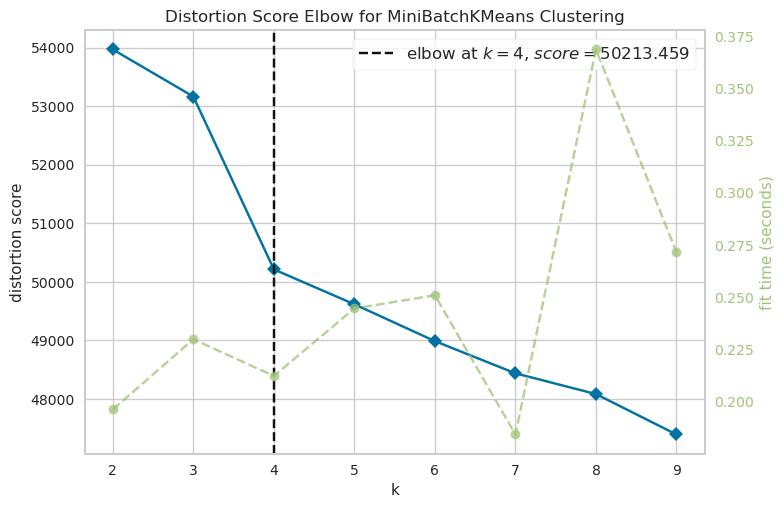

Optimal number of clusters: 4
Counter({1: 4973, 3: 4099, 2: 2439, 0: 2249})
silhouette score of clustering: 0.0350479277809106


In [37]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [stemmer.stem(token.text.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in modelg:
            embeddings.append(modelg[word])
        else:
            embeddings.append(np.zeros(modelg.vector_size))
    
    return np.mean(embeddings, axis=0)

def k_clustering(X):
    visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(2,10))
    visualizer.fit(X)
    visualizer.show()
    clusterNum = visualizer.elbow_value_  #to return optimal Cluster Numbers
    model =  MiniBatchKMeans(n_clusters=clusterNum).fit(X)
    pred_labels = model.labels_
    print('Optimal number of clusters:', clusterNum)
    print(Counter(pred_labels))
    sil_score = silhouette_score(X, pred_labels)
    return model, sil_score, pred_labels

glove_df = df_2.copy()
glove_df['title_cleaned'] = glove_df['title'].apply(simple_tokenize)
glove_df['embeddings']= glove_df['title_cleaned'].apply(get_embeddings)
X = np.vstack(glove_df['embeddings'].values)
model, sil_score, pred_labels = k_clustering(X)
print('silhouette score of clustering:', sil_score)
glove_df['labels'] = pred_labels

In [38]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).astype('float').reshape(1,-1)
new_cluster_label = model.predict(X2)[0]
cluster_docs = glove_df[glove_df['labels'] == new_cluster_label]
sentence_emb_array = np.stack(cluster_docs['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': cluster_docs['title'],
    'category': cluster_docs['category'],
    'labels': cluster_docs['labels'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(5)

title  \
18162                                                         Need A New Name For Your Website? Why Not NameStation?   
4622                                                       What Can We Call Blockchain To Help People Understand It?   
21576  Instafocus Tries To Answer The Question ‘What Happens After The Platform Rug Gets Pulled Out From Under You?’   
34658                                             Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
25538                                           What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   

               category  labels  similarity  
18162        Enterprise       1    0.692395  
4622             Europe       1    0.684864  
21576              Apps       1    0.659468  
34658  Fundings & Exits       1    0.653080  
25538            Europe       1    0.650131

# Custom Word2Vec Model

In [12]:
df_1

category  \
0              Startups   
1      Fundings & Exits   
2                  Apps   
3      Fundings & Exits   
4              Startups   
...                 ...   
39109          Startups   
39110          Startups   
39111              Apps   
39112              Apps   
39113          Startups   

                                                                                     title  
0                                                How startups can use data to grow smarter  
1                                   While the IPO market roars back, venture remains leery  
2                              Instacart reverses course, re-introducing tips for shoppers  
3                                                            PayPal mulled buying GoFundMe  
4                                                              Uber hits another roadblock  
...                                                                                    ...  
39109  UpWest Labs Closes The Missing Link Between New Israeli Startups And Silicon Valley  
39110           Booktango Automatically Publishes Your Timeless Text To Multiple Platforms  
39111                           Want An In-App Notification Center? There’s A SDK For That  
39112                    Urbanspoon: Traffic Up 80% In 2011, Mobile Growth Faster Than Web  
39113                             YippieMove Wants To Become The Twilio Of Email Migration  

[27519 rows x 2 columns]

In [13]:
sentences = df_1["title"].str.lower().tolist()
len(sentences)

27519

In [14]:
#words that aren't in the default dictionary
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(word_freq)

defaultdict(<class 'int'>, {'h': 47564, 'o': 133885, 'w': 26490, ' ': 294871, 's': 131103, 't': 132302, 'a': 135963, 'r': 110455, 'u': 50679, 'p': 55196, 'c': 60087, 'n': 110493, 'e': 178991, 'd': 55347, 'g': 37758, 'm': 47626, 'i': 121921, 'l': 72224, 'k': 20147, 'b': 31803, ',': 12634, 'v': 18270, 'y': 25478, '-': 6615, 'f': 35789, '1': 4562, '5': 2990, '0': 5283, 'j': 2601, '2': 3460, '$': 5464, '3': 2271, '’': 6586, '8': 1039, '.': 4290, 'q': 2615, 'z': 3131, '7': 1026, 'x': 5175, '4': 1568, '%': 509, '(': 460, ')': 460, '&': 858, '?': 695, '6': 1289, ':': 2120, '̈': 1, '‘': 681, '“': 1304, '”': 1306, '+': 398, '!': 237, '9': 924, '/': 209, '—': 341, '🎶': 2, '{': 1, '}': 1, '€': 104, '£': 86, 'é': 76, '\xa0': 61, '–': 153, '~': 19, '@': 24, '🎁': 1, '😆': 1, '💃': 1, '🔛': 1, '*': 19, '#': 89, '…': 84, '😱': 1, '🎉': 1, '🙌': 1, ';': 247, '=': 10, 'ó': 9, '>': 3, 'ö': 2, 'ê': 1, 'å': 1, 'ü': 3, '🌅': 1, '[': 125, ']': 125, 'è': 3, '大': 1, '家': 1, '好': 1, '❤': 1, '️': 1, '🍗': 2, '💵': 1, '💰'

In [26]:
word_freq

defaultdict(int,
            {'h': 47564,
             'o': 133885,
             'w': 26490,
             ' ': 294871,
             's': 131103,
             't': 132302,
             'a': 135963,
             'r': 110455,
             'u': 50679,
             'p': 55196,
             'c': 60087,
             'n': 110493,
             'e': 178991,
             'd': 55347,
             'g': 37758,
             'm': 47626,
             'i': 121921,
             'l': 72224,
             'k': 20147,
             'b': 31803,
             ',': 12634,
             'v': 18270,
             'y': 25478,
             '-': 6615,
             'f': 35789,
             '1': 4562,
             '5': 2990,
             '0': 5283,
             'j': 2601,
             '2': 3460,
             '$': 5464,
             '3': 2271,
             '’': 6586,
             '8': 1039,
             '.': 4290,
             'q': 2615,
             'z': 3131,
             '7': 1026,
             'x': 5175,
             '

# BASE CUSTOM W2V MODEL WITHOUT STOP WORDS REMOVAL

In [14]:
tokenized_titles = []
for title in df_1['title']:
    # Apply lowercase and regex pattern
    title = title.lower()
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    title = re.sub(pattern, '', title)
    
    # Tokenize sentence using Spacy
    doc = nlp(title)
    tokenized_title = [token.text for token in doc]
    tokenized_titles.append(tokenized_title)

# Print tokenized sentences
#print(tokenized_titles)

[['how', 'startups', 'can', 'use', 'data', 'to', 'grow', 'smarter'], ['while', 'the', 'ipo', 'market', 'roars', 'back', ',', 'venture', 'remains', 'leery'], ['instacart', 'reverses', 'course', ',', 're', '-', 'introducing', 'tips', 'for', 'shoppers'], ['paypal', 'mulled', 'buying', 'gofundme'], ['uber', 'hits', 'another', 'roadblock'], ['from', 'the', 'distributed', 'workforce', 'to', 'the', 'partnered', 'economy'], ['pinterest', 'hits', '150', 'm', 'monthly', 'users', ',', 'missing', 'earlier', 'leaked', 'projections', 'in', '2015'], ['speakable', 'lets', 'you', 'take', 'action', 'on', 'news', 'articles', 'that', 'move', 'you'], ['soylent', 'bars', 'recalled', 'after', 'some', 'customers', 'get', 'sick'], ['thrillist', ',', 'nowthis', ',', 'the', 'dodo', 'and', 'seeker', 'form', 'a', 'new', ',', 'discovery', '-', 'backed', 'holding', 'company'], ['pluto', 'tv', ',', 'a', 'free', 'streaming', 'service', 'for', 'cord', 'cutters', ',', 'raises', '$', '30', 'million', 'more'], ['tinder', 

In [401]:
custom_w2v = Word2Vec()

In [16]:
custom_w2v.build_vocab(tokenized_titles)

In [17]:
# Train Word2Vec model
custom_w2v.train(tokenized_titles, total_examples = custom_w2v.corpus_count, epochs=30)

(11582472, 15738480)

In [18]:
custom_w2v.vector_size

100

In [ ]:
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.text.lower()) for token in doc]
    return ' '.join(tokens)

df_1['title_cleaned'] = df_1['title'].apply(simple_tokenize)

In [54]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in custom_w2v.wv:
            embeddings.append(custom_w2v.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(custom_w2v.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [55]:
df_1

category  \
0              Startups   
1      Fundings & Exits   
2                  Apps   
3      Fundings & Exits   
4              Startups   
...                 ...   
39109          Startups   
39110          Startups   
39111              Apps   
39112              Apps   
39113          Startups   

                                                                                     title  \
0                                                How startups can use data to grow smarter   
1                                   While the IPO market roars back, venture remains leery   
2                              Instacart reverses course, re-introducing tips for shoppers   
3                                                            PayPal mulled buying GoFundMe   
4                                                              Uber hits another roadblock   
...                                                                                    ...   
39109  UpWest Labs Closes The Missing Link Between New Israeli Startups And Silicon Valley   
39110           Booktango Automatically Publishes Your Timeless Text To Multiple Platforms   
39111                           Want An In-App Notification Center? There’s A SDK For That   
39112                    Urbanspoon: Traffic Up 80% In 2011, Mobile Growth Faster Than Web   
39113                             YippieMove Wants To Become The Twilio Of Email Migration   

                                                                             title_cleaned  \
0                                                how startups can use data to grow smarter   
1                                  while the ipo market roars back , venture remains leery   
2                           instacart reverses course , re - introducing tips for shoppers   
3                                                            paypal mulled buying gofundme   
4                                                              uber hits another roadblock   
...                                                                                    ...   
39109  upwest labs closes the missing link between new israeli startups and silicon valley   
39110           booktango automatically publishes your timeless text to multiple platforms   
39111                       want an in - app notification center ? there ’s a sdk for that   
39112                 urbanspoon : traffic up 80 % in 2011 , mobile growth faster than web   
39113                             yippiemove wants to become the twilio of email migration   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    embeddings  
0      [0.6546298, 0.06063748, 0.5607844, -0.3053342, 0.6314883, -0.43577796, 0.032485604, 0.74276245, -0.4064878, 0.081047535, -0.59579647, -0.4057492, -0.07519694, 1.2015326, 0.7092877, 0.7052194, -0.62016827, -0.3402495, 0.2941178, 0.1503245, 0.9109355, -0.22689505, 0.8238914, -0.041770242, -0.034567345, 0.23158276, -0.66546696, 0.30342603, -1.0335177, -0.20417893, -0.44230992, -0.45745337, 0.101998396, -0.28737235, 

In [56]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
11728                                                        When All You Want for Christmas Is A Good Venture Capitalist   
9838                                          Kinsa’s New Smart Ear Thermometer Will Tell You What To Do When You’re Sick   
9948                                                                       Have You Tried Asking Siri To Give You A Hint?   
23433                                                       Do We Need Another Angel List? NOAH Insider Seems To Think So   
20899                           You Think You Know What You Want Out Of Twitter Search, But It’s Not What You Really Need   
36692  Amiigo Is A Fitness Bracelet (Plus App) That Knows What Type Of Exercise You’re Doing — And What It’s Doing To You   
25700                                                    Facebook Designers Ask “What Would You Do If You Weren’t Afraid”   
25538                                                What Are You Really Like At Your Job? ViewsOnYou Intends To Find Out   
1032                                   A running tab of what tech people think about whether we’re living in a simulation   
20965                                                                                            Just Tell Me What To Buy   
6862                                                Here’s What You Need To Know About The Latest Leaked Windows 10 Build   
1017                                  If nothing else, StikBox is a good way to hide the fact that you own a selfie stick   
36863                                                                    You Don’t Need A Prototype To Raise A Seed Round   
15932                                                                                       What We Know About Selfie.com   
4112                                         CloudMagic can now tell you everything about the person who just emailed you   
118                                                         Journy tells you what you should do during your next vacation   
22470                                            Think You’ve Got What It Takes To Be A Tech Entrepreneur? Take My Advice   
37174                                    Fribi Is A Social Marketplace To Give Away Or Swap Things You Don’t Need Anymore   
28713                                                               A $100 Watch Can Tell If You’ve Had Too Much To Drink   
13287                                                                      What To Do If Your Lead Investor Asks For ESOP   

         category  similarity  
11728    Startups    0.817120  
9838         Apps    0.780724  
9948      Gadgets    0.779090  
23433      Europe    0.777358  
20899      Social    0.766831  
36692        Apps    0.766086  
25700      Social    0.765506  
25538      Europe    0.762495  
1032         Apps    0.759601  
20965     Gadgets    0.758770  
6862   Enterprise    0.758328  
1017      Gadgets    0.755679  
36863     Opinion    0.753812  
15932      Social    0.753479  
4112         Apps    0.753436  
118      Startups    0.752124  
22470      Europe    0.751864  
37174    Startups    0.751242  
28713     Gadgets    0.748953  
13287    Startups    0.748012

In [57]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
36946                                           Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
37773                                                                                TC Mini Meetup Philly: The Recap   
32623                  TC’s NYC Meetup To Feature Interview With Tumblr’s Derek Gottfrid, Pitch-Off Judges Announced    
37722                                                Wanted: Charlotte Sponsors For The TC Southeast Mini Meetup Tour   
1633                                                 Only in Norway: Fish food company wins startup pitch competition   
5349                                           Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
37320                                                                           EXCLUSIVE: Area Woman Reads Newspaper   
12679                                            Winners Of The TechCrunch London Meetup: GiftGaming, Rook And Keekla   
36556                                                             Reminder: The TechCrunch Toronto Meetup Is Tonight!   
37028  The Final 7 Disrupt SF Startups: Expect Labs, Gyft, Lit Motors, Prior Knowledge, Saya, YourMechanic And Zumper   
35721                                                         Reminder: The Disrupt NY Pitch-Off/Meetup Is On Tuesday   
34338                                                                       Scenes From The Seattle TechCrunch Meetup   
27832                                                                      Reminder: The TC DC Mini-Meetup Is Tonight   
20921                                                      Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
35297                                         TechCrunch’s Picks: The Top 7 Startups From Y Combinator’s W13 Demo Day   
20256                                       Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
5190                                                            TechCrunch Tallinn, Meetup And Pitch-Off, November 18   
18910                                                                 Reminder: The London Pitch-Off+Meetup Is Monday   
36512                               Setting The Stage For Detroit’s Renaissance: Music, Automotive, And Manufacturing   
10743                                                          TechCrunch Giveaway: Canon EOS T3i Kit And NeroTrigger   

       category  similarity  
36946  Startups    0.690859  
37773  Startups    0.641869  
32623  Startups    0.638629  
37722  Startups    0.633359  
1633     Europe    0.631222  
5349   Startups    0.624642  
37320  Startups    0.619675  
12679      Apps    0.615849  
36556  Startups    0.613940  
37028  Startups    0.613290  
35721  Startups    0.611322  
34338  Startups    0.610696  
27832    Social    0.608836  
20921  Startups    0.607172  
35297  Startups    0.606405  
20256  Startups    0.603927  
5190     Europe    0.599207  
18910    Europe    0.599000  
36512  Startups    0.598618  
10743   Gadgets    0.595691

# BASE CUSTOM W2V MODEL WITH STOP WORDS REMOVAL

In [60]:
stop_words = nlp.Defaults.stop_words
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.text.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

df_1['title_cleaned'] = df_1['title'].apply(simple_tokenize)

In [61]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in custom_w2v.wv:
            embeddings.append(custom_w2v.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(custom_w2v.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [62]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34658                       Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
23433                            Do We Need Another Angel List? NOAH Insider Seems To Think So   
3978                                                How our Founding Fathers raised a Series A   
29237                                              You Know What’s Cool? $1 Billion In Profits   
329                                                             Lessons from Shippo’s Series A   
29078                         Should Mark Zuckerberg Think Twice About Establishing A Dynasty?   
36863                                         You Don’t Need A Prototype To Raise A Seed Round   
1069                            Apply to The Duke Of York’s next series of Pitch@Palace events   
5273                                                        What We Know From A Decade Of SaaS   
22469  From Silicon Valley To Europe: Is The U.S. Series A Crunch Affecting European Startups?   
29762                                         Do Blogs Need Comment Reels? Yes, and Here’s How   
14718                                                   You Just Raised $10 Million. Now What?   
10986                                                      Robot Writers Need Something To Say   
156                                                              Are banks promoting phishing?   
37908                                       Why Is Gizmodo Paying People To Harass Zuckerberg?   
17315                RIM Investing $100 Million To Build Developer Community — Is It Too Late?   
17400                                                  If We Build IoT, They Will Come. Right?   
26965                          Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
4049                  Build Or Buy? Anatomy Of An Acquisition — Or Why Buffer Bought Respondly   
19549                             Turnaround Management: Does Your Company Need A New Captain?   

               category  similarity  
34658  Fundings & Exits    0.708237  
23433            Europe    0.674868  
3978              Drama    0.607203  
29237            Social    0.581003  
329            Startups    0.563969  
29078           Opinion    0.549540  
36863           Opinion    0.539706  
1069             Europe    0.539478  
5273         Enterprise    0.525988  
22469            Europe    0.518916  
29762           Opinion    0.511313  
14718          Startups    0.501446  
10986           Gadgets    0.497395  
156              Europe    0.487865  
37908          Startups    0.487714  
17315        Enterprise    0.487639  
17400           Gadgets    0.486123  
26965           Gadgets    0.485653  
4049   Fundings & Exits    0.485025  
19549          Startups    0.483796

In [63]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
8287                                                        How and why to pitch angel groups   
37592                  Reminder: We’re In #TCCharlotte Tonight And Waiting To Hear Your Pitch   
18910                                         Reminder: The London Pitch-Off+Meetup Is Monday   
10342                         TC Cribs: Pact Coffee’s London Office Is As Fresh As Its Coffee   
34531                    Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
5349                   Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
37865  TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
35721                                 Reminder: The Disrupt NY Pitch-Off/Meetup Is On Tuesday   
12679                    Winners Of The TechCrunch London Meetup: GiftGaming, Rook And Keekla   
36946                   Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
20256               Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
32965                          New Orleans Startups: Apply For The February 20 Pitch-Off Here   
18810               Berlin: We Will See You At Our First German Meet-Up And Pitch-Off Tonight   
38357    Startups: Time For Another One-Sentence Pitch Competition With The Founder Institute   
20921                              Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
1633                         Only in Norway: Fish food company wins startup pitch competition   
37722                        Wanted: Charlotte Sponsors For The TC Southeast Mini Meetup Tour   
26903       Timing Is Everything: Indie Movie Discovery Platform Prescreen To Close Its Doors   
27832                                              Reminder: The TC DC Mini-Meetup Is Tonight   
36556                                     Reminder: The TechCrunch Toronto Meetup Is Tonight!   

       category  similarity  
8287   Startups    0.734462  
37592  Startups    0.701090  
18910    Europe    0.700728  
10342    Europe    0.688032  
34531  Startups    0.682985  
5349   Startups    0.680712  
37865  Startups    0.679147  
35721  Startups    0.676596  
12679      Apps    0.674734  
36946  Startups    0.674158  
20256  Startups    0.663925  
32965  Startups    0.661710  
18810    Europe    0.659525  
38357  Startups    0.658448  
20921  Startups    0.657765  
1633     Europe    0.655749  
37722  Startups    0.650915  
26903     Media    0.649881  
27832    Social    0.648087  
36556  Startups    0.647081

# BASE CUSTOM W2V MODEL WITH STOP WORDS REMOVAL, LEMMATIZATION

In [34]:
stop_words = nlp.Defaults.stop_words
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', token.lemma_.lower()) for token in doc if not token.is_stop]
    return ' '.join(tokens)

df_1['title_cleaned'] = df_1['title'].apply(simple_tokenize)

In [35]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in custom_w2v.wv:
            embeddings.append(custom_w2v.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(custom_w2v.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [36]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
34658                           Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
23433                                Do We Need Another Angel List? NOAH Insider Seems To Think So   
29237                                                  You Know What’s Cool? $1 Billion In Profits   
3978                                                    How our Founding Fathers raised a Series A   
36863                                             You Don’t Need A Prototype To Raise A Seed Round   
329                                                                 Lessons from Shippo’s Series A   
16051                      Cute Alert! Can Fuzmo Crowdfund The Build Of Its Pet Pictures Platform?   
2812     iBeat raises $1.5 million to build a heart monitor that people will actually want to wear   
36966              Blue Apron Delivers All The Ingredients You Need To Cook Fresh Meals Every Week   
38148                                                 Help! There’s A Patent On My Idea! What Now?   
20321  Salesforce Joins Datahug’s $4M Series-A, While Valley VCs Love Its ‘Who Knows Who’ Platform   
1069                                Apply to The Duke Of York’s next series of Pitch@Palace events   
17400                                                      If We Build IoT, They Will Come. Right?   
24670                                                 Sabertron, For All Your Foam Swordplay Needs   
18303   Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
22469      From Silicon Valley To Europe: Is The U.S. Series A Crunch Affecting European Startups?   
29078                             Should Mark Zuckerberg Think Twice About Establishing A Dynasty?   
6509                                    Here’s What You Need To Know From Microsoft’s $26B Quarter   
29762                                             Do Blogs Need Comment Reels? Yes, and Here’s How   
36698                          Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   

               category  similarity  
34658  Fundings & Exits    0.652455  
23433            Europe    0.581525  
29237            Social    0.544384  
3978              Drama    0.539641  
36863           Opinion    0.529631  
329            Startups    0.521587  
16051            Europe    0.511517  
2812   Fundings & Exits    0.500596  
36966          Startups    0.497987  
38148          Startups    0.495062  
20321            Europe    0.492674  
1069             Europe    0.491425  
17400           Gadgets    0.490282  
24670           Gadgets    0.489008  
18303            Europe    0.486095  
22469            Europe    0.482027  
29078           Opinion    0.480706  
6509          Developer    0.480694  
29762           Opinion    0.477915  
36698          Startups    0.477774

In [37]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
32965                               New Orleans Startups: Apply For The February 20 Pitch-Off Here   
37592                       Reminder: We’re In #TCCharlotte Tonight And Waiting To Hear Your Pitch   
18910                                              Reminder: The London Pitch-Off+Meetup Is Monday   
37865       TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
8287                                                             How and why to pitch angel groups   
12679                         Winners Of The TechCrunch London Meetup: GiftGaming, Rook And Keekla   
36946                        Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
1414                     Here are the startups pitching at TechCrunch’s Berlin Meet Up + Pitch Off   
1738                                       Announcing the startups pitching at the Tel Aviv Meetup   
35721                                      Reminder: The Disrupt NY Pitch-Off/Meetup Is On Tuesday   
34531                         Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
34809  Last Call For Pitch Applications To The Austin Meetup + Pitch-Off. Also, Get Tickets Here!    
3468                                  These Are The Startups Pitching At Our TechCrunch MWC Meetup   
36556                                          Reminder: The TechCrunch Toronto Meetup Is Tonight!   
36698                          Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
26903            Timing Is Everything: Indie Movie Discovery Platform Prescreen To Close Its Doors   
5190                                         TechCrunch Tallinn, Meetup And Pitch-Off, November 18   
38393                           Calling All Startups: TechCrunch New York Just Posted Office Hours   
5647                                           TechCrunch Lisbon, Meetup And Pitch-Off, October 19   
5349                        Austin and Seattle: applications for the TC Pitch-Offs close on Friday   

       category  similarity  
32965  Startups    0.678538  
37592  Startups    0.677240  
18910    Europe    0.665653  
37865  Startups    0.663663  
8287   Startups    0.662755  
12679      Apps    0.660279  
36946  Startups    0.651735  
1414     Europe    0.650478  
1738     Europe    0.649443  
35721  Startups    0.644314  
34531  Startups    0.636594  
34809  Startups    0.635252  
3468     Europe    0.634124  
36556  Startups    0.632730  
36698  Startups    0.632726  
26903     Media    0.630884  
5190     Europe    0.629037  
38393  Startups    0.628883  
5647     Europe    0.626981  
5349   Startups    0.626261

# BASE CUSTOM W2V MODEL WITH STOP WORDS REMOVAL, STEMMING

In [30]:
stop_words = nlp.Defaults.stop_words
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

df_1['title_cleaned'] = df_1['title'].apply(simple_tokenize)

In [31]:
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in custom_w2v.wv:
            embeddings.append(custom_w2v.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(custom_w2v.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [32]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
6599                             Who The F Is The EFF? John Legere Wants To Know   
29762                           Do Blogs Need Comment Reels? Yes, and Here’s How   
18162                     Need A New Name For Your Website? Why Not NameStation?   
5755                                                        Can You Hear Me Now?   
15086                                       Dónde Están Sus Hijos? Ask DondeEsta   
23433              Do We Need Another Angel List? NOAH Insider Seems To Think So   
2171                                Want to compete with Salesforce? Buy Marketo   
29678                   Can Technology Transform Education Before It’s Too Late?   
27405  Want To Broadcast Live On YouTube? You’ll Need A Google+ Account For That   
4086                               What Does The Chinese Fallout Mean For Apple?   
28102                             Check-In Needs To Work, But How Can We Fix It?   
26965            Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
4783          Sure, why not? FBI agrees to unlock iPhone for Arkansas prosecutor   
24598                                    Missing iGoogle? Try Backstitch Instead   
29888                                  Where Have All The Physical QWERTYs Gone?   
7911                                                                    FacePay?   
4510                                 How Much Technology Is Too Much Technology?   
16367                          Graduated From An Engineering Bootcamp? Now What?   
28879                                  What On Earth Is Google Doing With Orkut?   
17571   Want To Make An Impact With Your Work? Try Some Advice From 80,000 Hours   

         category  similarity  
6599        Humor    0.883024  
29762     Opinion    0.859407  
18162  Enterprise    0.847395  
5755        Cloud    0.830609  
15086      Europe    0.824632  
23433      Europe    0.812272  
2171   Enterprise    0.809965  
29678     Opinion    0.788064  
27405      Social    0.787763  
4086         Asia    0.785400  
28102        Apps    0.785097  
26965     Gadgets    0.779735  
4783      Gadgets    0.775682  
24598      Social    0.775550  
29888     Gadgets    0.773610  
7911         Apps    0.771601  
4510   Government    0.771601  
16367   Developer    0.769752  
28879      Social    0.769280  
17571    Startups    0.760324

In [33]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
37592                       Reminder: We’re In #TCCharlotte Tonight And Waiting To Hear Your Pitch   
36946                        Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
36698                          Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
36556                                          Reminder: The TechCrunch Toronto Meetup Is Tonight!   
35721                                      Reminder: The Disrupt NY Pitch-Off/Meetup Is On Tuesday   
18910                                              Reminder: The London Pitch-Off+Meetup Is Monday   
32458                       The Boston And Los Angeles Meetups Are Next Week, So Get Tickets Now!    
20256                    Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
29683         Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
36604                           Reminder: Our Northern Meetups Are Next Week. Is Your Pitch Ready?   
12679                         Winners Of The TechCrunch London Meetup: GiftGaming, Rook And Keekla   
38523                       Virginia Is For TechCrunchers: DC, Norfolk, and Richmond, Here We Come   
5349                        Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
34531                         Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
34809  Last Call For Pitch Applications To The Austin Meetup + Pitch-Off. Also, Get Tickets Here!    
6273                                                      Las Vegas On Your Own Terms: A CES Recap   
5647                                           TechCrunch Lisbon, Meetup And Pitch-Off, October 19   
27832                                                   Reminder: The TC DC Mini-Meetup Is Tonight   
9262                        These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
5190                                         TechCrunch Tallinn, Meetup And Pitch-Off, November 18   

       category  similarity  
37592  Startups    0.791428  
36946  Startups    0.776495  
36698  Startups    0.752583  
36556  Startups    0.745922  
35721  Startups    0.737006  
18910    Europe    0.734359  
32458  Startups    0.734016  
20256  Startups    0.733937  
29683    Social    0.732634  
36604  Startups    0.731105  
12679      Apps    0.725709  
38523  Startups    0.724673  
5349   Startups    0.718292  
34531  Startups    0.717369  
34809  Startups    0.715612  
6273    Gadgets    0.703054  
5647     Europe    0.700827  
27832    Social    0.696389  
9262       Apps    0.695415  
5190     Europe    0.693721

# Custom Word2Vec model with Skipgram

Based on the base model I will perform lower case, stop words removal, and stemming to build vocabulary for my future W2V models. 

In [17]:
w2v_sg = Word2Vec(vector_size = 300, window = 5, sg = 1, alpha = 0.025 )

In [24]:
tokenized_titles = []
for title in df_1['title']:
    # Apply lowercase and regex pattern
    title = title.lower()
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    title = re.sub(pattern, '', title)
    
    # Tokenize sentence using Spacy
    doc = nlp(title)
    tokenized_title = [stemmer.stem(token.text.lower()) for token in doc if not token.is_stop]
    tokenized_titles.append(tokenized_title)

# Print tokenized sentences
#print(tokenized_titles)

In [25]:
w2v_sg.build_vocab(tokenized_titles)

In [27]:
w2v_sg.train(tokenized_titles, total_examples = w2v_sg.corpus_count, epochs=30)

(6276057, 8160630)

In [26]:
stop_words = nlp.Defaults.stop_words
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

df_1['title_cleaned'] = df_1['title'].apply(simple_tokenize)

In [28]:
def get_embeddings(text):
    model = w2v_sg
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [29]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18162                                                 Need A New Name For Your Website? Why Not NameStation?   
20245                                                          How Many Languages Your Startup Needs To Know   
6599                                                         Who The F Is The EFF? John Legere Wants To Know   
6509                                              Here’s What You Need To Know From Microsoft’s $26B Quarter   
20096                                               The LifeTip Doesn’t Need To Touch You To Know Your Heart   
19549                                           Turnaround Management: Does Your Company Need A New Captain?   
35514  Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
23433                                          Do We Need Another Angel List? NOAH Insider Seems To Think So   
28102                                                         Check-In Needs To Work, But How Can We Fix It?   
26965                                        Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
1599                         We learned from utilities everything we need to know about cloud infrastructure   
18303             Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
29762                                                       Do Blogs Need Comment Reels? Yes, and Here’s How   
24246                   Everything You Need To Know About The Startup Ecosystem In Russia And Eastern Europe   
26296                                            Need An Intro? Greylock-Backed Cloze Rates Your Connections   
20899              You Think You Know What You Want Out Of Twitter Search, But It’s Not What You Really Need   
28245                     Oink Users: Need A New Home For Your Data? Turn That Frown Upside Down With Cheers   
17098                                                    What You Need To Know To Get Started With Apple Pay   
30503                             As Software Eats Up Jobs, Startups Need To Consider Ethics Of Marketplaces   
29237                                                            You Know What’s Cool? $1 Billion In Profits   

         category  similarity  
18162  Enterprise    0.742556  
20245    Startups    0.733775  
6599        Humor    0.702437  
6509    Developer    0.693645  
20096        Apps    0.688273  
19549    Startups    0.684966  
35514        Apps    0.684420  
23433      Europe    0.683345  
28102        Apps    0.673872  
26965     Gadgets    0.671992  
1599        Cloud    0.671807  
18303      Europe    0.670395  
29762     Opinion    0.668545  
24246      Europe    0.656686  
26296      Social    0.655101  
20899      Social    0.654623  
28245        Apps    0.652811  
17098   eCommerce    0.645413  
30503    Startups    0.642276  
29237      Social    0.640802

In [30]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
38902                                            AngelList Takes A Shot At Standardizing The Startup Pitch Deck   
15281                                                     Pitch Your Startup In TC Radio Pitch-Off On Sirius XM   
14045                                                 Pitch Your Startup In The TC Radio Pitch-Off On Sirius XM   
20588                                            Pitch Your Startup Live In The TC Radio Pitch-Off On Sirius XM   
9116                                             Here Are The Pitch-Off Contestants For Our TC Barcelona Meetup   
34757                                Next On Deck For Khan Academy: Better Diagnostics And Internationalization   
9262                                     These Are The Startups Pitching At The Brooklyn TC Meetup + Pitch-Off!   
32708                        Finalists In VC Bill Tai’s New Startup Contest Will Pitch Branson On Necker Island   
25861  WillCall Sells You What You’re Doing Tonight, Launches Web App, Raises $850K From SV Angel, 500 Startups   
20921                                                Pitch Your Startup In The Austin And Seattle TC Pitch-Offs   
21705                                         Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM   
15890                               Pitch Your Startup In The TechCrunch Radio Pitch-Off On Sirius XM 102 Indie   
31052            Commonred Launches VIP Contests To Let Entrepreneurs Pitch Top VCs, Angels (And Win A Meeting)   
34182                                              The TC Meetup + Pitch-Off Is Invading San Diego On August 22   
34829                                              Hurry! The Austin TC Meetup + Pitch-Off Is Selling Out Quick   
29683                      Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
4445                                                           The TC Meetup + Pitch-off hits Tel Aviv TONIGHT!   
32965                                            New Orleans Startups: Apply For The February 20 Pitch-Off Here   
24371                                                     Pitch Your Startup On TC Radio On Sirius XM Indie 102   
24635                                                     Pitch Your Startup On TC Radio On Sirius XM 102 Indie   

            category  similarity  
38902       Startups    0.718922  
15281       Startups    0.696666  
14045       Startups    0.696666  
20588       Startups    0.694010  
9116          Europe    0.688804  
34757      Education    0.688402  
9262            Apps    0.685758  
32708  Entertainment    0.684271  
25861       Startups    0.683319  
20921       Startups    0.682296  
21705       Startups    0.679462  
15890        Gadgets    0.679230  
31052         Social    0.676965  
34182       Startups    0.675339  
34829       Startups    0.674855  
29683         Social    0.674555  
4445        Startups    0.672110  
32965       Startups    0.671936  
24371       Startups    0.669748  
24635       Startups    0.669748

# Custom Word2Vec model with Skipgram and NEGATIVE SAMPLING

In [31]:
w2v_sg = Word2Vec(vector_size = 300, window = 10, sg = 1, alpha = 0.025 , negative = 20)

In [33]:
w2v_sg.build_vocab(tokenized_titles)

In [34]:
w2v_sg.train(tokenized_titles, total_examples = w2v_sg.corpus_count, epochs=30)

(1116758, 1647120)

In [35]:
def get_embeddings(text):
    model = w2v_sg
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [36]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
29762                                                        Do Blogs Need Comment Reels? Yes, and Here’s How   
18303              Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
18162                                                  Need A New Name For Your Website? Why Not NameStation?   
23433                                           Do We Need Another Angel List? NOAH Insider Seems To Think So   
26965                                         Need To Print Teeny-Weenie Things? The LumiFold Has You Covered   
35514   Pitching App Ideas? AppGyver Delivers Mobile App Prototypes In Minutes, No Technical Know-How Needed    
28102                                                          Check-In Needs To Work, But How Can We Fix It?   
25125  More Problems For Apple In Portugal? Apparently It’s Getting Sued For 40M Euros By A Reseller [Report]   
29237                                                             You Know What’s Cool? $1 Billion In Profits   
25704             You’ve Got Facebook Fans, Now What? Booshaka Raises $1M To Ensure Your Posts Earn You Money   
6599                                                          Who The F Is The EFF? John Legere Wants To Know   
27852                Last Minute Holiday Shopping? SixDoors Raises $600K To Courier Gifts, Well, To Your Door   
23091                   Need Some Vacation Inspiration? Minube Brings Its Social Travel Wares To The UK, U.S.   
430                                                                Should your startup take the B Corp route?   
20245                                                           How Many Languages Your Startup Needs To Know   
38361                                                                 If Financing is Marriage, is M&A Death?   
11601                                               Are Secret’s Raging Hormones A Problem Or An Opportunity?   
4878                             Where are they now? Startup Battlefield participant Valor Water raises $1.6M   
23698                  Does The World Need More Social Media Analytics? Kima Ventures Invests €100K In ShoorK   
22796            Crazy-Stupid Or The Future? SoPost Wants To Turn Your Twitter Handle Into A Physical Address   

         category  similarity  
29762     Opinion    0.832688  
18303      Europe    0.827630  
18162  Enterprise    0.816589  
23433      Europe    0.809877  
26965     Gadgets    0.796710  
35514        Apps    0.781051  
28102        Apps    0.780466  
25125      Europe    0.778517  
29237      Social    0.776414  
25704      Social    0.774591  
6599        Humor    0.774004  
27852        Apps    0.773217  
23091      Europe    0.772800  
430      Startups    0.771831  
20245    Startups    0.768323  
38361     Opinion    0.767632  
11601        Apps    0.764061  
4878     Startups    0.761933  
23698      Europe    0.761892  
22796      Europe    0.760292

In [37]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
32965                          New Orleans Startups: Apply For The February 20 Pitch-Off Here   
14078                                           TC Droidcast Episode 38: Just No, Neptune Duo   
5349                   Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
11267                                                  TC AppleCast 18: El Cap And WWDC Recap   
36698                     Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
18910                                         Reminder: The London Pitch-Off+Meetup Is Monday   
29683    Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
20256               Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
18810               Berlin: We Will See You At Our First German Meet-Up And Pitch-Off Tonight   
35721                                 Reminder: The Disrupt NY Pitch-Off/Meetup Is On Tuesday   
34531                    Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
38357    Startups: Time For Another One-Sentence Pitch Competition With The Founder Institute   
12049                     This Week On The TechCrunch Gadgets Podcast: Verizon On The Horizon   
10342                         TC Cribs: Pact Coffee’s London Office Is As Fresh As Its Coffee   
6273                                                 Las Vegas On Your Own Terms: A CES Recap   
9259        Disrupt NY Startup Battlefield Applications Close Today: Why You Should Apply Now   
37865  TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
13324                                       TC Droidcast Episode 41: Our USB-C Fantasy Future   
37773                                                        TC Mini Meetup Philly: The Recap   
36604                      Reminder: Our Northern Meetups Are Next Week. Is Your Pitch Ready?   

       category  similarity  
32965  Startups    0.870685  
14078   Gadgets    0.860692  
5349   Startups    0.853471  
11267   Gadgets    0.850833  
36698  Startups    0.846911  
18910    Europe    0.845937  
29683    Social    0.845340  
20256  Startups    0.842421  
18810    Europe    0.838972  
35721  Startups    0.833670  
34531  Startups    0.831203  
38357  Startups    0.828279  
12049   Gadgets    0.827005  
10342    Europe    0.825791  
6273    Gadgets    0.824299  
9259   Startups    0.823448  
37865  Startups    0.822394  
13324   Gadgets    0.822096  
37773  Startups    0.821616  
36604  Startups    0.815963

In [38]:
w2v_sg = Word2Vec(vector_size = 300, window = 10, sg = 1, alpha = 0.01 , negative = 40)

In [39]:
w2v_sg.build_vocab(tokenized_titles)

In [40]:
w2v_sg.train(tokenized_titles, total_examples = w2v_sg.corpus_count, epochs=30)

(1116129, 1647120)

In [41]:
def get_embeddings(text):
    model = w2v_sg
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [42]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
37934                 Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
18303                     Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
18852                                         Tiggly, An iPad Learning Toy For Babies And Toddlers, Raises Series A    
35850   Order Mapper Raises $550K Led By Vegas Tech Fund, So You Can Order Pizza (And Eventually More) From Anywhere   
26616                    FarFaria Raises $3.25M To Bring Children’s Books To The iPad (And Eventually Other Devices)   
4512                                     Tech Will Save Us Raises $1.8M To Take Hardware/Software Hacking Mainstream   
5523                                                        Codacy Raises $1.1M To Kill Off Unnecessary Code Reviews   
35562                                  How A Teacher Turned To Technology To Solve A Thorny Problem And Raised $100K   
29010                                            Lab42 Taps Social Networks For Market Research, Raises (Almost) $1M   
34750      Judicata Raises $5.8M Second Round to Build Out Advanced Legal Research Systems; Keith Rabois Joins Board   
36194  Farmigo Brings Farmer’s Markets Online (And Into Your Office) With Its New Local Food Communities, Raises $8M   
26628                          Occipital Raises $1M (And Counting) On Kickstarter To Bring 3D Scanning To The Masses   
1868                        Hibob raises $7.5M to help SMEs manage their people (and those pesky workplace pensions)   
3943                                         Silicon:Safe Bags $1M Seed For Its Hardware Fix For Bulk Password Theft   
28917                       Thalmic Labs Raises $14.5M To Make The MYO Armband The Next Big Thing In Gesture Control   
2005                 Proxy raises $1.6 million to kill the card key, and make the internet of things more accessible   
34813                Sensopia Raises $1.2 Million Series A For “Magical” Floor Plan Capturing Application, MagicPlan   
7896                                                                                           The High Score Selfie   
23323                                         Tapestry Raises $600K To Help Seniors Stay Connected With Their Family   
15750                           SalesGossip Raises £600K To Help UK Shoppers Hear About Fashion & Beauty Sales First   

               category  similarity  
37934  Fundings & Exits    0.957435  
18303            Europe    0.950884  
18852              Apps    0.949808  
35850            Mobile    0.948688  
26616            Mobile    0.948626  
4512             Europe    0.947218  
5523          Developer    0.944778  
35562          Startups    0.944436  
29010            Social    0.943057  
34750  Fundings & Exits    0.942479  
36194          Startups    0.942247  
26628           Gadgets    0.941077  
1868             Europe    0.940645  
3943             Europe    0.940632  
28917           Gadgets    0.940550  
2005               Apps    0.940418  
34813              Apps    0.940287  
7896             Europe    0.940229  
23323            Mobile    0.939934  
15750            Europe    0.939915

In [43]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
32965                                         New Orleans Startups: Apply For The February 20 Pitch-Off Here   
14559                                TC Droidcast Episode 35: The Nexus 6 With Touch ID That Might Have Been   
6273                                                                Las Vegas On Your Own Terms: A CES Recap   
37865                 TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
36698                                    Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
13324                                                      TC Droidcast Episode 41: Our USB-C Fantasy Future   
1633                                        Only in Norway: Fish food company wins startup pitch competition   
29683                   Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
9249                                      Calling Startup Warriors: Battlefield Deadline Extended To Feb. 27   
38330                            Betaworks With A Twist: Sandbox Brings Its Startup Foundry To San Francisco   
11720                                                           #MisguidedPR: The Industry’s Internal Crisis   
36410  Startup Genome Ranks The World’s Top Startup Ecosystems: Silicon Valley, Tel Aviv & L.A. Lead The Way   
7887                                             TechCrunch Giveaway: LogMeIn Rescue + 1 Year Mobile License   
12778                                 TechCrunch Disrupt Europe Meetups: London, July 11 And Berlin, July 17   
12048                                                    TC AppleCast 15: Stealing Time And WWDC Predictions   
6493       Announcing The Finalists For The TC CES Hardware Battlefield: Nima, Carbon, IdentiLock, And Wiivv   
37762                                      Get Ready For The TC Southeast Mini Meetup Tour: July 6 – July 12   
8582                           TechCrunch Meetup In Dubai Uncovers A Vibrant Startup Hub For The Middle East   
28672                                                      This Week On The TC Gadgets Podcast: Food And Sex   
35582                            San Quentin Prison Demo Day Gives Entrepreneurs Behind Bars A Second Chance   

         category  similarity  
32965    Startups    0.971941  
14559     Gadgets    0.971721  
6273      Gadgets    0.971413  
37865    Startups    0.970985  
36698    Startups    0.966335  
13324     Gadgets    0.964210  
1633       Europe    0.963117  
29683      Social    0.961855  
9249         Asia    0.960724  
38330    Startups    0.960390  
11720    Startups    0.960034  
36410     Reviews    0.959461  
7887   Enterprise    0.959059  
12778      Europe    0.958941  
12048     Gadgets    0.958888  
6493      Gadgets    0.958529  
37762    Startups    0.958313  
8582       Europe    0.957990  
28672    Podcasts    0.957183  
35582    Startups    0.957012

In [44]:
w2v_sg = Word2Vec(vector_size = 100, window = 10, sg = 1, alpha = 0.01 , negative = 40)

In [45]:
w2v_sg.build_vocab(tokenized_titles)

In [46]:
w2v_sg.train(tokenized_titles, total_examples = w2v_sg.corpus_count, epochs=30)

(1116920, 1647120)

In [47]:
def get_embeddings(text):
    model = w2v_sg
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [48]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
37934                Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
18303                    Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
26616                   FarFaria Raises $3.25M To Bring Children’s Books To The iPad (And Eventually Other Devices)   
35850  Order Mapper Raises $550K Led By Vegas Tech Fund, So You Can Order Pizza (And Eventually More) From Anywhere   
4512                                    Tech Will Save Us Raises $1.8M To Take Hardware/Software Hacking Mainstream   
18852                                        Tiggly, An iPad Learning Toy For Babies And Toddlers, Raises Series A    
38897                                             (Founder Stories) RunKeeper: Jacobs’ Strategy For Raising Capital   
26628                         Occipital Raises $1M (And Counting) On Kickstarter To Bring 3D Scanning To The Masses   
29410                                               Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
29010                                           Lab42 Taps Social Networks For Market Research, Raises (Almost) $1M   
25955                        WWE (Yep, Wrestling) Invests In Video Messaging Startup Tout’s $13.4 Million Series B    
5523                                                       Codacy Raises $1.1M To Kill Off Unnecessary Code Reviews   
7919                                                                   Miito Deconstructs The Kettle To Save Energy   
34883                              Deal Management Startup CapLinked Adds New Investors (And $500K) To Its Series A   
18873                                           Patent Troll Buys ADAPTIX (And Its 4G Technology Patents) For $160M   
34813               Sensopia Raises $1.2 Million Series A For “Magical” Floor Plan Capturing Application, MagicPlan   
39038                          After Raising $100 Million, Russia’s Amazon (OZON) Acquires Russia’s Zappos (Sapato)   
35562                                 How A Teacher Turned To Technology To Solve A Thorny Problem And Raised $100K   
32407                               Genesis Media Raises $6M For Ads That Interrupt But (Hopefully) Don’t Annoy You   
32762                           Speek Raises $5.1 Million Series A To Replace Outdated Conference Calling Solutions   

               category  similarity  
37934  Fundings & Exits    0.951870  
18303            Europe    0.945599  
26616            Mobile    0.941795  
35850            Mobile    0.938664  
4512             Europe    0.937424  
18852              Apps    0.936760  
38897            Mobile    0.935947  
26628           Gadgets    0.934844  
29410         eCommerce    0.934158  
29010            Social    0.933810  
25955  Fundings & Exits    0.933388  
5523          Developer    0.932727  
7919             Europe    0.932215  
34883          Startups    0.932069  
18873        Enterprise    0.931470  
34813              Apps    0.931300  
39038         eCommerce    0.931263  
35562          Startups    0.931039  
32407  Advertising Tech    0.930942  
32762          Startups    0.930779

In [49]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
6273                                                                Las Vegas On Your Own Terms: A CES Recap   
32965                                         New Orleans Startups: Apply For The February 20 Pitch-Off Here   
37865                 TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
14559                                TC Droidcast Episode 35: The Nexus 6 With Touch ID That Might Have Been   
36698                                    Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
1633                                        Only in Norway: Fish food company wins startup pitch competition   
29683                   Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
11720                                                           #MisguidedPR: The Industry’s Internal Crisis   
12048                                                    TC AppleCast 15: Stealing Time And WWDC Predictions   
28672                                                      This Week On The TC Gadgets Podcast: Food And Sex   
38357                   Startups: Time For Another One-Sentence Pitch Competition With The Founder Institute   
13324                                                      TC Droidcast Episode 41: Our USB-C Fantasy Future   
6493       Announcing The Finalists For The TC CES Hardware Battlefield: Nima, Carbon, IdentiLock, And Wiivv   
9249                                      Calling Startup Warriors: Battlefield Deadline Extended To Feb. 27   
36410  Startup Genome Ranks The World’s Top Startup Ecosystems: Silicon Valley, Tel Aviv & L.A. Lead The Way   
26019                                                                      TC Makers: An Evening With iRobot   
37762                                      Get Ready For The TC Southeast Mini Meetup Tour: July 6 – July 12   
11267                                                                 TC AppleCast 18: El Cap And WWDC Recap   
7887                                             TechCrunch Giveaway: LogMeIn Rescue + 1 Year Mobile License   
38330                            Betaworks With A Twist: Sandbox Brings Its Startup Foundry To San Francisco   

         category  similarity  
6273      Gadgets    0.969017  
32965    Startups    0.966477  
37865    Startups    0.964505  
14559     Gadgets    0.961546  
36698    Startups    0.961023  
1633       Europe    0.956367  
29683      Social    0.955943  
11720    Startups    0.955418  
12048     Gadgets    0.953847  
28672    Podcasts    0.953104  
38357    Startups    0.953067  
13324     Gadgets    0.952886  
6493      Gadgets    0.952358  
9249         Asia    0.951912  
36410     Reviews    0.951046  
26019     Gadgets    0.950609  
37762    Startups    0.950282  
11267     Gadgets    0.949885  
7887   Enterprise    0.949280  
38330    Startups    0.949259

# Custom Word2Vec model with CBOW

In [402]:
w2v_cbow = Word2Vec(vector_size = 300, window = 5, sg = 0, alpha = 0.025 )

In [51]:
w2v_cbow.build_vocab(tokenized_titles)

In [54]:
w2v_cbow.train(tokenized_titles, total_examples = w2v_cbow.corpus_count, epochs=30)

(1116833, 1647120)

In [55]:
def get_embeddings(text):
    model = w2v_cbow
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [56]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
18303              Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
3978                                                               How our Founding Fathers raised a Series A   
329                                                                            Lessons from Shippo’s Series A   
18837                                  Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   
37934          Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
27435                                                               Path Finally Closes That Elusive Series C   
5601                  Campus Job, Connecting College Students With Employers, Raises $7.8 Million In Series A   
12480                                             Glow Raises $7M Series A From Notion Capital And White Star   
36863                                                        You Don’t Need A Prototype To Raise A Seed Round   
25125  More Problems For Apple In Portugal? Apparently It’s Getting Sued For 40M Euros By A Reseller [Report]   
8156                                                       Korean Bitcoin Exchange Korbit Raises $3M Series A   
32762                     Speek Raises $5.1 Million Series A To Replace Outdated Conference Calling Solutions   
35307                                             The Series A Bottleneck Grows Tighter, Fenwick Survey Shows   
35053                                                    DailyWorth Raises Additional $1 Million For Series A   
37942                                Wibbitz Raises $2.3M Series A For Technology That Turns Text Into Videos   
4878                             Where are they now? Startup Battlefield participant Valor Water raises $1.6M   
25790                                                Ireland’s MTT Raises $5 Million Series A From DFJ Esprit   
9854                 Gravie Health Insurance Marketplace Raises $10.5 Million Series A From Aberdare Ventures   
4604                                            Digg Raises $4M Series A From Betaworks Backer Digital Garage   
3847                                                      MoEngage Raises $4.25M Series A To Grow In The U.S.   

               category  similarity  
18303            Europe    0.704412  
3978              Drama    0.701769  
329            Startups    0.631600  
18837            Mobile    0.595101  
37934  Fundings & Exits    0.593424  
27435              Apps    0.576954  
5601         Enterprise    0.571274  
12480            Europe    0.565727  
36863           Opinion    0.563996  
25125            Europe    0.558732  
8156               Asia    0.551642  
32762          Startups    0.551356  
35307          Startups    0.547846  
35053          Startups    0.546615  
37942  Fundings & Exits    0.541039  
4878           Startups    0.539508  
25790            Europe    0.538986  
9854         Enterprise    0.537202  
4604              Media    0.536309  
3847               Asia    0.534350

In [61]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
14078                                     TC Droidcast Episode 38: Just No, Neptune Duo   
32965                    New Orleans Startups: Apply For The February 20 Pitch-Off Here   
11267                                            TC AppleCast 18: El Cap And WWDC Recap   
37773                                                  TC Mini Meetup Philly: The Recap   
37592            Reminder: We’re In #TCCharlotte Tonight And Waiting To Hear Your Pitch   
34531              Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
6273                                           Las Vegas On Your Own Terms: A CES Recap   
5349             Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
19981                              This Week On The TC Gadgets Podcast: Summer Doldrums   
9508                             This Week On The TC Gadgets Podcast: Toutes Les Pommes   
23976                           This Week On The TC Gadgets Podcast: All MWC Everything   
12049               This Week On The TechCrunch Gadgets Podcast: Verizon On The Horizon   
37703  Infographics That Don’t Suck: FindTheBest’s Comparison Charts Are Now Embeddable   
27813                   This Week On The TC Gadgets Podcast: Sphero 2.0 And Speculation   
11988                                                                 #Love: Wanderlust   
36698               Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
23050           TC Droidcast Episode 24: A Couple Of Mates Talking About The HTC One M8   
25601                               Gift Guide: Four Sweet Presents For Your Sweetheart   
28299   This Week On The TC Gadgets Podcast: Surface RT, Moto X, And The Seattle Meetup   
14363                                  This Week On The TC Gadgets Podcast: Friendship!   

       category  similarity  
14078   Gadgets    0.818167  
32965  Startups    0.808852  
11267   Gadgets    0.806454  
37773  Startups    0.791799  
37592  Startups    0.774496  
34531  Startups    0.766367  
6273    Gadgets    0.763030  
5349   Startups    0.756489  
19981   Gadgets    0.753613  
9508    Gadgets    0.753613  
23976   Gadgets    0.753613  
12049   Gadgets    0.750686  
37703  Startups    0.742468  
27813   Gadgets    0.737459  
11988    Mobile    0.736569  
36698  Startups    0.734218  
23050   Gadgets    0.731001  
25601      Apps    0.730763  
28299   Gadgets    0.728058  
14363   Gadgets    0.727852

# Custom Word2Vec model with CBOW and NEGATIVE SAMPLING

In [62]:
w2v_cbow = Word2Vec(vector_size = 300, window = 10, sg = 0, alpha = 0.025 , negative = 20)

In [63]:
w2v_cbow.build_vocab(tokenized_titles)

In [64]:
w2v_cbow.train(tokenized_titles, total_examples = w2v_cbow.corpus_count, epochs=30)

(1116686, 1647120)

In [65]:
def get_embeddings(text):
    model = w2v_cbow
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [66]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
3978                                                                     How our Founding Fathers raised a Series A   
18852                                        Tiggly, An iPad Learning Toy For Babies And Toddlers, Raises Series A    
37934                Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
36863                                                              You Don’t Need A Prototype To Raise A Seed Round   
35307                                                   The Series A Bottleneck Grows Tighter, Fenwick Survey Shows   
18303                    Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
15750                          SalesGossip Raises £600K To Help UK Shoppers Hear About Fashion & Beauty Sales First   
34658                                            Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
27435                                                                     Path Finally Closes That Elusive Series C   
29410                                               Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
12480                                                   Glow Raises $7M Series A From Notion Capital And White Star   
33301                          Spire Raises $8M In Series A To Help Customers Manage Talent, Prevent Employee Fraud   
59                                                                              GitHub is raising a secondary round   
35850  Order Mapper Raises $550K Led By Vegas Tech Fund, So You Can Order Pizza (And Eventually More) From Anywhere   
14140                                                   Raise Your Seed Round By Treating Investors As Team Members   
15942     GetYourGuide Gets $4.5M Series A Expansion, From Ex-Booking.com CEO (& Others), To Help It Scale Globally   
29878                  Circuit Playground Is Adafruit’s Educational Series For Helping Kids Learn About Electronics   
1658                                         Hardware Battlefield Alum Health2Sync raises $3 million Series A round   
7896                                                                                          The High Score Selfie   
18292         Typeform Raises €550K Seed Round To Help You Build Beautiful Device-Agnostic Online Surveys And Forms   

               category  similarity  
3978              Drama    0.883435  
18852              Apps    0.874243  
37934  Fundings & Exits    0.873267  
36863           Opinion    0.859130  
35307          Startups    0.842557  
18303            Europe    0.838448  
15750            Europe    0.835268  
34658  Fundings & Exits    0.829524  
27435              Apps    0.825990  
29410         eCommerce    0.818269  
12480            Europe    0.814773  
33301          Startups    0.813938  
59           Enterprise    0.813276  
35850            Mobile    0.809857  
14140          Startups    0.808813  
15942            Europe    0.807505  
29878         Education    0.806398  
1658    Disrupt SF 2016    0.806321  
7896             Europe    0.805686  
18292            Europe    0.805427

In [68]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
5349              Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
20256          Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
32965                     New Orleans Startups: Apply For The February 20 Pitch-Off Here   
36698                Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
11267                                             TC AppleCast 18: El Cap And WWDC Recap   
34531               Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
28672                                  This Week On The TC Gadgets Podcast: Food And Sex   
5564                     Austin and Seattle TC Pitch-off applications close in two weeks   
1633                    Only in Norway: Fish food company wins startup pitch competition   
9259   Disrupt NY Startup Battlefield Applications Close Today: Why You Should Apply Now   
20414      Applications For The Austin And Seattle Pitch-Offs Close On Friday, So Hurry!   
14559            TC Droidcast Episode 35: The Nexus 6 With Touch ID That Might Have Been   
31334                          TechCrunch Makers: An Evening At The Van Brunt Stillhouse   
12778             TechCrunch Disrupt Europe Meetups: London, July 11 And Berlin, July 17   
16500                   TC Droidcast Episode 26: Moto Rules With Droid Turbo And Nexus 6   
10152         Applications For The TC Pitch-Offs In Boston And Atlanta Close In One Week   
26019                                                  TC Makers: An Evening With iRobot   
10342                    TC Cribs: Pact Coffee’s London Office Is As Fresh As Its Coffee   
36946              Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
14078                                      TC Droidcast Episode 38: Just No, Neptune Duo   

       category  similarity  
5349   Startups    0.950932  
20256  Startups    0.948770  
32965  Startups    0.930770  
36698  Startups    0.927406  
11267   Gadgets    0.925825  
34531  Startups    0.924771  
28672  Podcasts    0.920811  
5564   Startups    0.920599  
1633     Europe    0.920067  
9259   Startups    0.916830  
20414  Startups    0.916369  
14559   Gadgets    0.914707  
31334   Gadgets    0.914669  
12778    Europe    0.914353  
16500   Gadgets    0.914311  
10152  Startups    0.913354  
26019   Gadgets    0.911318  
10342    Europe    0.911148  
36946  Startups    0.906016  
14078   Gadgets    0.904826

In [69]:
w2v_cbow = Word2Vec(vector_size = 300, window = 10, sg = 0, alpha = 0.01 , negative = 40)

In [70]:
w2v_cbow.build_vocab(tokenized_titles)

In [71]:
w2v_cbow.train(tokenized_titles, total_examples = w2v_cbow.corpus_count, epochs=30)

(1116564, 1647120)

In [72]:
def get_embeddings(text):
    model = w2v_cbow
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [73]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
26514                                                    University Beyond Raises $300K Seed To Hook Up Brands And College Kids   
17316                             GitHub Pours Energies into Enterprise – Raises $100 Million From Power VC Andreessen Horowitz   
21081                                                 Holiday Home Exchange Community Knok Raises $645K To Grow Internationally   
2847                                                           Zore X is a smart gun lock that raised almost $250K on Indiegogo   
16706                                        Storage Provider Nutanix Raises $33 Million And Shows Signs Of Readying For An IPO   
17570                                 Solar Power Startup Bright Raises $4 Million To Distribute Energy In The Developing World   
6395                                      Conductor Proves Web Presence Management Is A Real Thing With $27 Million In Series D   
18455                                          Troll Fighters: Article One Partners Raises $7M For Its Patent Research Platform   
24658                                             Boombotix Raises $4M For Its Wearable Action Speakers And Audio Sync Software   
14114            Pinterest Marketing Platform Ahalogy Scores $3 Million Series A By Helping Brands With Content & Optimizations   
24453                                      FilterEasy Raises $1.2 Million To Help You Remember To Change Your Home’s Air Filter   
7768                                                 15Five Picks Up Another $2.2M To Improve How Work Teams Talk To Each Other   
2941                                                                Andy Rubin explains his $300M bet on the future of hardware   
23390                                                Augmedix Raises $3.2M To Make Google Glass Standard Kit For Future Doctors   
13976                                                         Iotera Raises $1 Million For Its Super Simple GPS Tracking Device   
10473                                     MIT Spinout Insurify Raises $2 Million To Replace Human Insurance Agents With A Robot   
28568  Backed By $4.5 Million In Series A Funding, Mustbin For iPhone Organizes And Secures All Your Personal Data In One Place   
17105                                    Tintri Raises $25 Million For Storage Designed To Improve Virtual Machine Environments   
34750                 Judicata Raises $5.8M Second Round to Build Out Advanced Legal Research Systems; Keith Rabois Joins Board   
22405                                       How Much Should You Charge For Your Airbnb? Beyond Pricing Scores $1.5M To Tell You   

               category  similarity  
26514  Fundings & Exits    0.999230  
17316        Enterprise    0.999170  
21081            Europe    0.999106  
2847            Gadgets    0.999068  
16706        Enterprise    0.999057  
17570          Startups    0.999034  
6395   Advertising Tech    0.999016  
18455        Enterprise    0.999003  
24658  Fundings & Exits    0.998940  
14114  Fundings & Exits    0.998925  
24453         eCommerce    0.998911  
7768         Enterprise    0.998893  
2941            Gadgets    0.998840  
23390  Fundings & Exits    0.998839  
13976  Fundings & Exits    0.998838  
10473  Fundings & Exits    0.998829  
28568              Apps    0.998821  
17105        Enterprise    0.998817  
34750  Fundings & Exits    0.998803  
22405              Apps    0.998799

In [43]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
32965                                         New Orleans Startups: Apply For The February 20 Pitch-Off Here   
14559                                TC Droidcast Episode 35: The Nexus 6 With Touch ID That Might Have Been   
6273                                                                Las Vegas On Your Own Terms: A CES Recap   
37865                 TechCrunch Is Holding Office Hours On Our Southeast Meetup Tour: Reserve Your Spot Now   
36698                                    Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
13324                                                      TC Droidcast Episode 41: Our USB-C Fantasy Future   
1633                                        Only in Norway: Fish food company wins startup pitch competition   
29683                   Pitch Now: Intel Awarding Young Entrepreneurs With $100K For Whizbang Business Ideas   
9249                                      Calling Startup Warriors: Battlefield Deadline Extended To Feb. 27   
38330                            Betaworks With A Twist: Sandbox Brings Its Startup Foundry To San Francisco   
11720                                                           #MisguidedPR: The Industry’s Internal Crisis   
36410  Startup Genome Ranks The World’s Top Startup Ecosystems: Silicon Valley, Tel Aviv & L.A. Lead The Way   
7887                                             TechCrunch Giveaway: LogMeIn Rescue + 1 Year Mobile License   
12778                                 TechCrunch Disrupt Europe Meetups: London, July 11 And Berlin, July 17   
12048                                                    TC AppleCast 15: Stealing Time And WWDC Predictions   
6493       Announcing The Finalists For The TC CES Hardware Battlefield: Nima, Carbon, IdentiLock, And Wiivv   
37762                                      Get Ready For The TC Southeast Mini Meetup Tour: July 6 – July 12   
8582                           TechCrunch Meetup In Dubai Uncovers A Vibrant Startup Hub For The Middle East   
28672                                                      This Week On The TC Gadgets Podcast: Food And Sex   
35582                            San Quentin Prison Demo Day Gives Entrepreneurs Behind Bars A Second Chance   

         category  similarity  
32965    Startups    0.971941  
14559     Gadgets    0.971721  
6273      Gadgets    0.971413  
37865    Startups    0.970985  
36698    Startups    0.966335  
13324     Gadgets    0.964210  
1633       Europe    0.963117  
29683      Social    0.961855  
9249         Asia    0.960724  
38330    Startups    0.960390  
11720    Startups    0.960034  
36410     Reviews    0.959461  
7887   Enterprise    0.959059  
12778      Europe    0.958941  
12048     Gadgets    0.958888  
6493      Gadgets    0.958529  
37762    Startups    0.958313  
8582       Europe    0.957990  
28672    Podcasts    0.957183  
35582    Startups    0.957012

In [93]:
w2v_cbow = Word2Vec(vector_size = 100, window = 10, sg = 0, alpha = 0.01 , negative = 10)

In [94]:
w2v_cbow.build_vocab(tokenized_titles)

In [95]:
w2v_cbow.train(tokenized_titles, total_examples = w2v_cbow.corpus_count, epochs=80)

(2977340, 4392320)

In [96]:
def get_embeddings(text):
    model = w2v_cbow
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

df_1['embeddings']= df_1['title_cleaned'].apply(get_embeddings)

In [97]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
3978                                                                      How our Founding Fathers raised a Series A   
37934                 Members-Only Airline Surf Air Raises Series A From Anthem, NEA & Others (Including Jared Leto)   
18852                                         Tiggly, An iPad Learning Toy For Babies And Toddlers, Raises Series A    
18303                     Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
29410                                                Doggie-Focused Bark & Co. (BarkBox) Raises $15 Million Series B   
36863                                                               You Don’t Need A Prototype To Raise A Seed Round   
35307                                                    The Series A Bottleneck Grows Tighter, Fenwick Survey Shows   
12480                                                    Glow Raises $7M Series A From Notion Capital And White Star   
27435                                                                      Path Finally Closes That Elusive Series C   
15942      GetYourGuide Gets $4.5M Series A Expansion, From Ex-Booking.com CEO (& Others), To Help It Scale Globally   
36194  Farmigo Brings Farmer’s Markets Online (And Into Your Office) With Its New Local Food Communities, Raises $8M   
5790                                          SeamlessDocs raises $7 million Series B to help governments go digital   
1658                                          Hardware Battlefield Alum Health2Sync raises $3 million Series A round   
34658                                             Iterations: Getting To Series A Is Not Sexy, It’s Really Hard Work   
26616                    FarFaria Raises $3.25M To Bring Children’s Books To The iPad (And Eventually Other Devices)   
33301                           Spire Raises $8M In Series A To Help Customers Manage Talent, Prevent Employee Fraud   
59                                                                               GitHub is raising a secondary round   
35850   Order Mapper Raises $550K Led By Vegas Tech Fund, So You Can Order Pizza (And Eventually More) From Anywhere   
15750                           SalesGossip Raises £600K To Help UK Shoppers Hear About Fashion & Beauty Sales First   
18051                               Clicks Be Gone: AdTech Disrupter Moat Raises $12M Series B From Mayfield, Others   

               category  similarity  
3978              Drama    0.889433  
37934  Fundings & Exits    0.880824  
18852              Apps    0.873504  
18303            Europe    0.857511  
29410         eCommerce    0.857011  
36863           Opinion    0.855485  
35307          Startups    0.849774  
12480            Europe    0.844963  
27435              Apps    0.844801  
15942            Europe    0.843775  
36194          Startups    0.833167  
5790              Cloud    0.830555  
1658    Disrupt SF 2016    0.829276  
34658  Fundings & Exits    0.829061  
26616            Mobile    0.827627  
33301          Startups    0.826528  
59           Enterprise    0.825965  
35850            Mobile    0.825949  
15750            Europe    0.824644  
18051        Enterprise    0.823784

In [98]:
X2 = get_embeddings(simple_tokenize('Pitch Deck Teardown: MiO Marketplace’s angel deck')).reshape(1, -1)
sentence_emb_array = np.stack(df_1['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': df_1['title'],
    'category': df_1['category'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(20)

title  \
5349                              Austin and Seattle: applications for the TC Pitch-Offs close on Friday   
36698                                Last Call: The TechCrunch Northern Meetup Series Is Almost Sold Out   
20256                          Reminder: Applications Close For Austin And Seattle Pitch-Offs On Friday!   
11267                                                             TC AppleCast 18: El Cap And WWDC Recap   
32965                                     New Orleans Startups: Apply For The February 20 Pitch-Off Here   
34531                               Reminder: The Seattle TC Meetup + Pitch-Off Is Going Down On July 18   
28672                                                  This Week On The TC Gadgets Podcast: Food And Sex   
1633                                    Only in Norway: Fish food company wins startup pitch competition   
9259                   Disrupt NY Startup Battlefield Applications Close Today: Why You Should Apply Now   
14078                                                      TC Droidcast Episode 38: Just No, Neptune Duo   
14559                            TC Droidcast Episode 35: The Nexus 6 With Touch ID That Might Have Been   
16500                                   TC Droidcast Episode 26: Moto Rules With Droid Turbo And Nexus 6   
6493   Announcing The Finalists For The TC CES Hardware Battlefield: Nima, Carbon, IdentiLock, And Wiivv   
10342                                    TC Cribs: Pact Coffee’s London Office Is As Fresh As Its Coffee   
31334                                          TechCrunch Makers: An Evening At The Van Brunt Stillhouse   
36946                              Announcing The TechCrunch Northern Meetups: Toronto, Detroit, Chicago   
28299                    This Week On The TC Gadgets Podcast: Surface RT, Moto X, And The Seattle Meetup   
26019                                                                  TC Makers: An Evening With iRobot   
10743                                             TechCrunch Giveaway: Canon EOS T3i Kit And NeroTrigger   
6273                                                            Las Vegas On Your Own Terms: A CES Recap   

       category  similarity  
5349   Startups    0.936841  
36698  Startups    0.934387  
20256  Startups    0.932018  
11267   Gadgets    0.921576  
32965  Startups    0.916319  
34531  Startups    0.912296  
28672  Podcasts    0.912105  
1633     Europe    0.909481  
9259   Startups    0.909228  
14078   Gadgets    0.905402  
14559   Gadgets    0.905025  
16500   Gadgets    0.904227  
6493    Gadgets    0.897393  
10342    Europe    0.897164  
31334   Gadgets    0.895975  
36946  Startups    0.895435  
28299   Gadgets    0.894784  
26019   Gadgets    0.893763  
10743   Gadgets    0.892915  
6273    Gadgets    0.892031

# CUSTOM WORD2VEC WINNER MODEL

In [14]:
w2v_cbow = Word2Vec(vector_size = 300, window = 10, sg = 0, alpha = 0.025 , negative = 20)

custom_w2v_df = df_2.copy()

tokenized_titles = []
for title in custom_w2v_df['title']:
    # Apply lowercase and regex pattern
    title = title.lower()
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    title = re.sub(pattern, '', title)
    
    # Tokenize sentence using Spacy
    doc = nlp(title)
    tokenized_title = [stemmer.stem(token.text.lower()) for token in doc if not token.is_stop]
    tokenized_titles.append(tokenized_title)

w2v_cbow.build_vocab(tokenized_titles)
w2v_cbow.train(tokenized_titles, total_examples = w2v_cbow.corpus_count, epochs=30)

(2975792, 4077030)

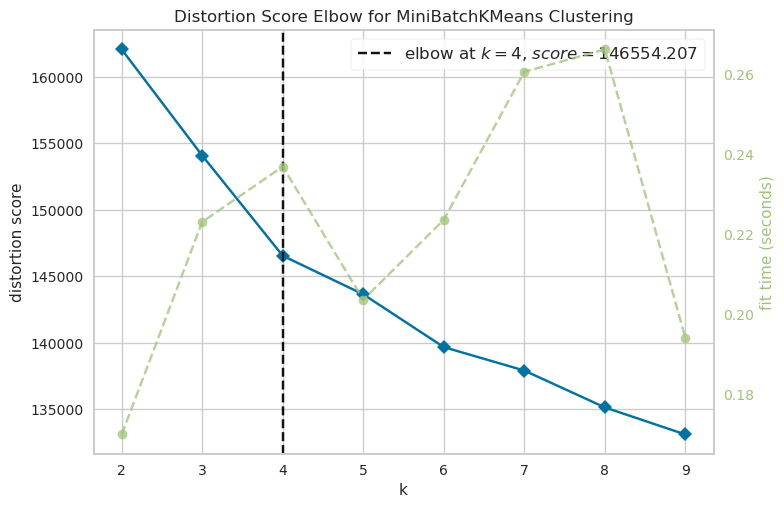

Optimal number of clusters: 4
Counter({3: 4871, 0: 3807, 2: 2686, 1: 2396})
silhouette score of clustering: 0.09250240351493769


In [26]:
stop_words = nlp.Defaults.stop_words
def simple_tokenize(text):
    doc = nlp(text)
    pattern = r'[()&?:6\':“”+!9/—{}\é\xa0–~@*#\…;=ó>öêåü\[\]è大家好❤️🍗💵💰🕵москва″á\n\tíōęú"×|çàº_<_]¥′]'
    tokens = [re.sub(pattern, '', stemmer.stem(token.text.lower())) for token in doc if not token.is_stop]
    return ' '.join(tokens)

def get_embeddings(text):
    model = w2v_cbow
    embeddings = []
    for word in text.split():
        if word in model.wv:
            embeddings.append(model.wv.get_vector(word))
        else:
            embeddings.append(np.zeros(model.vector_size))
    
    return np.mean(embeddings, axis=0)

def k_clustering(X):
    visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(2,10))
    visualizer.fit(X)
    visualizer.show()
    clusterNum = visualizer.elbow_value_  #to return optimal Cluster Numbers
    model =  MiniBatchKMeans(n_clusters=clusterNum).fit(X)
    pred_labels = model.labels_
    print('Optimal number of clusters:', clusterNum)
    print(Counter(pred_labels))
    sil_score = silhouette_score(X, pred_labels)
    return model, sil_score, pred_labels

custom_w2v_df['title_cleaned'] = custom_w2v_df['title'].apply(simple_tokenize)
custom_w2v_df['embeddings']= custom_w2v_df['title_cleaned'].apply(get_embeddings)
X = np.vstack(custom_w2v_df['embeddings'].values)
model, sil_score, pred_labels = k_clustering(X)
print('silhouette score of clustering:', sil_score)
custom_w2v_df['labels'] = pred_labels

In [19]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).astype('float').reshape(1,-1)
new_cluster_label = model.predict(X2)[0]
cluster_docs = custom_w2v_df[custom_w2v_df['labels'] == new_cluster_label]
sentence_emb_array = np.stack(cluster_docs['embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': cluster_docs['title'],
    'category': cluster_docs['category'],
    'labels': cluster_docs['labels'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(5)

title  \
18303  Is That Really You? Face And Speaker Authentication Startup KeyLemon Raises $1.5M Series A   
35307                                 The Series A Bottleneck Grows Tighter, Fenwick Survey Shows   
12582                    SeamlessDocs Raises $5 Million Series A To Bring Government Forms Online   
32762         Speek Raises $5.1 Million Series A To Replace Outdated Conference Calling Solutions   
18837                      Bionym Raises $14M Series A For Its Heartbeat Authentication Wristband   

         category  labels  similarity  
18303      Europe       1    0.664796  
35307    Startups       1    0.658377  
12582  Government       1    0.652980  
32762    Startups       1    0.641791  
18837      Mobile       1    0.634178

# LSA/SVD

We will perform LSA/SVD on our winner custom W2V model and see if reducing principal components can result in better clustering

In [27]:
custom_w2v_df

category  \
15955          Startups   
11668        Enterprise   
14904          Startups   
19308         Education   
6257   Advertising Tech   
...                 ...   
21918           Gadgets   
30774            Social   
37751          Startups   
25798            Europe   
11080           Gadgets   

                                                                                               title  \
15955                                        You’ve Only Got One Shot At Building A Consumer Unicorn   
11668                   Box Gets A Little More Palatable With Some Added Encryption From CipherCloud   
14904                               Pypestream Raises $2M To Help Businesses Talk To Their Customers   
19308  HealthKeep Launches An Anonymous Social Network To Let You Share And Track Health Information   
6257                                  Big Viking Games Acquires Mobile Marketing Startup Gallop Labs   
...                                                                                              ...   
21918                 BlackBerry Officially Unveils The Z3 “Jakarta Edition,” Its $200 Foxconn Phone   
30774                                                      Twitter Is Testing An Expandable Timeline   
37751                        Why Are Startups Flocking To SF? There’s No More Room In Silicon Valley   
25798                                                             Jamie Oliver Heats Up LeWeb London   
11080                                    The LightFreq Square2 Lets You Rock Out With Your Lights On   

                                                               title_cleaned  \
15955                                          got shot build consum unicorn   
11668                             box get littl palat ad encrypt ciphercloud   
14904                            pypestream rais $ 2 m help busi talk custom   
19308  healthkeep launch anonym social network let share track health inform   
6257                    big vike game acquir mobil market startup gallop lab   
...                                                                      ...   
21918     blackberri offici unveil z3 “ jakarta edit , ” $ 200 foxconn phone   
30774                                            twitter test expand timelin   
37751                                 startup flock sf ? room silicon valley   
25798                                            jami oliv heat leweb london   
11080                                       lightfreq square2 let rock light   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    embeddings  \
15955  [-0.1255196, 0.052194692, 0.42158118, 0.09167084, 0.076162376, 0.045172047, 0.22755018, 0.02221548, -0.20654552, -0.04697328, -0.069309406, 0.023890872, 0.1882944, -0.18492797, -0.17696923, -0.041366003, -0.33231664, -0.120383106, 0.17523755, -0.16670993, -0.21357203, 0.39409488, -0.03457293, 0.14061649, 0.08267583, -0.034666635, -0.17550004, -0.013205772, -0.05444492, -0.103542626, 0.068787694, 0.08791944, -0.040317964, 0.014157677, 0.003831306, 0.04050692, 

In [29]:
lsa = TruncatedSVD(n_components=150)
X = np.vstack(custom_w2v_df['embeddings'].values)
svd_embeddings = lsa.fit_transform(X)
custom_w2v_df['svd_embeddings'] = [emb for emb in svd_embeddings]
X_svd = np.vstack(custom_w2v_df['svd_embeddings'].values)

In [31]:
custom_w2v_df.svd_embeddings.iloc[0].shape

(150,)

In [32]:
custom_w2v_df

category  \
15955          Startups   
11668        Enterprise   
14904          Startups   
19308         Education   
6257   Advertising Tech   
...                 ...   
21918           Gadgets   
30774            Social   
37751          Startups   
25798            Europe   
11080           Gadgets   

                                                                                               title  \
15955                                        You’ve Only Got One Shot At Building A Consumer Unicorn   
11668                   Box Gets A Little More Palatable With Some Added Encryption From CipherCloud   
14904                               Pypestream Raises $2M To Help Businesses Talk To Their Customers   
19308  HealthKeep Launches An Anonymous Social Network To Let You Share And Track Health Information   
6257                                  Big Viking Games Acquires Mobile Marketing Startup Gallop Labs   
...                                                                                              ...   
21918                 BlackBerry Officially Unveils The Z3 “Jakarta Edition,” Its $200 Foxconn Phone   
30774                                                      Twitter Is Testing An Expandable Timeline   
37751                        Why Are Startups Flocking To SF? There’s No More Room In Silicon Valley   
25798                                                             Jamie Oliver Heats Up LeWeb London   
11080                                    The LightFreq Square2 Lets You Rock Out With Your Lights On   

                                                               title_cleaned  \
15955                                          got shot build consum unicorn   
11668                             box get littl palat ad encrypt ciphercloud   
14904                            pypestream rais $ 2 m help busi talk custom   
19308  healthkeep launch anonym social network let share track health inform   
6257                    big vike game acquir mobil market startup gallop lab   
...                                                                      ...   
21918     blackberri offici unveil z3 “ jakarta edit , ” $ 200 foxconn phone   
30774                                            twitter test expand timelin   
37751                                 startup flock sf ? room silicon valley   
25798                                            jami oliv heat leweb london   
11080                                       lightfreq square2 let rock light   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    embeddings  \
15955  [-0.1255196, 0.052194692, 0.42158118, 0.09167084, 0.076162376, 0.045172047, 0.22755018, 0.02221548, -0.20654552, -0.04697328, -0.069309406, 0.023890872, 0.1882944, -0.18492797, -0.17696923, -0.041366003, -0.33231664, -0.120383106, 0.17523755, -0.16670993, -0.21357203, 0.39409488, -0.03457293, 0.14061649, 0.08267583, -0.034666635, -0.17550004, -0.013205772, -0.05444492, -0.103542626, 0.068787694, 0.08791944, -0.040317964, 0.014157677, 0.003831306, 0.04050692, 

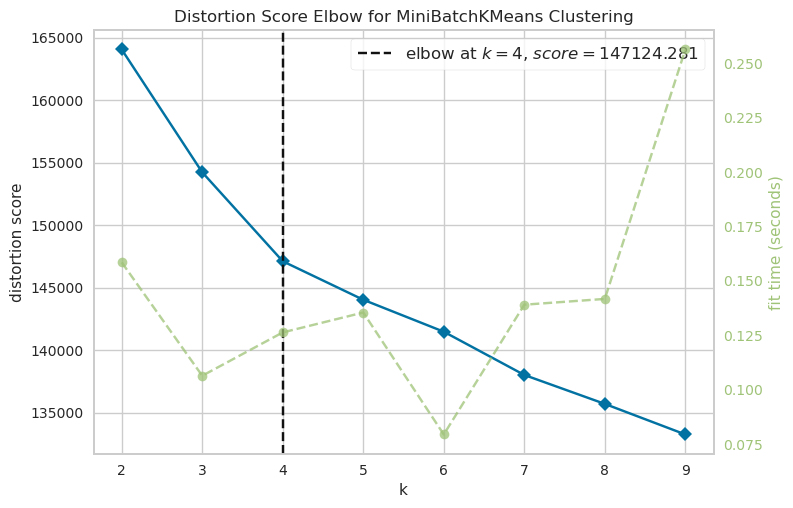

Optimal number of clusters: 4
Counter({0: 5594, 1: 4060, 3: 2376, 2: 1730})
silhouette score of clustering: 0.06153381335820598


In [34]:
model, sil_score, pred_labels = k_clustering(X_svd)
print('silhouette score of clustering:', sil_score)
custom_w2v_df['labels'] = pred_labels

In [35]:
X2 = get_embeddings(simple_tokenize('What do you need to know about raising a series A?')).astype('float').reshape(1,-1)
X2 = lsa.transform(X2)
new_cluster_label = model.predict(X2)[0]
cluster_docs = custom_w2v_df[custom_w2v_df['labels'] == new_cluster_label]
sentence_emb_array = np.stack(cluster_docs['svd_embeddings'].values)
similarity_scores = cosine_similarity(sentence_emb_array, X2)
results = pd.DataFrame({
    'title': cluster_docs['title'],
    'category': cluster_docs['category'],
    'labels': cluster_docs['labels'],
    'similarity': similarity_scores.flatten()
})

# Sort the results by similarity score
results = results.sort_values(by='similarity', ascending=False)

results.head(5)

title  \
35307                                                           The Series A Bottleneck Grows Tighter, Fenwick Survey Shows   
19939                                Etece, A Spanish TaskRabbit, Raises €450K Series A To Expand To Four More Local Cities   
16913                   Standing On Its Own: Wix Spin-Off daPulse Scores 1.5m Series A For Its Internal Communications Tool   
21933  With 4M Apartment Rentals Viewed On Its Site, Lovely Is Breaking Free Of Litigious Craigslist And Raising A Series A   
973                                                                Netflix is making its first original series out of India   

         category  labels  similarity  
35307    Startups       3    0.658592  
19939   eCommerce       3    0.555165  
16913  Enterprise       3    0.545024  
21933      Mobile       3    0.538288  
973          Asia       3    0.512180